# VQA - *Gan et al.* and Gradient - *Miatto et al*

This notebook implements the first QML algorithm proposed by <a href="https://arxiv.org/abs/2107.05224v1">Gan et al</a>. Moreover, it proposes an implementation of the gradient circuit proposed by <a href="https://quantum-journal.org/papers/q-2020-11-30-366/pdf/">Miatto et al</a>. Due to reasons explained later, we do not use the gradient in our implementation of <a href="https://arxiv.org/abs/2107.05224v1">Gan et al</a>. The reader can see the gradient's code as a code s/he can use later.


The <a href="https://arxiv.org/abs/2107.05224v1">Gan et al</a> algorithm is based on the following circuit:

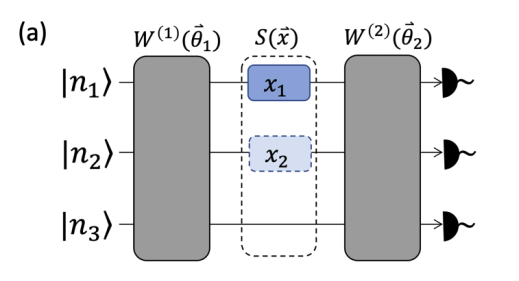

where $\vec{\theta_1}$ and $\vec{\theta_2}$ are the circuit parameters that define the general interferometers $W^{(1)}(\vec{\theta_1})$ and $W^{(2)}(\vec{\theta_2})$. The coordinates of a data points are given as the phases of the phase shifters in the middle.

The observable is defined as:

\begin{equation*}
    f(x_i, \Theta, \lambda) = \sum_{j, k, l}  \ \lambda_{j, k, l} \ |<n_j, n_k, n_l| \ \mathcal{U}(\Theta, x_i) \ |n_1, n_2, n_3>|^2
\end{equation*}

The vector $\lambda$ defines our model (i.e. the observable). The classification is determined by taking the **sign** of the model.

The aim of VQA methods is to train the values of the circuit and the observable parameters so as to define a good predicting model.

In [1]:
import perceval as pcvl
import perceval.lib.symb as symb
import numpy as np
import sklearn.datasets as skdt
import matplotlib.pyplot as plt
from math import comb
import time
from copy import deepcopy
import pybobyqa
from scipy.optimize import minimize, basinhopping, shgo, dual_annealing
import sympy as sp
from tqdm import tqdm

In [2]:
m = 3 # number of modes
a = 1
nb_param = 18
h = .1    # step size in the mesh
alpha_value = .0001

## Circuit set up

The circuit is set up beforehand since it does not depend on the type of the considered data set.

In [4]:
def set_up_QPC():

    global s1
    global px, py
    global c
    global circuit_P, beam_spliters, phase_shifters

    simulator_backend = pcvl.BackendFactory().get_backend("SLOS")

    px = pcvl.P("px")
    py = pcvl.P("py")

    circuit_P = np.array([pcvl.P("phi0"), pcvl.P("phi1"), pcvl.P("phi2"), pcvl.P("psi0"), pcvl.P("psi1"), pcvl.P("psi2")])
    thetas = np.array([pcvl.P("theta0"), pcvl.P("theta1"), pcvl.P("theta2"), pcvl.P("theta3"), pcvl.P("theta4"), pcvl.P("theta5")])
    ps = np.array([pcvl.P("p0"), pcvl.P("p1"), pcvl.P("p2"), pcvl.P("p3"), pcvl.P("p4"), pcvl.P("p5")])
    circuit_P = np.concatenate((circuit_P, thetas, ps))
    
    beam_spliters = []
    phase_shifters = []
    for i in range(nb_param // 6):
        r = i % 2
        beam_spliters.append(pcvl.Circuit(m=3).add((r, r + 1), symb.BS(theta=thetas[i], phi=ps[i])))
        phase_shifters.append(pcvl.Circuit(m=3).add(r, symb.PS(circuit_P[i])))
    for i in range(nb_param // 6):
        r = i % 2
        beam_spliters.append(pcvl.Circuit(m=3).add((r, r + 1), symb.BS(theta=thetas[i + nb_param // 6], phi=ps[i + nb_param // 6])))
        phase_shifters.append(pcvl.Circuit(m=3).add(r, symb.PS(circuit_P[i + nb_param // 6])))
    
    c = pcvl.Circuit(m=3)
    for i in range(nb_param // 6):
        c.add((0, 1, 2), beam_spliters[i]).add((0, 1, 2), phase_shifters[i])
    c.add(0, symb.PS(px))
    c.add(1, symb.PS(py))
    for i in range(nb_param // 6):
        c.add((0, 1, 2), beam_spliters[i + nb_param // 6]).add((0, 1, 2), phase_shifters[i + nb_param // 6])

    s1 = simulator_backend(pcvl.Matrix.random_unitary(m))

set_up_QPC()

## Data generation

The data is generated using the ```sklearn``` module. We can define three types of data sets:

1. linear data sets: they correspond to two blobs that can be separated by a hyperplane.
2. circular data sets: they correspond to two clusters that can be separated by a sphere.
3. lunar data sets: they correspond to two interwined semi-circle clusters. The separation between the two clusters requires a more complex shape.

For the sake of making the graphical representation easier, the data is normalized so as to make it within the hyprcube $[-1, 1 ]^D$.

In [5]:
def normalizeX(z):
    """
    Values between -1 and 1
    """
    zmax = np.max(z)
    zmin = np.min(z)
    return 2 * (z - zmin) / (zmax - zmin) - 1

def normalizey(z):
    """
    Values between -1 and 1
    """
    for i in range(len(z)):
        if z[i] == 0:
            z[i] = -1
    return z

def generate_data(type, N):
    """
    generates random datasets of different types
    type == 0: linear dataset
    type == 1: circular dataset
    type == 2: moon dataset
    """
    if type == 0: # linear
        X, y = skdt.make_blobs(n_samples=N, centers=2, n_features=2, cluster_std = 1)
    elif type == 1: # circle
        X, y = skdt.make_circles(n_samples=N, noise=0.03)
    elif type == 2: # moon
        X, y = skdt.make_moons(n_samples=N, noise=0.1)
    else:
        raise(ValueError("Invalid value of type. Enter help(generate_data)"))

    # data normalization
    X = normalizeX(X)
    y = normalizey(y)
    return X, y

## Loss function and gradient defintions

As proposed by <a href="https://arxiv.org/abs/2107.05224v1">Gan et al</a>, we use the following loss function:

\begin{equation*}
    \mathcal{L}(\Theta, \lambda) = \frac{1}{2 N} \ \sum_{i = 1}^{N} (y_i - f(x_i, \Theta, \lambda))^2 + \alpha \ \lambda.\lambda
\end{equation*}

We also implement the gradient of the loss function as proposed by <a href="https://quantum-journal.org/papers/q-2020-11-30-366/pdf/">Miatto et al</a>, even if we do *not* use it for our minimization. In the following, we note $G_{m, n} = <m|\mathcal{U}|n>$

Let us write the derivative of one term $\mathcal{L}(\Theta, \lambda)$ relative to a phase shifter parameter:

\begin{equation*}
\frac{\partial \mathcal{L}_i}{\partial \xi} = (f_i - y_i) \frac{\partial f_i}{\partial \xi}
\end{equation*}

However:

\begin{equation*}
f_i = \sum_{m} \lambda_{m, n} |G_{m, n}|^2 = \sum_m \lambda_{m, n} G_{m, n} G_{m, n}^*
\end{equation*}

Therefore:

\begin{equation*}
\frac{\partial f_i}{\partial \xi} = 2 \sum_m \lambda_{m, n} \ \Re\left(\frac{G_{m, n}}{\partial \xi} G_{m, n}^*\right)
\end{equation*}

Thus:

\begin{equation*}
\frac{\partial \mathcal{L}_i}{\partial \xi} = 2 (f_i - y_i) \sum_m \lambda_{m, n} \ \Re\left(\frac{G_{m, n}}{\partial \xi} G_{m, n}^*\right)
\end{equation*}

where by using (92) in <a href="https://quantum-journal.org/papers/q-2020-11-30-366/pdf/">Miatto et al</a>:

\begin{equation*}
\frac{\partial G_{m, n}}{\partial \xi} = i e^{i \xi} \sum_{1 \le r, s \le L} A[r, j] B[j, s] \sqrt{m_r n_s} G_{m - 1_r, n - 1_s}
\end{equation*}

The term $G_{m, n}$ is computed by using the (71) recursion.

In [6]:
def add(m, val, idx):
    res = deepcopy(m)
    res[idx] += val
    return res

In [7]:
def _tensor(U, k):
    
    if np.any(k[0] < 0) or np.any(k[1] < 0):
        return 0 
    
    if np.sum(k[0]) == np.sum(k[1]):
        
        if sum(k[0]) == 0: # basis case
            return 1
        
        for j in range(len(k[0])):
            if k[0][j] != 0:
                temp = np.multiply(U[j,:], np.sqrt(k[1]))
                return np.dot(temp,
                              np.array([_tensor(U, (add(k[0], -1, j), add(k[1], -1, s))) for s in range(len(k[1]))])) / np.sqrt(k[0][j])
        for j in range(len(k[1])):
            if k[1][j] != 0:
                temp = np.multiply(U[:,j], np.sqrt(k[0]))
                return np.dot(temp,
                              np.array([_tensor(U, (add(k[0], -1, s), add(k[1], -1, j))) for s in range(len(k[0]))])) / np.sqrt(k[1][j])
    return 0

In [8]:
def tensor_(U):
    return lambda k: _tensor(U, k)

In [9]:
def _grad_tensor(A, B, xi, j, k, G):
    
    temp_r = np.reshape(np.multiply(np.reshape(A[:, j], (1, len(k[0]))), np.sqrt(k[0])), (1, len(k[0])))
    temp_s = np.reshape(np.multiply(B[j, :], np.sqrt(k[1])), (len(k[1]), 1))
    tensor_matrix = np.array([[G((add(k[0], -1, r), add(k[1], -1, s))) for r in range(len(k[0]))] for s in range(len(k[1]))])
    res = temp_r @ tensor_matrix @ temp_s
    
    return complex(1j *  np.exp(1j * xi)  * res)

In [10]:
def grad_tensor(G, A, B, xi, j):
    return lambda k: _grad_tensor(A, B, xi, j, k, G)

In [11]:
def deriv_loss(G, dG, input_state, f, lab, lambda_val):
    states = list(s1.allstate_iterator(input_state))
    input_array = np.array(list(input_state))
    DG = np.array([dG((np.array(list(state)), input_array)) for state in states])
    GG = np.array([G((np.array(list(state)), input_array)) for state in states])
    temp = np.real(np.multiply(DG, np.conj(GG)))
    return 2 * (f - lab) * np.dot(lambda_val, temp)

In [12]:
def computation_loss(parameters):
    global X_quant, y_quant
    global circuit_P
    global c

    loss = 0
    
    # set new circuit parameters
    for j in range(nb_param):
        circuit_P[j].set_value(parameters[j])
 
    for i in tqdm(range(len(X_quant))):  
        px.set_value(X_quant[i,0])
        py.set_value(X_quant[i,1])
            
        s1.U = c.compute_unitary(use_symbolic=False)
        fvalue = np.sign(np.sum(np.multiply(s1.all_prob(input_state), parameters[nb_param:])))
        loss += np.linalg.norm(fvalue - y_quant[i])**2
            
    loss /= (2 * len(X_quant))
    loss += alpha_value * np.linalg.norm(parameters[nb_param:])**2   # regularization of the loss value
    print("loss:",loss)
    loss_list.append(loss)
    return loss

In [13]:
def computation_grad(parameters):
    
    grad = np.zeros((len(parameters,)))
        
    Px, Py = sp.symbols("Px Py")
    
    list_A = [pcvl.Circuit(m=3).U for _ in range(nb_param)] # identity matrices
    list_B = [pcvl.Circuit(m=3).U for _ in range(nb_param)] # identity matrices
    list_C = []
    list_A_value = [None for _ in range(nb_param)]
    list_B_value = [None for _ in range(nb_param)]
    
    for i in range(nb_param // 2): # parameters before the central phase shifters
        
        if i > 0:
            list_B[i] = phase_shifters[i - 1].U @ list_B[i - 1]
        list_B[i] = beam_spliters[i].U @ list_B[i]
        
    for i in range(nb_param // 2 - 2, -1, -1):
        list_A[i] = list_A[i + 1] @ phase_shifters[i + 1].U @ beam_spliters[i + 1].U
        
        
    for i in range(nb_param // 2, nb_param): # parameters after the central phase shifters
        
        if i > nb_param // 2:
            list_B[i] = phase_shifters[i - 1].U @ list_B[i - 1]
        list_B[i] = beam_spliters[i].U @ list_B[i]
        
    for i in range(nb_param -2, nb_param // 2 - 1, -1):
        list_A[i] = list_A[i + 1] @ phase_shifters[i + 1].U @ beam_spliters[i + 1].U
        
    list_C.append(phase_shifters[nb_param -1].U @ list_B[nb_param -1])
    list_C.append(phase_shifters[nb_param//2 -1].U @ list_B[nb_param//2 -1])
    
    for i in range(nb_param // 2): # parameters before the central phase shifters
        list_A[i] = list_C[0] @ np.diag(np.array([sp.exp(1j * Px), sp.exp(1j * Py), 1])) @ list_A[i]
            
    for i in range(nb_param // 2, nb_param): # parameters after the central phase shifters
        list_B[i] = list_B[i] @ np.diag(np.array([sp.exp(1j * Px), sp.exp(1j * Py), 1])) @ list_C[1]
        
    states = list(s1.allstate_iterator(input_state))
    input_array = np.array(list(input_state))
    
    idx = np.array([i for i in range(len(X_quant))])
    np.random.shuffle(idx)
    
    for i in tqdm(idx[:len(X_quant) // 10]):  
        px.set_value(X_quant[i,0])
        py.set_value(X_quant[i,1])
        
        for r in range(nb_param):
            list_A_value[r] = np.array(list_A[r].subs([(Px, px._value), (Py, py._value)]), dtype="complex128")
            list_B_value[r] = np.array(list_B[r].subs([(Px, px._value), (Py, py._value)]), dtype="complex128")
            
        s1.U = c.compute_unitary(use_symbolic=False)
        probs=s1.all_prob(input_state)
        fvalue = np.sign(np.sum(np.multiply(probs, parameters[nb_param:])))
        
        G = tensor_(s1.U)
        for s in range(nb_param // 2):
            dG = grad_tensor(G, list_A_value[s], list_B_value[s], parameters[s], s % 2)
            grad[s] += deriv_loss(G, dG, input_state, fvalue, y_quant[i], parameters[nb_param:])
            
        for s in range(nb_param // 2):
            dG = grad_tensor(G, list_A_value[s + nb_param // 2], list_B_value[s + nb_param // 2], parameters[s + nb_param // 2], s % 2)
            grad[s + nb_param // 2] += deriv_loss(G, dG, input_state, fvalue, y_quant[i], parameters[nb_param:])
            
        for s in range(nb_param, len(parameters)):
            grad[s] += (fvalue - y_quant[i]) * probs[s - nb_param]
            
    grad /= len(X_quant) // 10
    grad[nb_param:] += 2 * alpha_value * parameters[nb_param:]
    return grad

## Training

Through trial and error, we arrived to the conclusion that the best minimization algorithm is ```scipy.optimize.dual_annealing```. Gradient descent does not work in general because the function is strongly non-convex since our parameterization is not natural for our problem.

In [14]:
def training():
    
    def test(n):
        if n == 1:
            return 1e-3
        elif n == 6:
            return .5
        elif n == 3:
            return .2
        
    def maxeval(n):
        if n == 1:
            return 75
        elif n == 6:
            return 500
        elif n == 3:
            return 250
    
    global loss_list
    global X_quant, y_quant
    global input_state
    global parameters
    
    if n > 3:
        input_state = pcvl.BasicState([2]*(n // 2) + [1] * (n % 2) +[0]*(m- int(n / 2 + 0.5)))  # |1, ..., 1, 0, ..., 0>
    else:
        input_state = pcvl.BasicState([1] * n +[0]*(m- n))  # |2, ..., 2, (1), 0, ..., 0>
    loss_list=[]
    res=dual_annealing(computation_loss, [(0, 2 * np.pi)] * nb_param + [(-a, a)] * comb(n + m - 1, n),
                  maxfun=maxeval(n), no_local_search=True, callback=lambda x,f,content: f < test(n))
    parameters = res.x

## Scoring

We define the score as usual in ML. However, we add the fact that the input points may be modified in the following manner:

\begin{equation*}
x' = \alpha_x (x - \beta_x)
\end{equation*}

\begin{equation*}
y' = \alpha_y (y - \beta_y)
\end{equation*}

where $\alpha_x$, $\beta_x$, $\alpha_y$ and $\beta_y$ are defined in the vector ```scale```.

This approach will be useful in the training of the hyper-parameters $\alpha_x$, $\beta_x$, $\alpha_y$ and $\beta_y$.

In [15]:
def scoring(X, y, scale):
    cpt = 0
    for j in range(nb_param):
        circuit_P[j].set_value(parameters[j]) # set optimal parameters
    for i in range(len(X)):
        px.set_value(scale[0] * (X[i,0] - scale[2]))
        py.set_value(scale[1] * (X[i,1] - scale[3]))
        s1.U = c.compute_unitary(use_symbolic=False)
        fvalue = np.sign(np.sum(np.multiply(s1.all_prob(input_state), parameters[nb_param:])))
        if fvalue == y[i]:
            cpt += 1
    return cpt / len(X)

## Training of hyper-parameters

Once the circuit is trained (i.e. the minimization is over), we try as a last attempt to improve the classification. We apply the following space transformation:

\begin{equation*}
x' = \alpha_x (x - \beta_x)
\end{equation*}

\begin{equation*}
y' = \alpha_y (y - \beta_y)
\end{equation*}

where $\alpha_x$, $\beta_x$, $\alpha_y$ and $\beta_y$ are our hyper-parameters.

Starting from the initial values $ (\alpha_x, \beta_x, \alpha_y \beta_y) = (1, 0, 1, 0)$, we try to maximize *locally* the score function using the Python function ```pybobyqa.solve```.

In [16]:
def hyper_train(X, y):
    def function(scale):
        return - scoring(X, y, scale)
    score = 0
    scale = [1, 1, 0, 0]  # start by the default parameteres
    return pybobyqa.solve(function, scale, print_progress=True).x
    # we just want to slightly improve the quality of the result. We are already there

## Graphical representation

In [17]:
def plot_quantum_fitting(X, y, ret, scale):

    for j in range(nb_param):
        circuit_P[j].set_value(parameters[j]) # set optimal parameters

    # Generate figure
    plt.figure(figsize=(8,8))

    # create a mesh for the background

    xx = np.arange(-2, 2, h)
    yy = np.arange(-2, 2, h)
    zs = np.zeros((len(xx), len(yy)))
    for i in range(len(xx)):
        for j in range(len(yy)):
            px.set_value(scale[0] * (xx[i] - scale[2]))
            py.set_value(scale[1] * (yy[j] - scale[3]))
            s1.U = c.compute_unitary(use_symbolic=False)
            zs[i, j] = np.sign(np.sum(np.multiply(s1.all_prob(input_state), parameters[nb_param:])))
    cs = plt.contourf(xx, yy, zs, cmap=plt.cm.coolwarm)
    plt.colorbar(cs)

    # Plot scatter points
    plt.scatter(
        X[y == -1, 1],
        X[y == -1, 0],
        s=4,
        label='-1',
        alpha=1, c = ["#0cf9f1"]
    )
    plt.scatter(
        X[y == 1, 1],
        X[y == 1, 0],
        s=4,
        label='1',
        alpha=1,
        c = ["#790909"]
    )

    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    lgnd = plt.legend(fontsize=18)

    plt.xlim(-2, 2)
    plt.ylim(-2,2)
    for it in range(2):
        lgnd.legendHandles[it]._sizes = [40]
    plt.title("score = " + str(ret))
    plt.show()

## Wrapper

This wrapper calls the functions defined above. It starts by redefining the key value of $n$. Afterwards, it generates a normalized data set. The data set is divided into training, hyper-training and testing sets.
The wrapper trains the parameters of the circuit on the training sets. It trains the hyper-parameters on the hyper-training set. Finally, it computes the score and plots the graphical representation using the testing set.

In [18]:
def q_fit(type, N = 1000):

    """
    a wrapper that computes a random quantum fitting process
    type == 0: linear dataset
    type == 1: circular dataset
    type == 2: moon dataset
    """
    global n
    
    if type == 0:
        n = 1
    elif type == 1:
        n = 6
    elif type == 2:
        n = 3
    
    begin = time.time()
    global X_quant, y_quant
    X, y = generate_data(type, N)  # data generation
    prop1 = int(0.8 * len(y))
    prop2 = int(0.9 * len(y))
    X_quant = X[:prop1]
    y_quant = y[:prop1]
    training()  # train lambda
    scale = hyper_train(X[prop1:prop2], y[prop1:prop2])  # train the hyperparameters
    print("\n>>>>>> scale = ", scale) # print the best scale
    ret = scoring(X[prop2:], y[prop2:], scale) # compute the score on a new dataset
    print("\n>>>>>> score = ", ret)
    plot_quantum_fitting(X[prop2:], y[prop2:], ret, scale) # plot the results for the new dataset
    print("time : ", time.time() - begin)

## Examples

Below, we present some examples of VQA classification. We use the list ```loss_list``` in order to save the evolution of the loss value during the dual annealing process.

### Linear data set

VQA seems to get excellent results on linear data sets. As shown below, VQA can even acheive a perfect classification.

100%|██████████| 800/800 [00:00<00:00, 1574.11it/s]


loss: 1.1501428036369805


100%|██████████| 800/800 [00:00<00:00, 1664.08it/s]


loss: 0.9951068101964072


100%|██████████| 800/800 [00:00<00:00, 1697.91it/s]


loss: 1.0050613355382714


100%|██████████| 800/800 [00:00<00:00, 1714.72it/s]


loss: 0.9950753854610956


100%|██████████| 800/800 [00:00<00:00, 1715.88it/s]


loss: 0.9950989562834454


100%|██████████| 800/800 [00:00<00:00, 1741.50it/s]


loss: 1.0050863764419085


100%|██████████| 800/800 [00:00<00:00, 1703.36it/s]


loss: 2.0000477197772564


100%|██████████| 800/800 [00:00<00:00, 1698.08it/s]


loss: 1.0051234956473385


100%|██████████| 800/800 [00:00<00:00, 1700.36it/s]


loss: 1.0051552719527401


100%|██████████| 800/800 [00:00<00:00, 1718.60it/s]


loss: 0.995141246168603


100%|██████████| 800/800 [00:00<00:00, 1707.71it/s]


loss: 0.6875842882278154


100%|██████████| 800/800 [00:00<00:00, 1698.92it/s]


loss: 0.8800608538832


100%|██████████| 800/800 [00:00<00:00, 1710.42it/s]


loss: 1.0050231634190694


100%|██████████| 800/800 [00:00<00:00, 1707.15it/s]


loss: 0.9950256151546033


100%|██████████| 800/800 [00:00<00:00, 1692.85it/s]


loss: 0.9950390327568631


100%|██████████| 800/800 [00:00<00:00, 1698.88it/s]


loss: 1.0051149351615796


100%|██████████| 800/800 [00:00<00:00, 1733.73it/s]


loss: 1.0051692690057104


100%|██████████| 800/800 [00:00<00:00, 1729.66it/s]


loss: 0.99518823634619


100%|██████████| 800/800 [00:00<00:00, 1727.38it/s]


loss: 1.005094439969543


100%|██████████| 800/800 [00:00<00:00, 1719.71it/s]


loss: 0.0001156250811176973
 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1   -1.00e+00  0.00e+00  1.00e-01  1.00e-01    9   
  1     2   -1.00e+00  0.00e+00  5.00e-02  1.00e-02    9   
  1     3   -1.00e+00  0.00e+00  1.50e-02  1.00e-02   10   
  1     4   -1.00e+00  0.00e+00  1.50e-02  1.00e-02   11   
  1     5   -1.00e+00  0.00e+00  5.00e-03  1.00e-03   11   
  1     6   -1.00e+00  0.00e+00  1.50e-03  1.00e-03   12   
  1     7   -1.00e+00  0.00e+00  1.50e-03  1.00e-03   13   
  1     8   -1.00e+00  0.00e+00  5.00e-04  1.00e-04   13   
  1     9   -1.00e+00  0.00e+00  1.50e-04  1.00e-04   14   
  1    10   -1.00e+00  0.00e+00  1.50e-04  1.00e-04   15   
  1    11   -1.00e+00  0.00e+00  5.00e-05  1.00e-05   15   
  1    12   -1.00e+00  0.00e+00  1.50e-05  1.00e-05   16   
  1    13   -1.00e+00  0.00e+00  1.50e-05  1.00e-05   17   
  1    14   -1.00e+00  0.00e+00  5.00e-06  1.00e-06   17   
  1    15   -1.00e+00  0.00e+00  1.50e-06  1.00e-06   18   
  1    16   

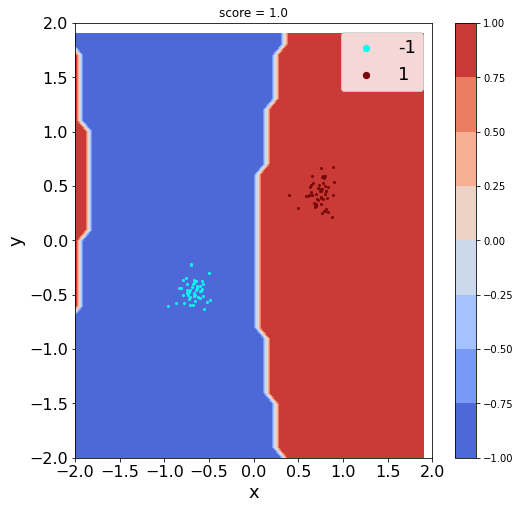

time :  12.068013429641724


In [19]:
q_fit(0, 1000)

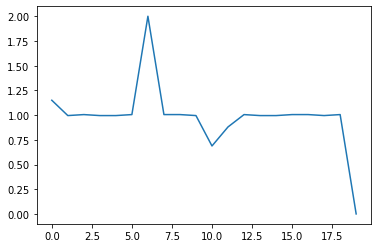

In [20]:
plt.plot([i for i in range(len(loss_list))], loss_list)

### Circular data set

Circular classification is the hardest for VQA. In spite of adding all possible parameters, the circuit seems to have a hard time expressing circular models. Indeed, we think that there is little hope that we can acheive a circular form using VQA. Nevertheless, we try to obtain an approximated form.

The difficulty does not reside in the possibility of expressing circular models, since we use general interferometers. The problem is that, since we use parameters unnatural to the problem, the loss function is far from being convex. In other terms, a small change in parameters can lead to dramatic changes in the spatial classification.

The situation is more problematic for circular data sets since the classifier we find do not have good discriminative power.

100%|██████████| 800/800 [00:00<00:00, 1565.73it/s]


loss: 1.0356603881619517


100%|██████████| 800/800 [00:00<00:00, 1582.31it/s]


loss: 0.9986872860686324


100%|██████████| 800/800 [00:00<00:00, 1539.39it/s]


loss: 1.001081143105876


100%|██████████| 800/800 [00:00<00:00, 1545.90it/s]


loss: 0.9333668689154794


100%|██████████| 800/800 [00:00<00:00, 1556.56it/s]


loss: 0.9109110562624809


100%|██████████| 800/800 [00:00<00:00, 1603.99it/s]


loss: 0.9084249795920085


100%|██████████| 800/800 [00:00<00:00, 1591.91it/s]


loss: 0.961118130283621


100%|██████████| 800/800 [00:00<00:00, 1596.01it/s]


loss: 1.0031959522343534


100%|██████████| 800/800 [00:00<00:00, 1592.29it/s]


loss: 1.0035583172799394


100%|██████████| 800/800 [00:00<00:00, 1603.64it/s]


loss: 0.9585420515520531


100%|██████████| 800/800 [00:00<00:00, 1628.44it/s]


loss: 1.0036182550413058


100%|██████████| 800/800 [00:00<00:00, 1663.21it/s]


loss: 0.9534810005106811


100%|██████████| 800/800 [00:00<00:00, 1648.46it/s]


loss: 0.9985258211854897


100%|██████████| 800/800 [00:00<00:00, 1661.64it/s]


loss: 0.8933767935851256


100%|██████████| 800/800 [00:00<00:00, 1657.38it/s]


loss: 1.05350390209303


100%|██████████| 800/800 [00:00<00:00, 1651.26it/s]


loss: 0.8710413014282101


100%|██████████| 800/800 [00:00<00:00, 1615.62it/s]


loss: 0.898275465119706


100%|██████████| 800/800 [00:00<00:00, 1669.29it/s]


loss: 1.0080820716064471


100%|██████████| 800/800 [00:00<00:00, 1660.47it/s]


loss: 1.153135787017355


100%|██████████| 800/800 [00:00<00:00, 1640.95it/s]


loss: 1.0038916312726573


100%|██████████| 800/800 [00:00<00:00, 1654.37it/s]


loss: 0.9986783953551835


100%|██████████| 800/800 [00:00<00:00, 1652.53it/s]


loss: 0.9708452527226159


100%|██████████| 800/800 [00:00<00:00, 1661.95it/s]


loss: 0.8783586666680069


100%|██████████| 800/800 [00:00<00:00, 1667.28it/s]


loss: 1.0035131438676672


100%|██████████| 800/800 [00:00<00:00, 1661.43it/s]


loss: 1.08589921425777


100%|██████████| 800/800 [00:00<00:00, 1657.63it/s]


loss: 0.9933835218140976


100%|██████████| 800/800 [00:00<00:00, 1676.13it/s]


loss: 1.023352402948214


100%|██████████| 800/800 [00:00<00:00, 1661.18it/s]


loss: 1.045863042601879


100%|██████████| 800/800 [00:00<00:00, 1613.69it/s]


loss: 0.8884208219296758


100%|██████████| 800/800 [00:00<00:00, 1651.77it/s]


loss: 1.028518546774643


100%|██████████| 800/800 [00:00<00:00, 1664.19it/s]


loss: 0.7008371164678996


100%|██████████| 800/800 [00:00<00:00, 1518.34it/s]


loss: 1.0033793985312527


100%|██████████| 800/800 [00:00<00:00, 1640.75it/s]


loss: 0.9509099027737039


100%|██████████| 800/800 [00:00<00:00, 1623.48it/s]


loss: 1.055729680400901


100%|██████████| 800/800 [00:00<00:00, 1661.37it/s]


loss: 1.0410159972935533


100%|██████████| 800/800 [00:00<00:00, 1658.32it/s]


loss: 1.0033002080821478


100%|██████████| 800/800 [00:00<00:00, 1644.20it/s]


loss: 1.125945182347177


100%|██████████| 800/800 [00:00<00:00, 1667.15it/s]


loss: 1.0334252172736726


100%|██████████| 800/800 [00:00<00:00, 1643.25it/s]


loss: 0.9209585293795118


100%|██████████| 800/800 [00:00<00:00, 1605.00it/s]


loss: 1.023374113333931


100%|██████████| 800/800 [00:00<00:00, 1639.91it/s]


loss: 1.1384973082910037


100%|██████████| 800/800 [00:00<00:00, 1664.23it/s]


loss: 1.1485463125359001


100%|██████████| 800/800 [00:00<00:00, 1665.30it/s]


loss: 0.9983377995649637


100%|██████████| 800/800 [00:00<00:00, 1657.70it/s]


loss: 0.9986044533173178


100%|██████████| 800/800 [00:00<00:00, 1634.57it/s]


loss: 1.1357088020139934


100%|██████████| 800/800 [00:00<00:00, 1662.72it/s]


loss: 1.030971431872259


100%|██████████| 800/800 [00:00<00:00, 1659.12it/s]


loss: 1.0832835791001976


100%|██████████| 800/800 [00:00<00:00, 1647.58it/s]


loss: 1.0057835791001974


100%|██████████| 800/800 [00:00<00:00, 1661.81it/s]


loss: 1.0032835791001975


100%|██████████| 800/800 [00:00<00:00, 1660.71it/s]


loss: 1.0332835791001975


100%|██████████| 800/800 [00:00<00:00, 1673.37it/s]


loss: 1.0282835791001976


100%|██████████| 800/800 [00:00<00:00, 1654.61it/s]


loss: 1.0282835791001976


100%|██████████| 800/800 [00:00<00:00, 1622.66it/s]


loss: 1.0282835791001976


100%|██████████| 800/800 [00:00<00:00, 1614.17it/s]


loss: 1.0557835791001975


100%|██████████| 800/800 [00:00<00:00, 1619.06it/s]


loss: 0.9982835791001976


100%|██████████| 800/800 [00:00<00:00, 1644.12it/s]


loss: 0.9982835791001976


100%|██████████| 800/800 [00:00<00:00, 1626.13it/s]


loss: 0.9982835791001976


100%|██████████| 800/800 [00:00<00:00, 1606.10it/s]


loss: 1.0032835791001975


100%|██████████| 800/800 [00:00<00:00, 1592.22it/s]


loss: 0.9732835791001976


100%|██████████| 800/800 [00:00<00:00, 1607.61it/s]


loss: 1.0032835791001975


100%|██████████| 800/800 [00:00<00:00, 1650.80it/s]


loss: 0.9382835791001976


100%|██████████| 800/800 [00:00<00:00, 1661.12it/s]


loss: 0.8507835791001975


100%|██████████| 800/800 [00:00<00:00, 1604.70it/s]


loss: 0.8832835791001975


100%|██████████| 800/800 [00:00<00:00, 1666.02it/s]


loss: 0.8282835791001976


100%|██████████| 800/800 [00:00<00:00, 1680.40it/s]


loss: 0.8282835791001976


100%|██████████| 800/800 [00:00<00:00, 1668.29it/s]


loss: 0.8233348806302153


100%|██████████| 800/800 [00:00<00:00, 1651.07it/s]


loss: 0.8233366028574977


100%|██████████| 800/800 [00:00<00:00, 1661.10it/s]


loss: 0.9033450129266398


100%|██████████| 800/800 [00:00<00:00, 1645.79it/s]


loss: 0.9283502166216646


100%|██████████| 800/800 [00:00<00:00, 1657.47it/s]


loss: 0.9283496000571193


100%|██████████| 800/800 [00:00<00:00, 1657.47it/s]


loss: 0.8284191809393441


100%|██████████| 800/800 [00:00<00:00, 1659.00it/s]


loss: 0.8259304430863472


100%|██████████| 800/800 [00:00<00:00, 1660.61it/s]


loss: 0.9934641154743382


100%|██████████| 800/800 [00:00<00:00, 1650.16it/s]


loss: 1.0034165203178742


100%|██████████| 800/800 [00:00<00:00, 1643.27it/s]


loss: 1.003492149345425


100%|██████████| 800/800 [00:00<00:00, 1664.27it/s]


loss: 1.0034735052373804


100%|██████████| 800/800 [00:00<00:00, 1674.56it/s]


loss: 1.0034312055106405


100%|██████████| 800/800 [00:00<00:00, 1663.37it/s]


loss: 1.0034525886737165


100%|██████████| 800/800 [00:00<00:00, 1683.36it/s]


loss: 1.003389179174963


100%|██████████| 800/800 [00:00<00:00, 1679.50it/s]


loss: 1.0033403894334747


100%|██████████| 800/800 [00:00<00:00, 1672.59it/s]


loss: 1.0033843494172636


100%|██████████| 800/800 [00:00<00:00, 1669.27it/s]


loss: 1.0033825289645866


100%|██████████| 800/800 [00:00<00:00, 1672.93it/s]


loss: 1.003392935945026


100%|██████████| 800/800 [00:00<00:00, 1672.37it/s]


loss: 1.003423962784235


100%|██████████| 800/800 [00:00<00:00, 1664.81it/s]


loss: 1.0034025964582336


100%|██████████| 800/800 [00:00<00:00, 1666.85it/s]


loss: 1.0034612401112553


100%|██████████| 800/800 [00:00<00:00, 1677.34it/s]


loss: 1.003387849942269


100%|██████████| 800/800 [00:00<00:00, 1683.08it/s]


loss: 1.0034396469190132


100%|██████████| 800/800 [00:00<00:00, 1678.70it/s]


loss: 1.003442012381792


100%|██████████| 800/800 [00:00<00:00, 1676.26it/s]


loss: 1.0034871968015489


100%|██████████| 800/800 [00:00<00:00, 1671.88it/s]


loss: 1.00351148903668


100%|██████████| 800/800 [00:00<00:00, 1674.19it/s]


loss: 1.0034853458248671


100%|██████████| 800/800 [00:00<00:00, 1664.55it/s]


loss: 1.003565387875415


100%|██████████| 800/800 [00:00<00:00, 1614.88it/s]


loss: 0.7156922341696059


100%|██████████| 800/800 [00:00<00:00, 1576.83it/s]


loss: 0.9984136618251159


100%|██████████| 800/800 [00:00<00:00, 1625.12it/s]


loss: 1.1856681107623925


100%|██████████| 800/800 [00:00<00:00, 1603.90it/s]


loss: 0.9985104779083267


100%|██████████| 800/800 [00:00<00:00, 1606.70it/s]


loss: 0.9056433605112301


100%|██████████| 800/800 [00:00<00:00, 1652.00it/s]


loss: 1.018670855664681


100%|██████████| 800/800 [00:00<00:00, 1661.90it/s]


loss: 1.2281672569891564


100%|██████████| 800/800 [00:00<00:00, 1667.88it/s]


loss: 0.9711850149808866


100%|██████████| 800/800 [00:00<00:00, 1671.87it/s]


loss: 0.9983883633756118


100%|██████████| 800/800 [00:00<00:00, 1679.07it/s]


loss: 1.2009546740673063


100%|██████████| 800/800 [00:00<00:00, 1637.62it/s]


loss: 0.8758807556823618


100%|██████████| 800/800 [00:00<00:00, 1682.83it/s]


loss: 1.1235033540877213


100%|██████████| 800/800 [00:00<00:00, 1650.54it/s]


loss: 1.0034026400933636


100%|██████████| 800/800 [00:00<00:00, 1667.57it/s]


loss: 1.0434078370774933


100%|██████████| 800/800 [00:00<00:00, 1656.55it/s]


loss: 1.058222928057303


100%|██████████| 800/800 [00:00<00:00, 1617.18it/s]


loss: 1.1107811152378533


100%|██████████| 800/800 [00:00<00:00, 1616.06it/s]


loss: 1.0011415071292105


100%|██████████| 800/800 [00:00<00:00, 1658.87it/s]


loss: 0.998176527936049


100%|██████████| 800/800 [00:00<00:00, 1666.41it/s]


loss: 0.9986457813826013


100%|██████████| 800/800 [00:00<00:00, 1619.84it/s]


loss: 0.9707168449198466


100%|██████████| 800/800 [00:00<00:00, 1646.19it/s]


loss: 0.9984411629847092


100%|██████████| 800/800 [00:00<00:00, 1644.87it/s]


loss: 1.1007989079840876


100%|██████████| 800/800 [00:00<00:00, 1478.40it/s]


loss: 0.9311811109782674


100%|██████████| 800/800 [00:00<00:00, 1384.34it/s]


loss: 0.9985380342835365


100%|██████████| 800/800 [00:00<00:00, 1385.68it/s]


loss: 1.0661297498877227


100%|██████████| 800/800 [00:00<00:00, 1377.81it/s]


loss: 1.006156441774844


100%|██████████| 800/800 [00:00<00:00, 1385.90it/s]


loss: 0.9786456768761408


100%|██████████| 800/800 [00:00<00:00, 1384.32it/s]


loss: 1.0036040693041224


100%|██████████| 800/800 [00:00<00:00, 1374.86it/s]


loss: 0.9985944516196915


100%|██████████| 800/800 [00:00<00:00, 1624.70it/s]


loss: 1.0034018520687715


100%|██████████| 800/800 [00:00<00:00, 1651.20it/s]


loss: 0.998374760609172


100%|██████████| 800/800 [00:00<00:00, 1653.49it/s]


loss: 1.003625545741446


100%|██████████| 800/800 [00:00<00:00, 1637.09it/s]


loss: 1.1134532137399216


100%|██████████| 800/800 [00:00<00:00, 1633.86it/s]


loss: 1.0157248961182868


100%|██████████| 800/800 [00:00<00:00, 1476.96it/s]


loss: 1.1535413254728213


100%|██████████| 800/800 [00:00<00:00, 1607.46it/s]


loss: 0.8260017093077535


100%|██████████| 800/800 [00:00<00:00, 1605.03it/s]


loss: 1.005822183634418


100%|██████████| 800/800 [00:00<00:00, 1593.81it/s]


loss: 0.8660509541432717


100%|██████████| 800/800 [00:00<00:00, 1595.15it/s]


loss: 0.8285854826148331


100%|██████████| 800/800 [00:00<00:00, 1597.12it/s]


loss: 1.2159011554971564


100%|██████████| 800/800 [00:00<00:00, 1591.92it/s]


loss: 1.0035971503974417


100%|██████████| 800/800 [00:00<00:00, 1610.62it/s]


loss: 0.9987734532865391


100%|██████████| 800/800 [00:00<00:00, 1609.83it/s]


loss: 0.998724053137544


100%|██████████| 800/800 [00:00<00:00, 1599.55it/s]


loss: 1.0683663334644495


100%|██████████| 800/800 [00:00<00:00, 1602.09it/s]


loss: 0.941032804753383


100%|██████████| 800/800 [00:00<00:00, 1600.85it/s]


loss: 1.0037728512597288


100%|██████████| 800/800 [00:00<00:00, 1604.72it/s]


loss: 0.9562728512597289


100%|██████████| 800/800 [00:00<00:00, 1429.91it/s]


loss: 0.971272851259729


100%|██████████| 800/800 [00:00<00:00, 1321.81it/s]


loss: 1.0037728512597288


100%|██████████| 800/800 [00:00<00:00, 1327.46it/s]


loss: 0.931272851259729


100%|██████████| 800/800 [00:00<00:00, 1342.73it/s]


loss: 0.8987728512597289


100%|██████████| 800/800 [00:00<00:00, 1322.22it/s]


loss: 0.8987728512597289


100%|██████████| 800/800 [00:00<00:00, 1316.43it/s]


loss: 0.953772851259729


100%|██████████| 800/800 [00:00<00:00, 1334.46it/s]


loss: 1.0037728512597288


100%|██████████| 800/800 [00:00<00:00, 1334.04it/s]


loss: 1.0037728512597288


100%|██████████| 800/800 [00:00<00:00, 1341.37it/s]


loss: 1.0037728512597288


100%|██████████| 800/800 [00:00<00:00, 1336.11it/s]


loss: 1.0037728512597288


100%|██████████| 800/800 [00:00<00:00, 1327.00it/s]


loss: 1.0037728512597288


100%|██████████| 800/800 [00:00<00:00, 1334.05it/s]


loss: 1.0037728512597288


100%|██████████| 800/800 [00:00<00:00, 1335.67it/s]


loss: 1.0037728512597288


100%|██████████| 800/800 [00:00<00:00, 1345.67it/s]


loss: 0.973772851259729


100%|██████████| 800/800 [00:00<00:00, 1340.31it/s]


loss: 0.983772851259729


100%|██████████| 800/800 [00:00<00:00, 1350.15it/s]


loss: 1.1062728512597289


100%|██████████| 800/800 [00:00<00:00, 1350.44it/s]


loss: 1.0037728512597288


100%|██████████| 800/800 [00:00<00:00, 1354.85it/s]


loss: 1.0037873756258784


100%|██████████| 800/800 [00:00<00:00, 1349.41it/s]


loss: 1.003810441631581


100%|██████████| 800/800 [00:00<00:00, 1345.87it/s]


loss: 1.0037979057757145


100%|██████████| 800/800 [00:00<00:00, 1347.27it/s]


loss: 1.0038183556993288


100%|██████████| 800/800 [00:00<00:00, 1319.87it/s]


loss: 1.0038023516105539


100%|██████████| 800/800 [00:00<00:00, 1325.90it/s]


loss: 1.0037964911002424


100%|██████████| 800/800 [00:00<00:00, 1342.72it/s]


loss: 1.0037473962787005


100%|██████████| 800/800 [00:00<00:00, 1348.96it/s]


loss: 1.0036576081996942


100%|██████████| 800/800 [00:00<00:00, 1350.41it/s]


loss: 1.0036348407941447


100%|██████████| 800/800 [00:00<00:00, 1325.51it/s]


loss: 1.003623259324879


100%|██████████| 800/800 [00:00<00:00, 1353.16it/s]


loss: 1.003625365244133


100%|██████████| 800/800 [00:00<00:00, 1352.97it/s]


loss: 1.003675423747106


100%|██████████| 800/800 [00:00<00:00, 1344.11it/s]


loss: 1.00364216687018


100%|██████████| 800/800 [00:00<00:00, 1350.65it/s]


loss: 1.0036398562070132


100%|██████████| 800/800 [00:00<00:00, 1349.12it/s]


loss: 0.981049745784471


100%|██████████| 800/800 [00:00<00:00, 1345.36it/s]


loss: 0.9935269724649519


100%|██████████| 800/800 [00:00<00:00, 1349.98it/s]


loss: 1.0034966942314634


100%|██████████| 800/800 [00:00<00:00, 1348.27it/s]


loss: 0.9885425878894836


100%|██████████| 800/800 [00:00<00:00, 1351.91it/s]


loss: 1.0434462013003822


100%|██████████| 800/800 [00:00<00:00, 1352.03it/s]


loss: 1.018380517473322


100%|██████████| 800/800 [00:00<00:00, 1340.34it/s]


loss: 1.0334447551085062


100%|██████████| 800/800 [00:00<00:00, 1344.52it/s]


loss: 1.0884984075908237


100%|██████████| 800/800 [00:00<00:00, 1344.60it/s]


loss: 1.1584661953926025


100%|██████████| 800/800 [00:00<00:00, 1390.23it/s]


loss: 1.0485546661908463


100%|██████████| 800/800 [00:00<00:00, 1382.38it/s]


loss: 1.0934651833101603


100%|██████████| 800/800 [00:00<00:00, 1371.85it/s]


loss: 1.0884681137719192


100%|██████████| 800/800 [00:00<00:00, 1383.31it/s]


loss: 1.1609000141903645


100%|██████████| 800/800 [00:00<00:00, 1388.31it/s]


loss: 1.1459440366901366


100%|██████████| 800/800 [00:00<00:00, 1368.16it/s]


loss: 0.9983077101414548


100%|██████████| 800/800 [00:00<00:00, 1376.73it/s]


loss: 1.0057693624064454


100%|██████████| 800/800 [00:00<00:00, 1385.23it/s]


loss: 1.0036035196460937


100%|██████████| 800/800 [00:00<00:00, 1388.51it/s]


loss: 0.9983711078566118


100%|██████████| 800/800 [00:00<00:00, 1390.06it/s]


loss: 0.9935172377669075


100%|██████████| 800/800 [00:00<00:00, 1395.26it/s]


loss: 1.0884336150985228


100%|██████████| 800/800 [00:00<00:00, 1400.57it/s]


loss: 0.9732366046316648


100%|██████████| 800/800 [00:00<00:00, 1385.18it/s]


loss: 1.0030042588076495


100%|██████████| 800/800 [00:00<00:00, 1384.22it/s]


loss: 0.9988102066652867


100%|██████████| 800/800 [00:00<00:00, 1387.12it/s]


loss: 0.9985180897931878


100%|██████████| 800/800 [00:00<00:00, 1381.79it/s]


loss: 0.888401600557206


100%|██████████| 800/800 [00:00<00:00, 1391.77it/s]


loss: 0.9982471295681103


100%|██████████| 800/800 [00:00<00:00, 1392.10it/s]


loss: 1.003677626361241


100%|██████████| 800/800 [00:00<00:00, 1395.56it/s]


loss: 1.0858375118534274


100%|██████████| 800/800 [00:00<00:00, 1393.75it/s]


loss: 1.1008261301316165


100%|██████████| 800/800 [00:00<00:00, 1341.98it/s]


loss: 0.9985452626473615


100%|██████████| 800/800 [00:00<00:00, 1391.13it/s]


loss: 0.9983443633162534


100%|██████████| 800/800 [00:00<00:00, 1385.46it/s]


loss: 0.9460664991349079


100%|██████████| 800/800 [00:00<00:00, 1371.89it/s]


loss: 0.9786043128125873


100%|██████████| 800/800 [00:00<00:00, 1392.79it/s]


loss: 0.9984995080335713


100%|██████████| 800/800 [00:00<00:00, 1383.14it/s]


loss: 1.013651781459059


100%|██████████| 800/800 [00:00<00:00, 1384.05it/s]


loss: 0.988334814685879


100%|██████████| 800/800 [00:00<00:00, 1362.83it/s]


loss: 0.9982769409584096


100%|██████████| 800/800 [00:00<00:00, 1395.45it/s]


loss: 1.0260851901732841


100%|██████████| 800/800 [00:00<00:00, 1381.02it/s]


loss: 1.0034480144361047


100%|██████████| 800/800 [00:00<00:00, 1398.51it/s]


loss: 0.9981261727240346


100%|██████████| 800/800 [00:00<00:00, 1384.95it/s]


loss: 1.0031601721376424


100%|██████████| 800/800 [00:00<00:00, 1398.60it/s]


loss: 1.0032646989277736


100%|██████████| 800/800 [00:00<00:00, 1380.98it/s]


loss: 1.0457098580453363


100%|██████████| 800/800 [00:00<00:00, 1383.29it/s]


loss: 0.9786050003691541


100%|██████████| 800/800 [00:00<00:00, 1395.51it/s]


loss: 1.0311458608015989


100%|██████████| 800/800 [00:00<00:00, 1409.57it/s]


loss: 0.9733474464270522


100%|██████████| 800/800 [00:00<00:00, 1411.16it/s]


loss: 0.9933311135362111


100%|██████████| 800/800 [00:00<00:00, 1371.52it/s]


loss: 1.0810753701876255


100%|██████████| 800/800 [00:00<00:00, 1299.00it/s]


loss: 1.025816763757069


100%|██████████| 800/800 [00:00<00:00, 1393.45it/s]


loss: 1.046125968977424


100%|██████████| 800/800 [00:00<00:00, 1389.62it/s]


loss: 0.9410459522034692


100%|██████████| 800/800 [00:00<00:00, 1394.32it/s]


loss: 1.0035033187229516


100%|██████████| 800/800 [00:00<00:00, 1368.75it/s]


loss: 0.9985110840415516


100%|██████████| 800/800 [00:00<00:00, 1389.86it/s]


loss: 0.9909130381101728


100%|██████████| 800/800 [00:00<00:00, 1395.77it/s]


loss: 0.7857141261882943


100%|██████████| 800/800 [00:00<00:00, 1405.09it/s]


loss: 0.9456776315275373


100%|██████████| 800/800 [00:00<00:00, 1394.46it/s]


loss: 1.0083632097476491


100%|██████████| 800/800 [00:00<00:00, 1388.55it/s]


loss: 1.0835451521331996


100%|██████████| 800/800 [00:00<00:00, 1388.05it/s]


loss: 1.053339578153123


100%|██████████| 800/800 [00:00<00:00, 1394.09it/s]


loss: 1.0061110985576127


100%|██████████| 800/800 [00:00<00:00, 1398.45it/s]


loss: 0.9986110985576128


100%|██████████| 800/800 [00:00<00:00, 1396.61it/s]


loss: 0.9986110985576128


100%|██████████| 800/800 [00:00<00:00, 1401.30it/s]


loss: 0.9986110985576128


100%|██████████| 800/800 [00:00<00:00, 1402.96it/s]


loss: 0.9636110985576127


100%|██████████| 800/800 [00:00<00:00, 1386.85it/s]


loss: 1.0036110985576128


100%|██████████| 800/800 [00:00<00:00, 1402.44it/s]


loss: 1.0036110985576128


100%|██████████| 800/800 [00:00<00:00, 1410.00it/s]


loss: 0.9986110985576128


100%|██████████| 800/800 [00:00<00:00, 1402.92it/s]


loss: 0.9986110985576128


100%|██████████| 800/800 [00:00<00:00, 1379.89it/s]


loss: 0.9986110985576128


100%|██████████| 800/800 [00:00<00:00, 1390.32it/s]


loss: 0.9986110985576128


100%|██████████| 800/800 [00:00<00:00, 1409.52it/s]


loss: 0.9486110985576127


100%|██████████| 800/800 [00:00<00:00, 1398.79it/s]


loss: 0.9986110985576128


100%|██████████| 800/800 [00:00<00:00, 1402.31it/s]


loss: 0.9986110985576128


100%|██████████| 800/800 [00:00<00:00, 1399.02it/s]


loss: 0.9986110985576128


100%|██████████| 800/800 [00:00<00:00, 1409.80it/s]


loss: 0.9986110985576128


100%|██████████| 800/800 [00:00<00:00, 1402.28it/s]


loss: 0.9986110985576128


100%|██████████| 800/800 [00:00<00:00, 1405.54it/s]


loss: 0.9986110985576128


100%|██████████| 800/800 [00:00<00:00, 1399.48it/s]


loss: 1.0061110985576127


100%|██████████| 800/800 [00:00<00:00, 1404.13it/s]


loss: 1.0060784680577304


100%|██████████| 800/800 [00:00<00:00, 1354.22it/s]


loss: 0.9985619898635721


100%|██████████| 800/800 [00:00<00:00, 1380.15it/s]


loss: 1.0059856157351184


100%|██████████| 800/800 [00:00<00:00, 1351.83it/s]


loss: 0.9985081338067402


100%|██████████| 800/800 [00:00<00:00, 1541.88it/s]


loss: 0.9984690438730691


100%|██████████| 800/800 [00:00<00:00, 1592.09it/s]


loss: 0.998489248963604


100%|██████████| 800/800 [00:00<00:00, 1621.72it/s]


loss: 0.9985029963297838


100%|██████████| 800/800 [00:00<00:00, 1626.29it/s]


loss: 0.9985793426738003


100%|██████████| 800/800 [00:00<00:00, 1622.69it/s]


loss: 0.9985701457654501


100%|██████████| 800/800 [00:00<00:00, 1621.76it/s]


loss: 0.9985946873123942


100%|██████████| 800/800 [00:00<00:00, 1636.62it/s]


loss: 0.9985505368495851


100%|██████████| 800/800 [00:00<00:00, 1597.71it/s]


loss: 0.9985559072828049


100%|██████████| 800/800 [00:00<00:00, 1633.40it/s]


loss: 0.998472927038157


100%|██████████| 800/800 [00:00<00:00, 1628.67it/s]


loss: 0.9984354712424949


100%|██████████| 800/800 [00:00<00:00, 1641.90it/s]


loss: 0.9984737217218865


100%|██████████| 800/800 [00:00<00:00, 1627.23it/s]


loss: 0.9984702946982139


100%|██████████| 800/800 [00:00<00:00, 1636.60it/s]


loss: 0.9984422098079309


100%|██████████| 800/800 [00:00<00:00, 1635.98it/s]


loss: 0.9984215253512125


100%|██████████| 800/800 [00:00<00:00, 1619.00it/s]


loss: 0.9983743060764342


100%|██████████| 800/800 [00:00<00:00, 1608.68it/s]


loss: 0.9983668042204134


100%|██████████| 800/800 [00:00<00:00, 1660.21it/s]


loss: 0.9983468787064722


100%|██████████| 800/800 [00:00<00:00, 1643.14it/s]


loss: 0.9983985771364572


100%|██████████| 800/800 [00:00<00:00, 1643.49it/s]


loss: 0.998323343356274


100%|██████████| 800/800 [00:00<00:00, 1641.45it/s]


loss: 0.9982391389696218


100%|██████████| 800/800 [00:00<00:00, 1615.33it/s]


loss: 1.0982617278124718


100%|██████████| 800/800 [00:00<00:00, 1624.73it/s]


loss: 1.103272731435216


100%|██████████| 800/800 [00:00<00:00, 1641.26it/s]


loss: 1.1032714260670415


100%|██████████| 800/800 [00:00<00:00, 1631.64it/s]


loss: 1.0657508035619325


100%|██████████| 800/800 [00:00<00:00, 1626.65it/s]


loss: 1.025899554844436


100%|██████████| 800/800 [00:00<00:00, 1629.56it/s]


loss: 0.9260454740474217


100%|██████████| 800/800 [00:00<00:00, 1596.83it/s]


loss: 1.05346188815612


100%|██████████| 800/800 [00:00<00:00, 1629.69it/s]


loss: 1.0033961396082733


100%|██████████| 800/800 [00:00<00:00, 1633.13it/s]


loss: 1.0034006846725403


100%|██████████| 800/800 [00:00<00:00, 1619.30it/s]


loss: 1.2435262150955981


100%|██████████| 800/800 [00:00<00:00, 1620.10it/s]


loss: 0.9985419477272018


100%|██████████| 800/800 [00:00<00:00, 1620.24it/s]


loss: 1.1209004438985992


100%|██████████| 800/800 [00:00<00:00, 1595.37it/s]


loss: 1.1761792310395485


100%|██████████| 800/800 [00:00<00:00, 1617.88it/s]


loss: 1.0210229105512565


100%|██████████| 800/800 [00:00<00:00, 1619.62it/s]


loss: 1.0308578096459309


100%|██████████| 800/800 [00:00<00:00, 1606.23it/s]


loss: 1.0034150853625752


100%|██████████| 800/800 [00:00<00:00, 1607.18it/s]


loss: 1.0461023529996765


100%|██████████| 800/800 [00:00<00:00, 1612.85it/s]


loss: 1.0034459495199375


100%|██████████| 800/800 [00:00<00:00, 1592.50it/s]


loss: 0.988316001896841


100%|██████████| 800/800 [00:00<00:00, 1625.42it/s]


loss: 0.9984652464576708


100%|██████████| 800/800 [00:00<00:00, 1628.33it/s]


loss: 0.873462713085884


100%|██████████| 800/800 [00:00<00:00, 1623.31it/s]


loss: 1.0035762824487726


100%|██████████| 800/800 [00:00<00:00, 1622.26it/s]


loss: 0.9234318034697175


100%|██████████| 800/800 [00:00<00:00, 1622.39it/s]


loss: 1.003327470047563


100%|██████████| 800/800 [00:00<00:00, 1602.47it/s]


loss: 0.913416642728925


100%|██████████| 800/800 [00:00<00:00, 1623.60it/s]


loss: 0.9983671845953301


100%|██████████| 800/800 [00:00<00:00, 1626.30it/s]


loss: 1.0033936579712581


100%|██████████| 800/800 [00:00<00:00, 1613.24it/s]


loss: 1.0034247420091031


100%|██████████| 800/800 [00:00<00:00, 1623.77it/s]


loss: 0.9983322266755317


100%|██████████| 800/800 [00:00<00:00, 1622.17it/s]


loss: 1.0807915227092295


100%|██████████| 800/800 [00:00<00:00, 1593.32it/s]


loss: 1.0106513447796106


100%|██████████| 800/800 [00:00<00:00, 1622.48it/s]


loss: 0.9985418177198138


100%|██████████| 800/800 [00:00<00:00, 1627.56it/s]


loss: 1.003091643110387


100%|██████████| 800/800 [00:00<00:00, 1631.55it/s]


loss: 0.9135543060973259


100%|██████████| 800/800 [00:00<00:00, 1630.78it/s]


loss: 0.9760157118491968


100%|██████████| 800/800 [00:00<00:00, 1631.15it/s]


loss: 0.8632408860863179


100%|██████████| 800/800 [00:00<00:00, 1613.63it/s]


loss: 1.0132118761730144


100%|██████████| 800/800 [00:00<00:00, 1635.79it/s]


loss: 0.8683138802985697


100%|██████████| 800/800 [00:00<00:00, 1632.76it/s]


loss: 1.1932280857048425


100%|██████████| 800/800 [00:00<00:00, 1626.88it/s]


loss: 1.0033107963181969


100%|██████████| 800/800 [00:00<00:00, 1621.15it/s]


loss: 1.1086236429609881


100%|██████████| 800/800 [00:00<00:00, 1625.91it/s]


loss: 1.0359136650100276


100%|██████████| 800/800 [00:00<00:00, 1603.26it/s]


loss: 1.0058572181030143


100%|██████████| 800/800 [00:00<00:00, 1633.36it/s]


loss: 1.1957348244852524


100%|██████████| 800/800 [00:00<00:00, 1596.70it/s]


loss: 0.8958272590649033


100%|██████████| 800/800 [00:00<00:00, 1629.95it/s]


loss: 1.0684776231779236


100%|██████████| 800/800 [00:00<00:00, 1628.94it/s]


loss: 0.9987473422757953


100%|██████████| 800/800 [00:00<00:00, 1623.36it/s]


loss: 1.0309082519598274


100%|██████████| 800/800 [00:00<00:00, 1575.06it/s]


loss: 0.9360634007348357


100%|██████████| 800/800 [00:00<00:00, 1618.34it/s]


loss: 1.190813139107518


100%|██████████| 800/800 [00:00<00:00, 1619.78it/s]


loss: 1.1883131391075181


100%|██████████| 800/800 [00:00<00:00, 1628.89it/s]


loss: 1.2383131391075182


100%|██████████| 800/800 [00:00<00:00, 1637.37it/s]


loss: 0.9358131391075183


100%|██████████| 800/800 [00:00<00:00, 1641.08it/s]


loss: 1.0808131391075182


100%|██████████| 800/800 [00:00<00:00, 1603.02it/s]


loss: 0.9983131391075183


100%|██████████| 800/800 [00:00<00:00, 1617.62it/s]


loss: 0.9983131391075183


100%|██████████| 800/800 [00:00<00:00, 1625.63it/s]


loss: 0.9983131391075183


100%|██████████| 800/800 [00:00<00:00, 1621.68it/s]


loss: 0.9983131391075183


100%|██████████| 800/800 [00:00<00:00, 1641.78it/s]


loss: 0.9983131391075183


100%|██████████| 800/800 [00:00<00:00, 1639.16it/s]


loss: 0.9758131391075182


100%|██████████| 800/800 [00:00<00:00, 1624.90it/s]


loss: 1.068313139107518


100%|██████████| 800/800 [00:00<00:00, 1605.49it/s]


loss: 0.9983131391075183


100%|██████████| 800/800 [00:00<00:00, 1632.24it/s]


loss: 0.9458131391075182


100%|██████████| 800/800 [00:00<00:00, 1625.79it/s]


loss: 0.6883131391075182


100%|██████████| 800/800 [00:00<00:00, 1631.13it/s]


loss: 0.9983131391075183


100%|██████████| 800/800 [00:00<00:00, 1612.29it/s]


loss: 0.9983131391075183


100%|██████████| 800/800 [00:00<00:00, 1583.01it/s]


loss: 0.9983131391075183


100%|██████████| 800/800 [00:00<00:00, 1583.98it/s]


loss: 0.9508131391075182


100%|██████████| 800/800 [00:00<00:00, 1594.03it/s]


loss: 0.975755250023219


100%|██████████| 800/800 [00:00<00:00, 1630.31it/s]


loss: 0.9982232026037603


100%|██████████| 800/800 [00:00<00:00, 1595.51it/s]


loss: 0.9982949624908332


100%|██████████| 800/800 [00:00<00:00, 1628.49it/s]


loss: 0.9982077088757202


100%|██████████| 800/800 [00:00<00:00, 1583.91it/s]


loss: 0.998203495346335


100%|██████████| 800/800 [00:00<00:00, 1611.26it/s]


loss: 0.9982169539603126


100%|██████████| 800/800 [00:00<00:00, 1629.82it/s]


loss: 0.9982377130642175


100%|██████████| 800/800 [00:00<00:00, 1608.82it/s]


loss: 0.9982145277258069


100%|██████████| 800/800 [00:00<00:00, 1586.25it/s]


loss: 1.0231942984732012


100%|██████████| 800/800 [00:00<00:00, 1619.85it/s]


loss: 1.0406926374395504


100%|██████████| 800/800 [00:00<00:00, 1584.77it/s]


loss: 0.9981555326841246


100%|██████████| 800/800 [00:00<00:00, 1621.37it/s]


loss: 0.9981211425470982


100%|██████████| 800/800 [00:00<00:00, 1589.44it/s]


loss: 0.9982066060368235


100%|██████████| 800/800 [00:00<00:00, 1625.07it/s]


loss: 0.9981820127383705


100%|██████████| 800/800 [00:00<00:00, 1584.74it/s]


loss: 0.9981816612576557


100%|██████████| 800/800 [00:00<00:00, 1623.86it/s]


loss: 0.9981652290673385


100%|██████████| 800/800 [00:00<00:00, 1590.85it/s]


loss: 0.9981783871995402


100%|██████████| 800/800 [00:00<00:00, 1619.74it/s]


loss: 0.9981930914338593


100%|██████████| 800/800 [00:00<00:00, 1591.58it/s]


loss: 0.9981466985904972


100%|██████████| 800/800 [00:00<00:00, 1625.52it/s]


loss: 0.9981457166929677


100%|██████████| 800/800 [00:00<00:00, 1558.11it/s]


loss: 0.9981681999502944


100%|██████████| 800/800 [00:00<00:00, 1624.14it/s]


loss: 0.9981471679585239


100%|██████████| 800/800 [00:00<00:00, 1585.85it/s]


loss: 0.998124380717555


100%|██████████| 800/800 [00:00<00:00, 1607.07it/s]


loss: 0.9981179150169395


100%|██████████| 800/800 [00:00<00:00, 1577.02it/s]


loss: 0.9981195247817987


100%|██████████| 800/800 [00:00<00:00, 1607.88it/s]


loss: 0.9981030826665188


100%|██████████| 800/800 [00:00<00:00, 1574.68it/s]


loss: 0.9981987452656347


100%|██████████| 800/800 [00:00<00:00, 1605.31it/s]


loss: 0.9982498447858261


100%|██████████| 800/800 [00:00<00:00, 1567.72it/s]


loss: 0.9983159084076418


100%|██████████| 800/800 [00:00<00:00, 1610.27it/s]


loss: 1.0035851985521667


100%|██████████| 800/800 [00:00<00:00, 1567.30it/s]


loss: 0.8884268387641443


100%|██████████| 800/800 [00:00<00:00, 1600.73it/s]


loss: 1.0034787515825674


100%|██████████| 800/800 [00:00<00:00, 1568.06it/s]


loss: 1.0509689422876916


100%|██████████| 800/800 [00:00<00:00, 1597.88it/s]


loss: 0.8407625648561139


100%|██████████| 800/800 [00:00<00:00, 1564.99it/s]


loss: 0.9534958116819374


100%|██████████| 800/800 [00:00<00:00, 1589.19it/s]


loss: 0.8135173019520662


100%|██████████| 800/800 [00:00<00:00, 1568.22it/s]


loss: 0.9709704024068033


100%|██████████| 800/800 [00:00<00:00, 1602.21it/s]


loss: 1.0033001374806234


100%|██████████| 800/800 [00:00<00:00, 1561.17it/s]


loss: 1.0135376992276233


100%|██████████| 800/800 [00:00<00:00, 1571.86it/s]


loss: 0.9983917646799166


100%|██████████| 800/800 [00:00<00:00, 1601.95it/s]


loss: 0.9982062535047648


100%|██████████| 800/800 [00:00<00:00, 1574.44it/s]


loss: 0.9986802817932918


100%|██████████| 800/800 [00:00<00:00, 1601.13it/s]


loss: 1.0784204382928226


100%|██████████| 800/800 [00:00<00:00, 1571.73it/s]


loss: 1.118634318821963


100%|██████████| 800/800 [00:00<00:00, 1596.56it/s]


loss: 0.8509115973399707


100%|██████████| 800/800 [00:00<00:00, 1542.82it/s]


loss: 1.0035534773837018


100%|██████████| 800/800 [00:00<00:00, 1610.10it/s]


loss: 1.0133075198445112


100%|██████████| 800/800 [00:00<00:00, 1583.00it/s]


loss: 1.0509898014952157


100%|██████████| 800/800 [00:00<00:00, 1608.90it/s]


loss: 0.9559888944298477


100%|██████████| 800/800 [00:00<00:00, 1559.63it/s]


loss: 1.0034826872697744


100%|██████████| 800/800 [00:00<00:00, 1604.70it/s]


loss: 1.0509204240582721


100%|██████████| 800/800 [00:00<00:00, 1553.62it/s]


loss: 1.003517638369945


100%|██████████| 800/800 [00:00<00:00, 1596.20it/s]


loss: 1.0035143656813794


100%|██████████| 800/800 [00:00<00:00, 1565.38it/s]


loss: 1.118287900355097


100%|██████████| 800/800 [00:00<00:00, 1602.44it/s]


loss: 0.9983288442649738


100%|██████████| 800/800 [00:00<00:00, 1572.26it/s]


loss: 0.9984541807100314


100%|██████████| 800/800 [00:00<00:00, 1626.58it/s]


loss: 1.0759835816496819


100%|██████████| 800/800 [00:00<00:00, 1592.98it/s]


loss: 0.9737381703486917


100%|██████████| 800/800 [00:00<00:00, 1585.27it/s]


loss: 1.0032884666111153


100%|██████████| 800/800 [00:00<00:00, 1569.85it/s]


loss: 0.9986987184549061


100%|██████████| 800/800 [00:00<00:00, 1602.20it/s]


loss: 1.1035831926340616


100%|██████████| 800/800 [00:00<00:00, 1573.38it/s]


loss: 0.8736054356023004


100%|██████████| 800/800 [00:00<00:00, 1567.62it/s]


loss: 1.0358131047344805


100%|██████████| 800/800 [00:00<00:00, 1557.28it/s]


loss: 0.9982763197057744


100%|██████████| 800/800 [00:00<00:00, 1568.05it/s]


loss: 1.0033471936491871


100%|██████████| 800/800 [00:00<00:00, 1573.25it/s]


loss: 1.003242108258476


100%|██████████| 800/800 [00:00<00:00, 1609.97it/s]


loss: 0.9061579069000466


100%|██████████| 800/800 [00:00<00:00, 1574.40it/s]


loss: 1.0212081355074074


100%|██████████| 800/800 [00:00<00:00, 1606.35it/s]


loss: 0.9436763193450668


100%|██████████| 800/800 [00:00<00:00, 1577.22it/s]


loss: 0.9985850159305554


100%|██████████| 800/800 [00:00<00:00, 1610.23it/s]


loss: 0.9958358088572168


100%|██████████| 800/800 [00:00<00:00, 1574.92it/s]


loss: 1.0208199715008968


100%|██████████| 800/800 [00:00<00:00, 1612.55it/s]


loss: 1.160984662700703


100%|██████████| 800/800 [00:00<00:00, 1577.95it/s]


loss: 1.0059102704277822


100%|██████████| 800/800 [00:00<00:00, 1615.49it/s]


loss: 1.0034102704277823


100%|██████████| 800/800 [00:00<00:00, 1579.90it/s]


loss: 1.0234102704277823


100%|██████████| 800/800 [00:00<00:00, 1609.59it/s]


loss: 0.9859102704277822


100%|██████████| 800/800 [00:00<00:00, 1578.46it/s]


loss: 1.1684102704277823


100%|██████████| 800/800 [00:00<00:00, 1622.05it/s]


loss: 0.9984102704277823


100%|██████████| 800/800 [00:00<00:00, 1581.66it/s]


loss: 0.9984102704277823


100%|██████████| 800/800 [00:00<00:00, 1615.56it/s]


loss: 1.1759102704277824


100%|██████████| 800/800 [00:00<00:00, 1571.76it/s]


loss: 0.9759102704277822


100%|██████████| 800/800 [00:00<00:00, 1612.70it/s]


loss: 0.9684102704277823


100%|██████████| 800/800 [00:00<00:00, 1577.04it/s]


loss: 0.9934102704277823


100%|██████████| 800/800 [00:00<00:00, 1610.88it/s]


loss: 1.0434102704277823


100%|██████████| 800/800 [00:00<00:00, 1573.48it/s]


loss: 1.0809102704277824


100%|██████████| 800/800 [00:00<00:00, 1604.88it/s]


loss: 0.8909102704277823


100%|██████████| 800/800 [00:00<00:00, 1569.25it/s]


loss: 1.0034102704277823


100%|██████████| 800/800 [00:00<00:00, 1609.97it/s]


loss: 1.0009102704277824


100%|██████████| 800/800 [00:00<00:00, 1584.80it/s]


loss: 0.9034102704277822


100%|██████████| 800/800 [00:00<00:00, 1611.13it/s]


loss: 0.9984102704277823


100%|██████████| 800/800 [00:00<00:00, 1574.59it/s]


loss: 0.9934102704277823


100%|██████████| 800/800 [00:00<00:00, 1614.48it/s]


loss: 1.0034140040041626


100%|██████████| 800/800 [00:00<00:00, 1584.28it/s]


loss: 1.0133904392998352


100%|██████████| 800/800 [00:00<00:00, 1630.39it/s]


loss: 1.0209162082662566


100%|██████████| 800/800 [00:00<00:00, 1594.46it/s]


loss: 0.990832656444403


100%|██████████| 800/800 [00:00<00:00, 1625.98it/s]


loss: 0.960817559416536


100%|██████████| 800/800 [00:00<00:00, 1597.91it/s]


loss: 0.9733188583852003


100%|██████████| 800/800 [00:00<00:00, 1601.47it/s]


loss: 0.9508671406422285


100%|██████████| 800/800 [00:00<00:00, 1630.23it/s]


loss: 0.8983592566687915


100%|██████████| 800/800 [00:00<00:00, 1607.79it/s]


loss: 0.933380077948361


100%|██████████| 800/800 [00:00<00:00, 1622.44it/s]


loss: 0.8159132403856285


100%|██████████| 800/800 [00:00<00:00, 1625.97it/s]


loss: 0.8585027778530433


100%|██████████| 800/800 [00:00<00:00, 1619.82it/s]


loss: 0.9559584830211729


100%|██████████| 800/800 [00:00<00:00, 1628.09it/s]


loss: 0.9559210757855684


100%|██████████| 800/800 [00:00<00:00, 1640.45it/s]


loss: 0.9734088225213003


100%|██████████| 800/800 [00:00<00:00, 1622.62it/s]


loss: 0.9434474744317228


100%|██████████| 800/800 [00:00<00:00, 1642.22it/s]


loss: 0.9985227149299758


100%|██████████| 800/800 [00:00<00:00, 1623.19it/s]


loss: 0.9984297644101189


100%|██████████| 800/800 [00:00<00:00, 1657.84it/s]


loss: 0.9984040646550044


100%|██████████| 800/800 [00:00<00:00, 1629.42it/s]


loss: 0.9983989678931263


100%|██████████| 800/800 [00:00<00:00, 1656.03it/s]


loss: 0.9984971848958912


100%|██████████| 800/800 [00:00<00:00, 1605.95it/s]


loss: 0.9984233092874062


100%|██████████| 800/800 [00:00<00:00, 1660.98it/s]


loss: 0.8708494474902694


100%|██████████| 800/800 [00:00<00:00, 1626.35it/s]


loss: 0.9983766612867946


100%|██████████| 800/800 [00:00<00:00, 1658.07it/s]


loss: 1.0359715765810793


100%|██████████| 800/800 [00:00<00:00, 1628.30it/s]


loss: 0.9660427638375567


100%|██████████| 800/800 [00:00<00:00, 1656.42it/s]


loss: 0.9660378169119211


100%|██████████| 800/800 [00:00<00:00, 1637.23it/s]


loss: 0.9660457456901382


100%|██████████| 800/800 [00:00<00:00, 1668.95it/s]


loss: 0.9885431099506866


100%|██████████| 800/800 [00:00<00:00, 1590.12it/s]


loss: 0.9832048356486897


100%|██████████| 800/800 [00:00<00:00, 1624.62it/s]


loss: 0.9557533728627732


100%|██████████| 800/800 [00:00<00:00, 1630.66it/s]


loss: 0.9983546711260645


100%|██████████| 800/800 [00:00<00:00, 1615.46it/s]


loss: 1.053500938480131


100%|██████████| 800/800 [00:00<00:00, 1582.38it/s]


loss: 1.003217398309263


100%|██████████| 800/800 [00:00<00:00, 1619.39it/s]


loss: 0.975646874101447


100%|██████████| 800/800 [00:00<00:00, 1621.56it/s]


loss: 0.9156448556135565


100%|██████████| 800/800 [00:00<00:00, 1620.91it/s]


loss: 0.9632077684874272


100%|██████████| 800/800 [00:00<00:00, 1612.47it/s]


loss: 0.9557300831382309


100%|██████████| 800/800 [00:00<00:00, 1625.03it/s]


loss: 1.0034255904664924


100%|██████████| 800/800 [00:00<00:00, 1619.37it/s]


loss: 1.0334555371507406


100%|██████████| 800/800 [00:00<00:00, 1627.33it/s]


loss: 1.0336283352235727


100%|██████████| 800/800 [00:00<00:00, 1667.89it/s]


loss: 0.9983254000528182


100%|██████████| 800/800 [00:00<00:00, 1675.04it/s]


loss: 1.0033569099866844


100%|██████████| 800/800 [00:00<00:00, 1654.60it/s]


loss: 1.0035623722323113


100%|██████████| 800/800 [00:00<00:00, 1666.99it/s]


loss: 1.018664897786158


100%|██████████| 800/800 [00:00<00:00, 1662.14it/s]


loss: 1.04049726617342


100%|██████████| 800/800 [00:00<00:00, 1650.26it/s]


loss: 1.0033341546621155


100%|██████████| 800/800 [00:00<00:00, 1665.72it/s]


loss: 1.0230709219303928


100%|██████████| 800/800 [00:00<00:00, 1654.50it/s]


loss: 1.188368408959316


100%|██████████| 800/800 [00:00<00:00, 1662.67it/s]


loss: 0.9986741727578249


100%|██████████| 800/800 [00:00<00:00, 1624.03it/s]


loss: 0.9832407563775031


100%|██████████| 800/800 [00:00<00:00, 1647.70it/s]


loss: 0.8282379595519853


100%|██████████| 800/800 [00:00<00:00, 1659.01it/s]


loss: 0.9963623765389878


100%|██████████| 800/800 [00:00<00:00, 1628.98it/s]


loss: 1.0235281533604246


100%|██████████| 800/800 [00:00<00:00, 1677.25it/s]


loss: 0.9433230675548501


100%|██████████| 800/800 [00:00<00:00, 1667.74it/s]


loss: 0.9984884308899291


100%|██████████| 800/800 [00:00<00:00, 1657.76it/s]


loss: 1.0031831756407206


100%|██████████| 800/800 [00:00<00:00, 1662.75it/s]


loss: 0.9984772324827847


100%|██████████| 800/800 [00:00<00:00, 1642.98it/s]


loss: 0.7960002554420129


100%|██████████| 800/800 [00:00<00:00, 1635.82it/s]


loss: 1.0210263188670456


100%|██████████| 800/800 [00:00<00:00, 1668.07it/s]


loss: 1.0434477774634907


100%|██████████| 800/800 [00:00<00:00, 1526.63it/s]


loss: 0.9485229003493939


100%|██████████| 800/800 [00:00<00:00, 1660.70it/s]


loss: 1.0032460586791767


100%|██████████| 800/800 [00:00<00:00, 1651.10it/s]


loss: 1.003573085753231


100%|██████████| 800/800 [00:00<00:00, 1677.79it/s]


loss: 1.0032649278692063


100%|██████████| 800/800 [00:00<00:00, 1638.02it/s]


loss: 0.9759302771039228


100%|██████████| 800/800 [00:00<00:00, 1659.71it/s]


loss: 0.9984458238160673


100%|██████████| 800/800 [00:00<00:00, 1639.16it/s]


loss: 0.9311903505991249
 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1   -6.60e-01  6.18e-01  1.00e-01  1.00e-01    9   
  1     2   -6.60e-01  3.54e-01  5.00e-02  1.00e-02   10   
  1     3   -6.70e-01  8.08e-02  2.00e-01  1.00e-02   11   
  1     4   -6.70e-01  3.67e-01  8.71e-02  1.00e-02   12   
  1     5   -6.70e-01  2.03e-01  4.36e-02  1.00e-02   14   
  1     6   -6.70e-01  6.16e-01  2.18e-02  1.00e-02   16   
  1     7   -6.70e-01  3.87e-01  1.00e-02  1.00e-02   18   
  1     8   -6.70e-01  5.96e-01  1.00e-02  1.00e-02   20   
  1     9   -6.70e-01  3.99e-01  5.00e-03  1.00e-03   21   
  1    10   -6.70e-01  2.42e-01  2.50e-03  1.00e-03   23   
  1    11   -6.70e-01  7.72e-02  1.00e-03  1.00e-03   25   
  1    12   -6.70e-01  2.49e-02  5.00e-04  1.00e-04   26   
  1    13   -6.70e-01  1.37e-02  2.50e-04  1.00e-04   28   
  1    14   -6.70e-01  3.72e-03  1.00e-04  1.00e-04   30   
  1    15   -6.70e-01  2.51e-03  1.00e-04  1.00e-04   32   
  1    16   -6.

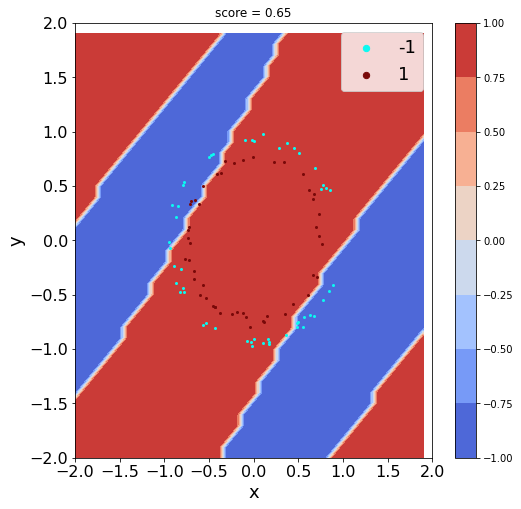

time :  263.91418385505676


In [23]:
q_fit(1, 1000)

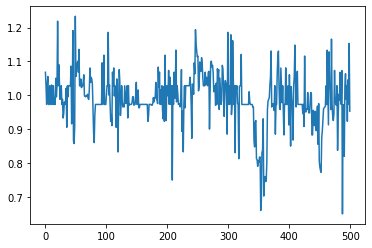

In [22]:
plt.plot([i for i in range(len(loss_list))], loss_list)

100%|██████████| 800/800 [00:00<00:00, 1719.81it/s]


loss: 0.9833804215003564


100%|██████████| 800/800 [00:00<00:00, 1742.58it/s]


loss: 1.0083840263447703


100%|██████████| 800/800 [00:00<00:00, 1745.88it/s]


loss: 1.118572984519537


100%|██████████| 800/800 [00:00<00:00, 1747.09it/s]


loss: 0.9935321806797427


100%|██████████| 800/800 [00:00<00:00, 1752.25it/s]


loss: 0.9936674708956005


100%|██████████| 800/800 [00:00<00:00, 1757.94it/s]


loss: 0.9933778771272752


100%|██████████| 800/800 [00:00<00:00, 1750.19it/s]


loss: 0.9936306781348938


100%|██████████| 800/800 [00:00<00:00, 1754.71it/s]


loss: 1.0084936825826516


100%|██████████| 800/800 [00:00<00:00, 1764.79it/s]


loss: 0.8832537134052836


100%|██████████| 800/800 [00:00<00:00, 1750.87it/s]


loss: 0.9934293194880254


100%|██████████| 800/800 [00:00<00:00, 1751.77it/s]


loss: 1.0082608143682024


100%|██████████| 800/800 [00:00<00:00, 1754.53it/s]


loss: 0.9933312976407951


100%|██████████| 800/800 [00:00<00:00, 1751.58it/s]


loss: 0.988440033685491


100%|██████████| 800/800 [00:00<00:00, 1761.61it/s]


loss: 1.0082565544217443


100%|██████████| 800/800 [00:00<00:00, 1768.29it/s]


loss: 0.9935623608924782


100%|██████████| 800/800 [00:00<00:00, 1762.05it/s]


loss: 0.973486620910592


100%|██████████| 800/800 [00:00<00:00, 1754.40it/s]


loss: 1.0658581097636886


100%|██████████| 800/800 [00:00<00:00, 1766.96it/s]


loss: 1.0085936737899015


100%|██████████| 800/800 [00:00<00:00, 1764.38it/s]


loss: 0.9934522141617986


100%|██████████| 800/800 [00:00<00:00, 1762.32it/s]


loss: 0.993497363535041


100%|██████████| 800/800 [00:00<00:00, 1759.95it/s]


loss: 1.1509902142142945


100%|██████████| 800/800 [00:00<00:00, 1756.65it/s]


loss: 1.0085791370696837


100%|██████████| 800/800 [00:00<00:00, 1763.96it/s]


loss: 1.03085872927016


100%|██████████| 800/800 [00:00<00:00, 1762.64it/s]


loss: 1.0082279663173532


100%|██████████| 800/800 [00:00<00:00, 1761.86it/s]


loss: 1.0286879560644735


100%|██████████| 800/800 [00:00<00:00, 1764.22it/s]


loss: 0.9032717066008394


100%|██████████| 800/800 [00:00<00:00, 1769.59it/s]


loss: 0.9510775344834247


100%|██████████| 800/800 [00:00<00:00, 1754.70it/s]


loss: 0.9935325580783765


100%|██████████| 800/800 [00:00<00:00, 1754.18it/s]


loss: 0.993096224887666


100%|██████████| 800/800 [00:00<00:00, 1750.04it/s]


loss: 1.0086893707209663


100%|██████████| 800/800 [00:00<00:00, 1756.69it/s]


loss: 0.993525439041092


100%|██████████| 800/800 [00:00<00:00, 1772.26it/s]


loss: 0.9933777704382476


100%|██████████| 800/800 [00:00<00:00, 1757.11it/s]


loss: 1.008257751987041


100%|██████████| 800/800 [00:00<00:00, 1763.78it/s]


loss: 1.008425366369038


100%|██████████| 800/800 [00:00<00:00, 1764.45it/s]


loss: 0.993391620837343


100%|██████████| 800/800 [00:00<00:00, 1757.52it/s]


loss: 1.1110053092000585


100%|██████████| 800/800 [00:00<00:00, 1752.70it/s]


loss: 1.1759073909174007


100%|██████████| 800/800 [00:00<00:00, 1753.05it/s]


loss: 1.040899872824468


100%|██████████| 800/800 [00:00<00:00, 1748.55it/s]


loss: 1.0084025023898593


100%|██████████| 800/800 [00:00<00:00, 1753.23it/s]


loss: 1.0834097108166556


100%|██████████| 800/800 [00:00<00:00, 1749.92it/s]


loss: 1.0932619941394166


100%|██████████| 800/800 [00:00<00:00, 1754.99it/s]


loss: 0.840845086175473


100%|██████████| 800/800 [00:00<00:00, 1757.68it/s]


loss: 0.9960318319664158


100%|██████████| 800/800 [00:00<00:00, 1750.89it/s]


loss: 1.1407988531742412


100%|██████████| 800/800 [00:00<00:00, 1757.62it/s]


loss: 0.6787147375325627


100%|██████████| 800/800 [00:00<00:00, 1755.09it/s]


loss: 1.021369771191045


100%|██████████| 800/800 [00:00<00:00, 1749.99it/s]


loss: 0.965780770438912


100%|██████████| 800/800 [00:00<00:00, 1729.61it/s]


loss: 0.958280770438912


100%|██████████| 800/800 [00:00<00:00, 1737.44it/s]


loss: 0.8732807704389121


100%|██████████| 800/800 [00:00<00:00, 1692.52it/s]


loss: 1.080780770438912


100%|██████████| 800/800 [00:00<00:00, 1733.20it/s]


loss: 1.078280770438912


100%|██████████| 800/800 [00:00<00:00, 1548.49it/s]


loss: 1.225780770438912


100%|██████████| 800/800 [00:00<00:00, 1473.20it/s]


loss: 1.225780770438912


100%|██████████| 800/800 [00:00<00:00, 1485.27it/s]


loss: 1.220780770438912


100%|██████████| 800/800 [00:00<00:00, 1498.71it/s]


loss: 0.943280770438912


100%|██████████| 800/800 [00:00<00:00, 1474.53it/s]


loss: 1.050780770438912


100%|██████████| 800/800 [00:00<00:00, 1508.19it/s]


loss: 1.220780770438912


100%|██████████| 800/800 [00:00<00:00, 1488.83it/s]


loss: 1.008280770438912


100%|██████████| 800/800 [00:00<00:00, 1478.35it/s]


loss: 1.008280770438912


100%|██████████| 800/800 [00:00<00:00, 1434.72it/s]


loss: 1.040780770438912


100%|██████████| 800/800 [00:00<00:00, 1496.41it/s]


loss: 1.093280770438912


100%|██████████| 800/800 [00:00<00:00, 1496.01it/s]


loss: 0.963280770438912


100%|██████████| 800/800 [00:00<00:00, 1482.44it/s]


loss: 1.020780770438912


100%|██████████| 800/800 [00:00<00:00, 1706.28it/s]


loss: 0.950780770438912


100%|██████████| 800/800 [00:00<00:00, 1706.74it/s]


loss: 1.008280770438912


100%|██████████| 800/800 [00:00<00:00, 1710.44it/s]


loss: 1.0082810297155913


100%|██████████| 800/800 [00:00<00:00, 1706.11it/s]


loss: 1.0083082528392628


100%|██████████| 800/800 [00:00<00:00, 1714.18it/s]


loss: 1.0083740181211955


100%|██████████| 800/800 [00:00<00:00, 1704.29it/s]


loss: 1.0083869404733794


100%|██████████| 800/800 [00:00<00:00, 1721.14it/s]


loss: 1.0084039160274518


100%|██████████| 800/800 [00:00<00:00, 1703.32it/s]


loss: 0.9934101435577097


100%|██████████| 800/800 [00:00<00:00, 1704.20it/s]


loss: 0.993437415292447


100%|██████████| 800/800 [00:00<00:00, 1707.02it/s]


loss: 0.9934055253934714


100%|██████████| 800/800 [00:00<00:00, 1699.25it/s]


loss: 0.9934137866845251


100%|██████████| 800/800 [00:00<00:00, 1706.64it/s]


loss: 0.9934587259482603


100%|██████████| 800/800 [00:00<00:00, 1710.16it/s]


loss: 0.9934035749789092


100%|██████████| 800/800 [00:00<00:00, 1696.62it/s]


loss: 0.9933834462882734


100%|██████████| 800/800 [00:00<00:00, 1703.40it/s]


loss: 0.9933760286807591


100%|██████████| 800/800 [00:00<00:00, 1693.24it/s]


loss: 0.9934322233713023


100%|██████████| 800/800 [00:00<00:00, 1714.12it/s]


loss: 0.9934381783394426


100%|██████████| 800/800 [00:00<00:00, 1712.60it/s]


loss: 0.9934419557906654


100%|██████████| 800/800 [00:00<00:00, 1711.69it/s]


loss: 0.9934325883799225


100%|██████████| 800/800 [00:00<00:00, 1711.13it/s]


loss: 0.9934247211167541


100%|██████████| 800/800 [00:00<00:00, 1705.78it/s]


loss: 0.9934849713484744


100%|██████████| 800/800 [00:00<00:00, 1693.74it/s]


loss: 0.993437700083525


100%|██████████| 800/800 [00:00<00:00, 1715.82it/s]


loss: 0.9933933869110225


100%|██████████| 800/800 [00:00<00:00, 1660.17it/s]


loss: 0.9933011016875424


100%|██████████| 800/800 [00:00<00:00, 1604.75it/s]


loss: 0.9932871329852931


100%|██████████| 800/800 [00:00<00:00, 1696.33it/s]


loss: 0.9932631110651978


100%|██████████| 800/800 [00:00<00:00, 1727.79it/s]


loss: 0.9932867397399928


100%|██████████| 800/800 [00:00<00:00, 1725.99it/s]


loss: 0.9933199045929489


100%|██████████| 800/800 [00:00<00:00, 1737.21it/s]


loss: 0.9933110577027039


100%|██████████| 800/800 [00:00<00:00, 1726.26it/s]


loss: 0.9933575827704272


100%|██████████| 800/800 [00:00<00:00, 1720.28it/s]


loss: 1.0334660086949135


100%|██████████| 800/800 [00:00<00:00, 1716.47it/s]


loss: 1.00805026345397


100%|██████████| 800/800 [00:00<00:00, 1732.89it/s]


loss: 1.0236322512842841


100%|██████████| 800/800 [00:00<00:00, 1707.12it/s]


loss: 0.955853379539231


100%|██████████| 800/800 [00:00<00:00, 1726.88it/s]


loss: 0.9906514747393717


100%|██████████| 800/800 [00:00<00:00, 1735.89it/s]


loss: 1.1260491771330652


100%|██████████| 800/800 [00:00<00:00, 1738.09it/s]


loss: 0.9933349406579024


100%|██████████| 800/800 [00:00<00:00, 1737.23it/s]


loss: 0.9933506232152364


100%|██████████| 800/800 [00:00<00:00, 1713.71it/s]


loss: 1.0634707428075971


100%|██████████| 800/800 [00:00<00:00, 1748.67it/s]


loss: 0.9939526348377994


100%|██████████| 800/800 [00:00<00:00, 1740.34it/s]


loss: 1.0535488373944883


100%|██████████| 800/800 [00:00<00:00, 1748.67it/s]


loss: 1.0082683262159142


100%|██████████| 800/800 [00:00<00:00, 1742.92it/s]


loss: 0.953652307752689


100%|██████████| 800/800 [00:00<00:00, 1743.16it/s]


loss: 0.9509518457661169


100%|██████████| 800/800 [00:00<00:00, 1730.11it/s]


loss: 0.9209346401161632


100%|██████████| 800/800 [00:00<00:00, 1735.21it/s]


loss: 1.008337526043587


100%|██████████| 800/800 [00:00<00:00, 1722.22it/s]


loss: 0.9934871908904205


100%|██████████| 800/800 [00:00<00:00, 1730.71it/s]


loss: 0.9609958878509385


100%|██████████| 800/800 [00:00<00:00, 1739.45it/s]


loss: 0.9933318187328422


100%|██████████| 800/800 [00:00<00:00, 1734.75it/s]


loss: 0.9583816318199601


100%|██████████| 800/800 [00:00<00:00, 1719.25it/s]


loss: 0.9434395935592851


100%|██████████| 800/800 [00:00<00:00, 1708.03it/s]


loss: 1.1158614490021699


100%|██████████| 800/800 [00:00<00:00, 1718.51it/s]


loss: 1.1308940354438042


100%|██████████| 800/800 [00:00<00:00, 1692.90it/s]


loss: 0.8681547422489588


100%|██████████| 800/800 [00:00<00:00, 1730.29it/s]


loss: 0.9934420484851597


100%|██████████| 800/800 [00:00<00:00, 1732.53it/s]


loss: 1.0835040542639003


100%|██████████| 800/800 [00:00<00:00, 1757.21it/s]


loss: 1.0683824902563404


100%|██████████| 800/800 [00:00<00:00, 1714.71it/s]


loss: 0.9936718079009613


100%|██████████| 800/800 [00:00<00:00, 1741.51it/s]


loss: 1.0087053759682676


100%|██████████| 800/800 [00:00<00:00, 1724.87it/s]


loss: 1.0183129128292252


100%|██████████| 800/800 [00:00<00:00, 1730.63it/s]


loss: 0.9935877452206449


100%|██████████| 800/800 [00:00<00:00, 1731.30it/s]


loss: 1.1708054276993232


100%|██████████| 800/800 [00:00<00:00, 1746.53it/s]


loss: 0.958530661635024


100%|██████████| 800/800 [00:00<00:00, 1733.88it/s]


loss: 0.9632545951452037


100%|██████████| 800/800 [00:00<00:00, 1719.65it/s]


loss: 0.9933139213332364


100%|██████████| 800/800 [00:00<00:00, 1755.13it/s]


loss: 1.008693714741762


100%|██████████| 800/800 [00:00<00:00, 1729.54it/s]


loss: 0.9936776736289402


100%|██████████| 800/800 [00:00<00:00, 1721.10it/s]


loss: 0.9932067691769099


100%|██████████| 800/800 [00:00<00:00, 1730.88it/s]


loss: 0.9934747496454396


100%|██████████| 800/800 [00:00<00:00, 1728.13it/s]


loss: 1.0331381792354961


100%|██████████| 800/800 [00:00<00:00, 1720.78it/s]


loss: 0.9708664931535645


100%|██████████| 800/800 [00:00<00:00, 1736.12it/s]


loss: 0.9936004706125813


100%|██████████| 800/800 [00:00<00:00, 1719.59it/s]


loss: 1.0159153731919548


100%|██████████| 800/800 [00:00<00:00, 1731.61it/s]


loss: 1.061104411169985


100%|██████████| 800/800 [00:00<00:00, 1724.77it/s]


loss: 0.993462912693088


100%|██████████| 800/800 [00:00<00:00, 1725.80it/s]


loss: 0.993340572474922


100%|██████████| 800/800 [00:00<00:00, 1751.33it/s]


loss: 0.918340572474922


100%|██████████| 800/800 [00:00<00:00, 1728.48it/s]


loss: 0.993340572474922


100%|██████████| 800/800 [00:00<00:00, 1737.89it/s]


loss: 0.993340572474922


100%|██████████| 800/800 [00:00<00:00, 1717.33it/s]


loss: 0.993340572474922


100%|██████████| 800/800 [00:00<00:00, 1728.54it/s]


loss: 0.993340572474922


100%|██████████| 800/800 [00:00<00:00, 1721.70it/s]


loss: 0.993340572474922


100%|██████████| 800/800 [00:00<00:00, 1730.13it/s]


loss: 0.993340572474922


100%|██████████| 800/800 [00:00<00:00, 1732.27it/s]


loss: 0.973340572474922


100%|██████████| 800/800 [00:00<00:00, 1739.99it/s]


loss: 0.980840572474922


100%|██████████| 800/800 [00:00<00:00, 1718.84it/s]


loss: 1.090840572474922


100%|██████████| 800/800 [00:00<00:00, 1724.71it/s]


loss: 0.993340572474922


100%|██████████| 800/800 [00:00<00:00, 1739.62it/s]


loss: 0.9658405724749219


100%|██████████| 800/800 [00:00<00:00, 1727.50it/s]


loss: 1.0983405724749218


100%|██████████| 800/800 [00:00<00:00, 1724.96it/s]


loss: 0.998340572474922


100%|██████████| 800/800 [00:00<00:00, 1719.82it/s]


loss: 0.998340572474922


100%|██████████| 800/800 [00:00<00:00, 1722.90it/s]


loss: 0.993340572474922


100%|██████████| 800/800 [00:00<00:00, 1738.79it/s]


loss: 1.0208405724749219


100%|██████████| 800/800 [00:00<00:00, 1737.67it/s]


loss: 0.865840572474922


100%|██████████| 800/800 [00:00<00:00, 1765.63it/s]


loss: 0.8633478644591389


100%|██████████| 800/800 [00:00<00:00, 1740.76it/s]


loss: 0.8283077861536933


100%|██████████| 800/800 [00:00<00:00, 1750.10it/s]


loss: 0.7933835173633008


100%|██████████| 800/800 [00:00<00:00, 1742.09it/s]


loss: 0.9009118233722768


100%|██████████| 800/800 [00:00<00:00, 1741.77it/s]


loss: 0.8883851502460833


100%|██████████| 800/800 [00:00<00:00, 1750.09it/s]


loss: 0.8809015388993225


100%|██████████| 800/800 [00:00<00:00, 1758.59it/s]


loss: 0.9558073700049728


100%|██████████| 800/800 [00:00<00:00, 1770.46it/s]


loss: 1.0083389487996788


100%|██████████| 800/800 [00:00<00:00, 1763.77it/s]


loss: 0.993413397185006


100%|██████████| 800/800 [00:00<00:00, 1762.74it/s]


loss: 1.0184889118786287


100%|██████████| 800/800 [00:00<00:00, 1744.25it/s]


loss: 1.0184252294946268


100%|██████████| 800/800 [00:00<00:00, 1751.00it/s]


loss: 1.018502363729486


100%|██████████| 800/800 [00:00<00:00, 1725.89it/s]


loss: 0.8434915280402852


100%|██████████| 800/800 [00:00<00:00, 1753.87it/s]


loss: 0.8659733891584507


100%|██████████| 800/800 [00:00<00:00, 1757.12it/s]


loss: 0.9660251846744414


100%|██████████| 800/800 [00:00<00:00, 1758.12it/s]


loss: 0.9935268727879342


100%|██████████| 800/800 [00:00<00:00, 1766.51it/s]


loss: 1.1610162499824677


100%|██████████| 800/800 [00:00<00:00, 1759.70it/s]


loss: 1.1360288377281806


100%|██████████| 800/800 [00:00<00:00, 1752.48it/s]


loss: 1.151027226607273


100%|██████████| 800/800 [00:00<00:00, 1763.42it/s]


loss: 1.2685388793033865


100%|██████████| 800/800 [00:00<00:00, 1761.51it/s]


loss: 1.2735737534964242


100%|██████████| 800/800 [00:00<00:00, 1740.71it/s]


loss: 1.271028240635883


100%|██████████| 800/800 [00:00<00:00, 1727.67it/s]


loss: 1.2609839363853685


100%|██████████| 800/800 [00:00<00:00, 1747.09it/s]


loss: 1.1833904888210038


100%|██████████| 800/800 [00:00<00:00, 1747.82it/s]


loss: 1.1983991693161375


100%|██████████| 800/800 [00:00<00:00, 1744.62it/s]


loss: 1.1934102314287174


100%|██████████| 800/800 [00:00<00:00, 1742.64it/s]


loss: 1.2033749123273791


100%|██████████| 800/800 [00:00<00:00, 1755.41it/s]


loss: 1.2159432964901664


100%|██████████| 800/800 [00:00<00:00, 1760.48it/s]


loss: 1.1211248422170559


100%|██████████| 800/800 [00:00<00:00, 1756.09it/s]


loss: 1.0086826114682108


100%|██████████| 800/800 [00:00<00:00, 1735.40it/s]


loss: 1.0087270883821793


100%|██████████| 800/800 [00:00<00:00, 1735.07it/s]


loss: 0.8434656174040734


100%|██████████| 800/800 [00:00<00:00, 1755.83it/s]


loss: 0.9135033746271886


100%|██████████| 800/800 [00:00<00:00, 1775.68it/s]


loss: 1.030887415752137


100%|██████████| 800/800 [00:00<00:00, 1765.45it/s]


loss: 0.9934313990180009


100%|██████████| 800/800 [00:00<00:00, 1744.79it/s]


loss: 0.9932898013050806


100%|██████████| 800/800 [00:00<00:00, 1755.80it/s]


loss: 1.1083310291559494


100%|██████████| 800/800 [00:00<00:00, 1758.59it/s]


loss: 0.8707849139138424


100%|██████████| 800/800 [00:00<00:00, 1730.76it/s]


loss: 0.9859919414728868


100%|██████████| 800/800 [00:00<00:00, 1735.89it/s]


loss: 0.9935973706086147


100%|██████████| 800/800 [00:00<00:00, 1750.24it/s]


loss: 0.9409958299385558


100%|██████████| 800/800 [00:00<00:00, 1742.22it/s]


loss: 0.993446831235814


100%|██████████| 800/800 [00:00<00:00, 1766.73it/s]


loss: 0.8608933158207647


100%|██████████| 800/800 [00:00<00:00, 1767.33it/s]


loss: 1.0082680513034874


100%|██████████| 800/800 [00:00<00:00, 1756.68it/s]


loss: 0.9460023351903477


100%|██████████| 800/800 [00:00<00:00, 1751.51it/s]


loss: 1.0360439269427404


100%|██████████| 800/800 [00:00<00:00, 1735.20it/s]


loss: 1.2008366478615435


100%|██████████| 800/800 [00:00<00:00, 1740.39it/s]


loss: 1.0786759211830017


100%|██████████| 800/800 [00:00<00:00, 1760.10it/s]


loss: 1.0458800605882488


100%|██████████| 800/800 [00:00<00:00, 1752.60it/s]


loss: 1.0462859840579184


100%|██████████| 800/800 [00:00<00:00, 1760.19it/s]


loss: 1.016121941932165


100%|██████████| 800/800 [00:00<00:00, 1735.95it/s]


loss: 0.9883773422098262


100%|██████████| 800/800 [00:00<00:00, 1759.56it/s]


loss: 0.9811045453902286


100%|██████████| 800/800 [00:00<00:00, 1746.40it/s]


loss: 1.093487912023299


100%|██████████| 800/800 [00:00<00:00, 1756.61it/s]


loss: 1.0085145903749855


100%|██████████| 800/800 [00:00<00:00, 1743.10it/s]


loss: 0.9483245464192757


100%|██████████| 800/800 [00:00<00:00, 1747.44it/s]


loss: 0.958366696005681


100%|██████████| 800/800 [00:00<00:00, 1744.62it/s]


loss: 1.0086632316774498


100%|██████████| 800/800 [00:00<00:00, 1754.90it/s]


loss: 0.9936095119376801


100%|██████████| 800/800 [00:00<00:00, 1752.84it/s]


loss: 1.1057338888535815


100%|██████████| 800/800 [00:00<00:00, 1760.34it/s]


loss: 1.0433911872386403


100%|██████████| 800/800 [00:00<00:00, 1624.06it/s]


loss: 1.013635575911927


100%|██████████| 800/800 [00:00<00:00, 1718.80it/s]


loss: 0.9382982835470357


100%|██████████| 800/800 [00:00<00:00, 1728.16it/s]


loss: 0.9934630735816212


100%|██████████| 800/800 [00:00<00:00, 1716.89it/s]


loss: 0.9409725288199914


100%|██████████| 800/800 [00:00<00:00, 1735.00it/s]


loss: 1.0085232161852238


100%|██████████| 800/800 [00:00<00:00, 1743.15it/s]


loss: 0.9936825668642951


100%|██████████| 800/800 [00:00<00:00, 1723.57it/s]


loss: 1.0083446505919378


100%|██████████| 800/800 [00:00<00:00, 1730.86it/s]


loss: 0.6832544845888014


100%|██████████| 800/800 [00:00<00:00, 1733.69it/s]


loss: 0.8558829673359407


100%|██████████| 800/800 [00:00<00:00, 1721.74it/s]


loss: 1.0085894875074761


100%|██████████| 800/800 [00:00<00:00, 1727.92it/s]


loss: 1.0458773374828791


100%|██████████| 800/800 [00:00<00:00, 1729.38it/s]


loss: 0.833357116769403


100%|██████████| 800/800 [00:00<00:00, 1730.56it/s]


loss: 1.1832517617051896


100%|██████████| 800/800 [00:00<00:00, 1719.30it/s]


loss: 1.1532517617051896


100%|██████████| 800/800 [00:00<00:00, 1731.03it/s]


loss: 1.0532517617051895


100%|██████████| 800/800 [00:00<00:00, 1720.10it/s]


loss: 1.0732517617051895


100%|██████████| 800/800 [00:00<00:00, 1726.84it/s]


loss: 0.7732517617051894


100%|██████████| 800/800 [00:00<00:00, 1705.75it/s]


loss: 0.9457517617051894


100%|██████████| 800/800 [00:00<00:00, 1707.62it/s]


loss: 0.9457517617051894


100%|██████████| 800/800 [00:00<00:00, 1716.48it/s]


loss: 0.9457517617051894


100%|██████████| 800/800 [00:00<00:00, 1723.05it/s]


loss: 0.9557517617051894


100%|██████████| 800/800 [00:00<00:00, 1725.60it/s]


loss: 0.9707517617051894


100%|██████████| 800/800 [00:00<00:00, 1708.08it/s]


loss: 1.0482517617051896


100%|██████████| 800/800 [00:00<00:00, 1702.88it/s]


loss: 1.0082517617051896


100%|██████████| 800/800 [00:00<00:00, 1727.67it/s]


loss: 1.0082517617051896


100%|██████████| 800/800 [00:00<00:00, 1725.98it/s]


loss: 1.0082517617051896


100%|██████████| 800/800 [00:00<00:00, 1726.40it/s]


loss: 0.9932517617051895


100%|██████████| 800/800 [00:00<00:00, 1708.15it/s]


loss: 0.6782517617051894


100%|██████████| 800/800 [00:00<00:00, 1722.64it/s]


loss: 0.8082517617051894


100%|██████████| 800/800 [00:00<00:00, 1723.97it/s]


loss: 0.7607517617051894


100%|██████████| 800/800 [00:00<00:00, 1716.84it/s]


loss: 0.9857517617051894


100%|██████████| 800/800 [00:00<00:00, 1716.40it/s]


loss: 0.9683158727626423


100%|██████████| 800/800 [00:00<00:00, 1699.28it/s]


loss: 0.9758825106026053


100%|██████████| 800/800 [00:00<00:00, 1723.85it/s]


loss: 0.9909636439796321


100%|██████████| 800/800 [00:00<00:00, 1720.64it/s]


loss: 0.9934751415486089


100%|██████████| 800/800 [00:00<00:00, 1720.35it/s]


loss: 0.9934843642808322


100%|██████████| 800/800 [00:00<00:00, 1714.44it/s]


loss: 0.9934746754587459


100%|██████████| 800/800 [00:00<00:00, 1711.10it/s]


loss: 0.993562061096406


100%|██████████| 800/800 [00:00<00:00, 1711.68it/s]


loss: 0.9935429200370598


100%|██████████| 800/800 [00:00<00:00, 1729.93it/s]


loss: 0.9935452029551315


100%|██████████| 800/800 [00:00<00:00, 1720.23it/s]


loss: 0.9786241926921009


100%|██████████| 800/800 [00:00<00:00, 1724.87it/s]


loss: 0.9810655401924985


100%|██████████| 800/800 [00:00<00:00, 1713.09it/s]


loss: 0.971070321340744


100%|██████████| 800/800 [00:00<00:00, 1717.18it/s]


loss: 0.9760716664962484


100%|██████████| 800/800 [00:00<00:00, 1706.83it/s]


loss: 0.983550692055506


100%|██████████| 800/800 [00:00<00:00, 1707.50it/s]


loss: 0.9885467485515962


100%|██████████| 800/800 [00:00<00:00, 1724.69it/s]


loss: 0.9835283802927702


100%|██████████| 800/800 [00:00<00:00, 1714.76it/s]


loss: 1.0010674580788386


100%|██████████| 800/800 [00:00<00:00, 1705.13it/s]


loss: 1.0585281005813618


100%|██████████| 800/800 [00:00<00:00, 1716.83it/s]


loss: 1.0310438217669413


100%|██████████| 800/800 [00:00<00:00, 1701.53it/s]


loss: 0.9960480300480427


100%|██████████| 800/800 [00:00<00:00, 1719.28it/s]


loss: 0.9910287728785515


100%|██████████| 800/800 [00:00<00:00, 1720.79it/s]


loss: 0.9585323600144059


100%|██████████| 800/800 [00:00<00:00, 1716.33it/s]


loss: 0.8911151578832763


100%|██████████| 800/800 [00:00<00:00, 1708.66it/s]


loss: 0.8535777752245991


100%|██████████| 800/800 [00:00<00:00, 1715.48it/s]


loss: 0.8635849103424506


100%|██████████| 800/800 [00:00<00:00, 1713.84it/s]


loss: 0.8960999945971028


100%|██████████| 800/800 [00:00<00:00, 1713.66it/s]


loss: 0.9011094831450027


100%|██████████| 800/800 [00:00<00:00, 1724.29it/s]


loss: 0.901084430944754


100%|██████████| 800/800 [00:00<00:00, 1723.23it/s]


loss: 0.9860101015349294


100%|██████████| 800/800 [00:00<00:00, 1717.67it/s]


loss: 0.9258827583919024


100%|██████████| 800/800 [00:00<00:00, 1726.21it/s]


loss: 0.9184974015399315


100%|██████████| 800/800 [00:00<00:00, 1727.00it/s]


loss: 1.0059574692251967


100%|██████████| 800/800 [00:00<00:00, 1715.85it/s]


loss: 0.9584617994314257


100%|██████████| 800/800 [00:00<00:00, 1715.70it/s]


loss: 1.0085535014812996


100%|██████████| 800/800 [00:00<00:00, 1706.18it/s]


loss: 1.0810607199042253


100%|██████████| 800/800 [00:00<00:00, 1713.83it/s]


loss: 0.9933588948715623


100%|██████████| 800/800 [00:00<00:00, 1702.18it/s]


loss: 1.0082295032491244


100%|██████████| 800/800 [00:00<00:00, 1725.95it/s]


loss: 1.0084550141200272


100%|██████████| 800/800 [00:00<00:00, 1732.78it/s]


loss: 0.9932615739714215


100%|██████████| 800/800 [00:00<00:00, 1696.89it/s]


loss: 0.9386012881059116


100%|██████████| 800/800 [00:00<00:00, 1718.53it/s]


loss: 1.010902174794265


100%|██████████| 800/800 [00:00<00:00, 1706.47it/s]


loss: 0.9908516635076702


100%|██████████| 800/800 [00:00<00:00, 1729.20it/s]


loss: 1.0283961051108785


100%|██████████| 800/800 [00:00<00:00, 1719.21it/s]


loss: 1.0083933902022355


100%|██████████| 800/800 [00:00<00:00, 1691.78it/s]


loss: 1.1509741090755323


100%|██████████| 800/800 [00:00<00:00, 1704.83it/s]


loss: 0.9911223462172348


100%|██████████| 800/800 [00:00<00:00, 1709.34it/s]


loss: 0.9934598958056547


100%|██████████| 800/800 [00:00<00:00, 1718.18it/s]


loss: 0.9582175569424407


100%|██████████| 800/800 [00:00<00:00, 1712.10it/s]


loss: 0.9934264179483853


100%|██████████| 800/800 [00:00<00:00, 1706.94it/s]


loss: 0.8809392822500105


100%|██████████| 800/800 [00:00<00:00, 1710.13it/s]


loss: 1.0084147128666778


100%|██████████| 800/800 [00:00<00:00, 1702.37it/s]


loss: 1.0086036198575048


100%|██████████| 800/800 [00:00<00:00, 1716.55it/s]


loss: 0.9583544686816323


100%|██████████| 800/800 [00:00<00:00, 1715.45it/s]


loss: 0.9933902843155007


100%|██████████| 800/800 [00:00<00:00, 1692.98it/s]


loss: 1.008297985708574


100%|██████████| 800/800 [00:00<00:00, 1707.29it/s]


loss: 0.9732909934959754


100%|██████████| 800/800 [00:00<00:00, 1672.76it/s]


loss: 1.0085592839542836


100%|██████████| 800/800 [00:00<00:00, 1685.30it/s]


loss: 1.0105724875986863


100%|██████████| 800/800 [00:00<00:00, 1706.54it/s]


loss: 1.0259153374371288


100%|██████████| 800/800 [00:00<00:00, 1673.10it/s]


loss: 0.958018468649681


100%|██████████| 800/800 [00:00<00:00, 1721.51it/s]


loss: 1.008541807687072


100%|██████████| 800/800 [00:00<00:00, 1722.62it/s]


loss: 0.9059857298429106


100%|██████████| 800/800 [00:00<00:00, 1718.12it/s]


loss: 0.9934025952571419


100%|██████████| 800/800 [00:00<00:00, 1509.76it/s]


loss: 1.008352094729603


100%|██████████| 800/800 [00:00<00:00, 1408.38it/s]


loss: 0.9934808828816217


100%|██████████| 800/800 [00:00<00:00, 1393.73it/s]


loss: 1.008333776834046


100%|██████████| 800/800 [00:00<00:00, 1395.68it/s]


loss: 0.9934760511100018


100%|██████████| 800/800 [00:00<00:00, 1456.07it/s]


loss: 1.0434873266516274


100%|██████████| 800/800 [00:00<00:00, 1402.51it/s]


loss: 1.0083564671295526


100%|██████████| 800/800 [00:00<00:00, 1408.19it/s]


loss: 1.1833578455961853


100%|██████████| 800/800 [00:00<00:00, 1387.81it/s]


loss: 1.0082881421944232


100%|██████████| 800/800 [00:00<00:00, 1431.74it/s]


loss: 1.0184339859599858


100%|██████████| 800/800 [00:00<00:00, 1429.95it/s]


loss: 1.008435266604028


100%|██████████| 800/800 [00:00<00:00, 1428.11it/s]


loss: 1.0082313487987262


100%|██████████| 800/800 [00:00<00:00, 1425.72it/s]


loss: 1.0082313487987262


100%|██████████| 800/800 [00:00<00:00, 1426.80it/s]


loss: 1.0082313487987262


100%|██████████| 800/800 [00:00<00:00, 1434.53it/s]


loss: 1.0082313487987262


100%|██████████| 800/800 [00:00<00:00, 1448.46it/s]


loss: 0.8832313487987262


100%|██████████| 800/800 [00:00<00:00, 1443.53it/s]


loss: 0.9407313487987262


100%|██████████| 800/800 [00:00<00:00, 1434.92it/s]


loss: 0.9407313487987262


100%|██████████| 800/800 [00:00<00:00, 1428.44it/s]


loss: 0.9932313487987263


100%|██████████| 800/800 [00:00<00:00, 1458.99it/s]


loss: 0.9832313487987263


100%|██████████| 800/800 [00:00<00:00, 1420.00it/s]


loss: 1.015731348798726


100%|██████████| 800/800 [00:00<00:00, 1445.63it/s]


loss: 1.0607313487987262


100%|██████████| 800/800 [00:00<00:00, 1444.08it/s]


loss: 0.9657313487987262


100%|██████████| 800/800 [00:00<00:00, 1464.56it/s]


loss: 1.0907313487987262


100%|██████████| 800/800 [00:00<00:00, 1471.23it/s]


loss: 1.0207313487987262


100%|██████████| 800/800 [00:00<00:00, 1436.24it/s]


loss: 1.0107313487987262


100%|██████████| 800/800 [00:00<00:00, 1378.15it/s]


loss: 1.0132313487987261


100%|██████████| 800/800 [00:00<00:00, 1447.06it/s]


loss: 1.0232313487987261


100%|██████████| 800/800 [00:00<00:00, 1423.01it/s]


loss: 1.0307313487987262


100%|██████████| 800/800 [00:00<00:00, 1373.37it/s]


loss: 1.045731348798726


100%|██████████| 800/800 [00:00<00:00, 1433.03it/s]


loss: 1.0457874903645095


100%|██████████| 800/800 [00:00<00:00, 1433.34it/s]


loss: 1.0557702978844348


100%|██████████| 800/800 [00:00<00:00, 1468.43it/s]


loss: 1.0457368647452023


100%|██████████| 800/800 [00:00<00:00, 1440.77it/s]


loss: 1.0507348780823034


100%|██████████| 800/800 [00:00<00:00, 1471.47it/s]


loss: 1.0083323402436617


100%|██████████| 800/800 [00:00<00:00, 1412.55it/s]


loss: 1.0083779169575497


100%|██████████| 800/800 [00:00<00:00, 1685.72it/s]


loss: 1.0083121152264702


100%|██████████| 800/800 [00:00<00:00, 1652.67it/s]


loss: 1.0083126436418104


100%|██████████| 800/800 [00:00<00:00, 1696.76it/s]


loss: 1.0083456766058543


100%|██████████| 800/800 [00:00<00:00, 1691.43it/s]


loss: 1.0083125964029456


100%|██████████| 800/800 [00:00<00:00, 1663.56it/s]


loss: 1.0083474087256876


100%|██████████| 800/800 [00:00<00:00, 1726.38it/s]


loss: 1.0083677100897876


100%|██████████| 800/800 [00:00<00:00, 1722.12it/s]


loss: 1.0084469718276767


100%|██████████| 800/800 [00:00<00:00, 1713.25it/s]


loss: 1.0084456433362736


100%|██████████| 800/800 [00:00<00:00, 1738.38it/s]


loss: 1.0083759688767506


100%|██████████| 800/800 [00:00<00:00, 1717.57it/s]


loss: 1.0083928429797264


100%|██████████| 800/800 [00:00<00:00, 1726.94it/s]


loss: 1.0083930210278478


100%|██████████| 800/800 [00:00<00:00, 1712.35it/s]


loss: 1.0084355127843656


100%|██████████| 800/800 [00:00<00:00, 1734.35it/s]


loss: 1.0309491025285267


100%|██████████| 800/800 [00:00<00:00, 1697.06it/s]


loss: 1.00843837534315


100%|██████████| 800/800 [00:00<00:00, 1715.89it/s]


loss: 1.0434186406046309


100%|██████████| 800/800 [00:00<00:00, 1701.05it/s]


loss: 1.0484524914827857


100%|██████████| 800/800 [00:00<00:00, 1722.87it/s]


loss: 1.0085469499839201


100%|██████████| 800/800 [00:00<00:00, 1738.81it/s]


loss: 1.0085387379096027


100%|██████████| 800/800 [00:00<00:00, 1685.51it/s]


loss: 1.056013431413367


100%|██████████| 800/800 [00:00<00:00, 1689.65it/s]


loss: 1.0409867312547374


100%|██████████| 800/800 [00:00<00:00, 1722.33it/s]


loss: 1.0309543981341582


100%|██████████| 800/800 [00:00<00:00, 1703.53it/s]


loss: 1.0309577374418555


100%|██████████| 800/800 [00:00<00:00, 1723.99it/s]


loss: 1.0084127390686175


100%|██████████| 800/800 [00:00<00:00, 1741.83it/s]


loss: 0.9933971925579069


100%|██████████| 800/800 [00:00<00:00, 1727.30it/s]


loss: 0.9933430228986068


100%|██████████| 800/800 [00:00<00:00, 1729.88it/s]


loss: 0.9936372435759583


100%|██████████| 800/800 [00:00<00:00, 1740.01it/s]


loss: 0.9862486260060168


100%|██████████| 800/800 [00:00<00:00, 1724.49it/s]


loss: 1.035879719643672


100%|██████████| 800/800 [00:00<00:00, 1727.97it/s]


loss: 1.1759020813987462


100%|██████████| 800/800 [00:00<00:00, 1711.01it/s]


loss: 1.0081711783107834


100%|██████████| 800/800 [00:00<00:00, 1697.46it/s]


loss: 1.0112369195214066


100%|██████████| 800/800 [00:00<00:00, 1694.57it/s]


loss: 0.9933673572961105


100%|██████████| 800/800 [00:00<00:00, 1718.87it/s]


loss: 1.0085634010009752


100%|██████████| 800/800 [00:00<00:00, 1746.07it/s]


loss: 1.1261773035300773


100%|██████████| 800/800 [00:00<00:00, 1723.27it/s]


loss: 1.0534143684567674


100%|██████████| 800/800 [00:00<00:00, 1741.26it/s]


loss: 1.1059347703860565


100%|██████████| 800/800 [00:00<00:00, 1737.23it/s]


loss: 0.9284036901327855


100%|██████████| 800/800 [00:00<00:00, 1726.72it/s]


loss: 0.9959207481754164


100%|██████████| 800/800 [00:00<00:00, 1746.24it/s]


loss: 0.9483910484406626


100%|██████████| 800/800 [00:00<00:00, 1741.55it/s]


loss: 1.0084630427344885


100%|██████████| 800/800 [00:00<00:00, 1741.97it/s]


loss: 0.9933839381615552


100%|██████████| 800/800 [00:00<00:00, 1706.72it/s]


loss: 1.0086946074256145


100%|██████████| 800/800 [00:00<00:00, 1743.07it/s]


loss: 0.850818327670626


100%|██████████| 800/800 [00:00<00:00, 1711.88it/s]


loss: 1.0086609583611084


100%|██████████| 800/800 [00:00<00:00, 1707.92it/s]


loss: 0.9934372303385262


100%|██████████| 800/800 [00:00<00:00, 1715.88it/s]


loss: 1.0134469168275673


100%|██████████| 800/800 [00:00<00:00, 1719.82it/s]


loss: 0.8982504127798443


100%|██████████| 800/800 [00:00<00:00, 1702.05it/s]


loss: 0.9957854346909611


100%|██████████| 800/800 [00:00<00:00, 1728.99it/s]


loss: 1.0609340791228583


100%|██████████| 800/800 [00:00<00:00, 1730.30it/s]


loss: 1.048224746072207


100%|██████████| 800/800 [00:00<00:00, 1718.47it/s]


loss: 1.1608558093897983


100%|██████████| 800/800 [00:00<00:00, 1725.08it/s]


loss: 0.9934576716684769


100%|██████████| 800/800 [00:00<00:00, 1747.02it/s]


loss: 0.9258643296429052


100%|██████████| 800/800 [00:00<00:00, 1741.46it/s]


loss: 1.0835132398374343


100%|██████████| 800/800 [00:00<00:00, 1711.55it/s]


loss: 0.9933342546610329


100%|██████████| 800/800 [00:00<00:00, 1718.13it/s]


loss: 0.9683405665923488


100%|██████████| 800/800 [00:00<00:00, 1721.97it/s]


loss: 1.1084456909357623


100%|██████████| 800/800 [00:00<00:00, 1708.50it/s]


loss: 0.9932754703811175


100%|██████████| 800/800 [00:00<00:00, 1706.05it/s]


loss: 1.0083066662636757


100%|██████████| 800/800 [00:00<00:00, 1726.87it/s]


loss: 1.0079974889984036


100%|██████████| 800/800 [00:00<00:00, 1715.64it/s]


loss: 1.0085865712210065


100%|██████████| 800/800 [00:00<00:00, 1718.34it/s]


loss: 1.033438139193784


100%|██████████| 800/800 [00:00<00:00, 1701.89it/s]


loss: 0.9636456774370827


100%|██████████| 800/800 [00:00<00:00, 1729.23it/s]


loss: 1.008456039691441


100%|██████████| 800/800 [00:00<00:00, 1716.41it/s]


loss: 1.008412627972679


100%|██████████| 800/800 [00:00<00:00, 1711.75it/s]


loss: 0.9931435335023446


100%|██████████| 800/800 [00:00<00:00, 1707.64it/s]


loss: 1.00826477426317


100%|██████████| 800/800 [00:00<00:00, 1717.79it/s]


loss: 1.0085826512606764


100%|██████████| 800/800 [00:00<00:00, 1726.41it/s]


loss: 1.0960826512606763


100%|██████████| 800/800 [00:00<00:00, 1715.69it/s]


loss: 1.0735826512606763


100%|██████████| 800/800 [00:00<00:00, 1724.57it/s]


loss: 1.0510826512606763


100%|██████████| 800/800 [00:00<00:00, 1731.31it/s]


loss: 1.0085826512606764


100%|██████████| 800/800 [00:00<00:00, 1726.06it/s]


loss: 1.0135826512606763


100%|██████████| 800/800 [00:00<00:00, 1710.96it/s]


loss: 1.0135826512606763


100%|██████████| 800/800 [00:00<00:00, 1724.22it/s]


loss: 1.0085826512606764


100%|██████████| 800/800 [00:00<00:00, 1725.14it/s]


loss: 0.9985826512606765


100%|██████████| 800/800 [00:00<00:00, 1740.22it/s]


loss: 1.0085826512606764


100%|██████████| 800/800 [00:00<00:00, 1716.54it/s]


loss: 1.0085826512606764


100%|██████████| 800/800 [00:00<00:00, 1726.89it/s]


loss: 1.0085826512606764


100%|██████████| 800/800 [00:00<00:00, 1698.67it/s]


loss: 1.1160826512606763


100%|██████████| 800/800 [00:00<00:00, 1728.31it/s]


loss: 1.0260826512606762


100%|██████████| 800/800 [00:00<00:00, 1723.32it/s]


loss: 1.0085826512606764


100%|██████████| 800/800 [00:00<00:00, 1715.48it/s]


loss: 1.0085826512606764


100%|██████████| 800/800 [00:00<00:00, 1730.24it/s]


loss: 1.0085826512606764


100%|██████████| 800/800 [00:00<00:00, 1718.64it/s]


loss: 0.9960826512606764


100%|██████████| 800/800 [00:00<00:00, 1718.46it/s]


loss: 0.9960826512606764


100%|██████████| 800/800 [00:00<00:00, 1713.11it/s]


loss: 0.9960220196543749


100%|██████████| 800/800 [00:00<00:00, 1709.91it/s]


loss: 0.9960558091553455


100%|██████████| 800/800 [00:00<00:00, 1724.57it/s]


loss: 0.996047915237019


100%|██████████| 800/800 [00:00<00:00, 1712.87it/s]


loss: 0.9960166552257217


100%|██████████| 800/800 [00:00<00:00, 1706.08it/s]


loss: 0.998514713712024


100%|██████████| 800/800 [00:00<00:00, 1709.70it/s]


loss: 1.000977521187445


100%|██████████| 800/800 [00:00<00:00, 1706.84it/s]


loss: 0.9984604357439621


100%|██████████| 800/800 [00:00<00:00, 1723.56it/s]


loss: 0.9985551912120132


100%|██████████| 800/800 [00:00<00:00, 1705.51it/s]


loss: 0.9985918074054793


100%|██████████| 800/800 [00:00<00:00, 1716.16it/s]


loss: 0.9886195546015696


100%|██████████| 800/800 [00:00<00:00, 1715.71it/s]


loss: 0.9911457429684897


100%|██████████| 800/800 [00:00<00:00, 1720.79it/s]


loss: 0.9886251907689984


100%|██████████| 800/800 [00:00<00:00, 1707.12it/s]


loss: 0.9911213238438275


100%|██████████| 800/800 [00:00<00:00, 1727.10it/s]


loss: 1.006042896256478


100%|██████████| 800/800 [00:00<00:00, 1742.10it/s]


loss: 1.0110281945634574


100%|██████████| 800/800 [00:00<00:00, 1721.37it/s]


loss: 1.011090998724543


100%|██████████| 800/800 [00:00<00:00, 1713.89it/s]


loss: 1.0136241016970045


100%|██████████| 800/800 [00:00<00:00, 1718.10it/s]


loss: 1.0060927325886375


100%|██████████| 800/800 [00:00<00:00, 1720.49it/s]


loss: 0.9960069943980681


100%|██████████| 800/800 [00:00<00:00, 1712.60it/s]


loss: 0.9734559061436108


100%|██████████| 800/800 [00:00<00:00, 1718.37it/s]


loss: 1.0008841352501097


100%|██████████| 800/800 [00:00<00:00, 1720.99it/s]


loss: 1.0008577953990838


100%|██████████| 800/800 [00:00<00:00, 1733.41it/s]


loss: 1.000868361036963


100%|██████████| 800/800 [00:00<00:00, 1708.97it/s]


loss: 1.0008037867447448


100%|██████████| 800/800 [00:00<00:00, 1715.60it/s]


loss: 1.0007616107049322


100%|██████████| 800/800 [00:00<00:00, 1721.17it/s]


loss: 1.0007975366483548


100%|██████████| 800/800 [00:00<00:00, 1743.46it/s]


loss: 0.9983344708252971


100%|██████████| 800/800 [00:00<00:00, 1732.73it/s]


loss: 1.008374936557873


100%|██████████| 800/800 [00:00<00:00, 1706.98it/s]


loss: 0.9605706193092622


100%|██████████| 800/800 [00:00<00:00, 1724.29it/s]


loss: 1.031056711729617


100%|██████████| 800/800 [00:00<00:00, 1711.28it/s]


loss: 1.0084254949081408


100%|██████████| 800/800 [00:00<00:00, 1729.80it/s]


loss: 1.0085479523751857


100%|██████████| 800/800 [00:00<00:00, 1722.89it/s]


loss: 0.875884859329498


100%|██████████| 800/800 [00:00<00:00, 1730.49it/s]


loss: 0.9684116700732062


100%|██████████| 800/800 [00:00<00:00, 1695.79it/s]


loss: 1.056100600078806


100%|██████████| 800/800 [00:00<00:00, 1747.36it/s]


loss: 1.008226065019036


100%|██████████| 800/800 [00:00<00:00, 1714.65it/s]


loss: 1.008482214404812


100%|██████████| 800/800 [00:00<00:00, 1710.64it/s]


loss: 0.9982265359356765


100%|██████████| 800/800 [00:00<00:00, 1714.80it/s]


loss: 1.068507557350374


100%|██████████| 800/800 [00:00<00:00, 1715.22it/s]


loss: 1.0283051446671365


100%|██████████| 800/800 [00:00<00:00, 1711.31it/s]


loss: 0.9933936803810741


100%|██████████| 800/800 [00:00<00:00, 1720.49it/s]


loss: 0.9708615105769879


100%|██████████| 800/800 [00:00<00:00, 1731.29it/s]


loss: 1.005805935806767


100%|██████████| 800/800 [00:00<00:00, 1729.89it/s]


loss: 1.0060730057974325


100%|██████████| 800/800 [00:00<00:00, 1712.84it/s]


loss: 0.9936089874576013


100%|██████████| 800/800 [00:00<00:00, 1691.23it/s]


loss: 0.9384001634910122


100%|██████████| 800/800 [00:00<00:00, 1728.53it/s]


loss: 1.0082249758652178


100%|██████████| 800/800 [00:00<00:00, 1717.83it/s]


loss: 0.9686751850376796


100%|██████████| 800/800 [00:00<00:00, 1725.69it/s]


loss: 1.0609474089370117


100%|██████████| 800/800 [00:00<00:00, 1713.76it/s]


loss: 1.1460138044255668


100%|██████████| 800/800 [00:00<00:00, 1717.32it/s]


loss: 0.9934253565238144


100%|██████████| 800/800 [00:00<00:00, 1709.59it/s]


loss: 0.9107917723925587


100%|██████████| 800/800 [00:00<00:00, 1731.21it/s]


loss: 1.0035887646315005


100%|██████████| 800/800 [00:00<00:00, 1718.28it/s]


loss: 0.8257186884693491


100%|██████████| 800/800 [00:00<00:00, 1716.45it/s]


loss: 0.9507828472064256


100%|██████████| 800/800 [00:00<00:00, 1716.41it/s]


loss: 0.9985368241371498


100%|██████████| 800/800 [00:00<00:00, 1720.22it/s]


loss: 1.0083735081058656


100%|██████████| 800/800 [00:00<00:00, 1723.40it/s]


loss: 0.9936042066584141


100%|██████████| 800/800 [00:00<00:00, 1721.23it/s]


loss: 0.9558369807394728


100%|██████████| 800/800 [00:00<00:00, 1717.61it/s]


loss: 1.0085020427167721


100%|██████████| 800/800 [00:00<00:00, 1727.89it/s]


loss: 0.9584575803457791


100%|██████████| 800/800 [00:00<00:00, 1720.59it/s]


loss: 1.0659863421613243


100%|██████████| 800/800 [00:00<00:00, 1714.12it/s]


loss: 1.0084967004822336


100%|██████████| 800/800 [00:00<00:00, 1728.34it/s]


loss: 0.9933115313842216


100%|██████████| 800/800 [00:00<00:00, 1698.17it/s]


loss: 1.2283840278253184


100%|██████████| 800/800 [00:00<00:00, 1706.95it/s]


loss: 1.0083478718507595


100%|██████████| 800/800 [00:00<00:00, 1724.96it/s]


loss: 1.0934080449435768
 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1   -7.10e-01  2.50e-01  1.00e-01  1.00e-01    9   
  1     2   -7.10e-01  9.49e-02  5.00e-02  1.00e-02   10   
  1     3   -7.10e-01  2.56e-02  1.00e-02  1.00e-02   12   
  1     4   -7.10e-01  9.67e-01  1.00e-02  1.00e-02   14   
  1     5   -7.10e-01  5.02e-01  1.00e-02  1.00e-02   16   
  1     6   -7.10e-01  7.39e-01  1.00e-02  1.00e-02   18   
  1     7   -7.10e-01  5.89e-01  5.00e-03  1.00e-03   19   
  1     8   -7.10e-01  8.84e+00  2.50e-03  1.00e-03   21   
  1     9   -7.10e-01  1.24e+01  1.00e-03  1.00e-03   23   
  1    10   -7.10e-01  2.68e+01  5.00e-04  1.00e-04   24   
  1    11   -7.10e-01  3.99e+01  2.50e-04  1.00e-04   26   
  1    12   -7.10e-01  2.03e+01  1.00e-04  1.00e-04   28   
  1    13   -7.10e-01  8.61e+01  1.00e-04  1.00e-04   30   
  1    14   -7.10e-01  3.95e+01  1.00e-04  1.00e-04   32   
  1    15   -7.10e-01  3.18e+01  5.00e-05  1.00e-05   33   
  1    16   -7.

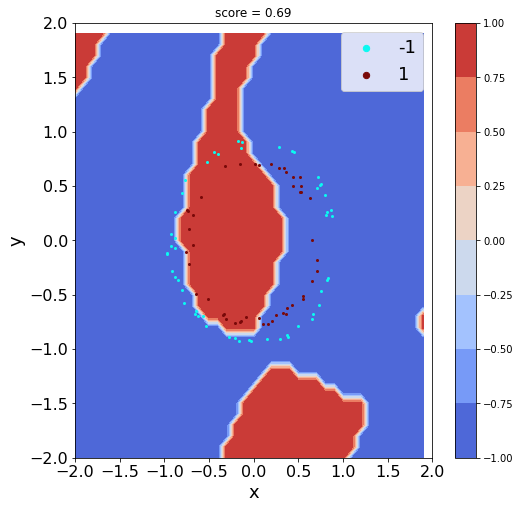

time :  241.85351943969727


In [82]:
q_fit(1, 1000)

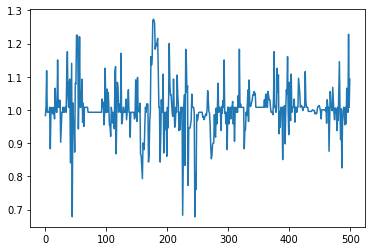

In [83]:
plt.plot([i for i in range(len(loss_list))], loss_list)

### Lunar data set

As one may remark, the circuit does not always manage to define complex boundaries between the two classes. However, it manages to define a border that leads to a rather good score.

100%|██████████| 800/800 [00:00<00:00, 1712.55it/s]


loss: 1.0127263301657445


100%|██████████| 800/800 [00:00<00:00, 1731.66it/s]


loss: 0.7452198454015273


100%|██████████| 800/800 [00:00<00:00, 1735.16it/s]


loss: 0.37547176034862323


100%|██████████| 800/800 [00:00<00:00, 1730.57it/s]


loss: 1.2327168352809899


100%|██████████| 800/800 [00:00<00:00, 1737.70it/s]


loss: 1.0854687549017623


100%|██████████| 800/800 [00:00<00:00, 1734.92it/s]


loss: 0.5578491389835898


100%|██████████| 800/800 [00:00<00:00, 1643.79it/s]


loss: 1.0128918598918464


100%|██████████| 800/800 [00:00<00:00, 1677.25it/s]


loss: 1.0127938906687857


100%|██████████| 800/800 [00:00<00:00, 1648.51it/s]


loss: 0.7328971139109757


100%|██████████| 800/800 [00:00<00:00, 1635.97it/s]


loss: 0.9879178791609948


100%|██████████| 800/800 [00:00<00:00, 1740.23it/s]


loss: 0.9877616542270737


100%|██████████| 800/800 [00:00<00:00, 1739.70it/s]


loss: 1.3603440494676349


100%|██████████| 800/800 [00:00<00:00, 1735.28it/s]


loss: 0.3601932567349329


100%|██████████| 800/800 [00:00<00:00, 1737.49it/s]


loss: 0.6977443649540863


100%|██████████| 800/800 [00:00<00:00, 1736.05it/s]


loss: 0.9879573428877577


100%|██████████| 800/800 [00:00<00:00, 1734.52it/s]


loss: 0.9877627380304731


100%|██████████| 800/800 [00:00<00:00, 1742.48it/s]


loss: 0.7828988027156878


100%|██████████| 800/800 [00:00<00:00, 1731.47it/s]


loss: 0.9878606175273164


100%|██████████| 800/800 [00:00<00:00, 1731.61it/s]


loss: 1.012791168903146


100%|██████████| 800/800 [00:00<00:00, 1731.91it/s]


loss: 1.2127538822379695


100%|██████████| 800/800 [00:00<00:00, 1741.33it/s]


loss: 1.0131267917944509


100%|██████████| 800/800 [00:00<00:00, 1742.40it/s]


loss: 1.0127358744845716


100%|██████████| 800/800 [00:00<00:00, 1741.30it/s]


loss: 0.9878475064503481


100%|██████████| 800/800 [00:00<00:00, 1738.51it/s]


loss: 0.9879797115336857


100%|██████████| 800/800 [00:00<00:00, 1741.85it/s]


loss: 1.0129901882829424


100%|██████████| 800/800 [00:00<00:00, 1731.66it/s]


loss: 0.8552256734274367


100%|██████████| 800/800 [00:00<00:00, 1746.96it/s]


loss: 1.0028741254906128


100%|██████████| 800/800 [00:00<00:00, 1729.31it/s]


loss: 0.9879754439488758


100%|██████████| 800/800 [00:00<00:00, 1741.62it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1735.88it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1746.48it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1747.62it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1735.13it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1749.29it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1733.94it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1748.49it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1735.65it/s]


loss: 1.0053215588866413


100%|██████████| 800/800 [00:00<00:00, 1742.68it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1725.79it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1737.88it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1741.03it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1737.65it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1735.22it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1741.83it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1749.46it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1735.81it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1751.24it/s]


loss: 1.0128215588866414


100%|██████████| 800/800 [00:00<00:00, 1747.49it/s]


loss: 1.012798400145248


100%|██████████| 800/800 [00:00<00:00, 1751.61it/s]


loss: 1.3903201386753918


100%|██████████| 800/800 [00:00<00:00, 1745.34it/s]


loss: 1.3378207378011397


100%|██████████| 800/800 [00:00<00:00, 1752.79it/s]


loss: 1.6452836236851722


100%|██████████| 800/800 [00:00<00:00, 1744.82it/s]


loss: 1.2102770883695626


100%|██████████| 800/800 [00:00<00:00, 1749.72it/s]


loss: 0.9877934646340263


100%|██████████| 800/800 [00:00<00:00, 1746.65it/s]


loss: 1.0127290198139425


100%|██████████| 800/800 [00:00<00:00, 1755.77it/s]


loss: 0.9876955449349414


100%|██████████| 800/800 [00:00<00:00, 1753.47it/s]


loss: 0.987766524512569


100%|██████████| 800/800 [00:00<00:00, 1749.71it/s]


loss: 0.9878219659223649


100%|██████████| 800/800 [00:00<00:00, 1747.43it/s]


loss: 0.9879359434187798


100%|██████████| 800/800 [00:00<00:00, 1718.02it/s]


loss: 0.987888638991113


100%|██████████| 800/800 [00:00<00:00, 1751.15it/s]


loss: 1.012996902887294


100%|██████████| 800/800 [00:00<00:00, 1748.05it/s]


loss: 0.34777281863706305


100%|██████████| 800/800 [00:00<00:00, 1747.26it/s]


loss: 0.987792733945549


100%|██████████| 800/800 [00:00<00:00, 1749.98it/s]


loss: 0.3503884922242563


100%|██████████| 800/800 [00:00<00:00, 1748.36it/s]


loss: 0.9879810529951742


100%|██████████| 800/800 [00:00<00:00, 1750.04it/s]


loss: 0.9880279876569805


100%|██████████| 800/800 [00:00<00:00, 1758.76it/s]


loss: 1.5903386117399712


100%|██████████| 800/800 [00:00<00:00, 1734.73it/s]


loss: 1.0427688328255738


100%|██████████| 800/800 [00:00<00:00, 1745.97it/s]


loss: 1.3729301080515568


100%|██████████| 800/800 [00:00<00:00, 1759.63it/s]


loss: 0.7453987613044994


100%|██████████| 800/800 [00:00<00:00, 1749.88it/s]


loss: 1.0127903806982808


100%|██████████| 800/800 [00:00<00:00, 1750.65it/s]


loss: 1.0128087379236523


100%|██████████| 800/800 [00:00<00:00, 1747.50it/s]


loss: 1.0128316384975544


100%|██████████| 800/800 [00:00<00:00, 1747.62it/s]


loss: 0.9877392720555702


100%|██████████| 800/800 [00:00<00:00, 1742.87it/s]


loss: 0.9877945847171657


100%|██████████| 800/800 [00:00<00:00, 1749.72it/s]


loss: 1.0176241765590281


100%|██████████| 800/800 [00:00<00:00, 1727.93it/s]


loss: 1.0127696871217666


100%|██████████| 800/800 [00:00<00:00, 1739.08it/s]


loss: 0.987816653751203


100%|██████████| 800/800 [00:00<00:00, 1745.27it/s]


loss: 1.0128124998276795


100%|██████████| 800/800 [00:00<00:00, 1754.66it/s]


loss: 0.9879354033593938


100%|██████████| 800/800 [00:00<00:00, 1749.79it/s]


loss: 1.0128082782565315


100%|██████████| 800/800 [00:00<00:00, 1738.54it/s]


loss: 1.0129158753924092


100%|██████████| 800/800 [00:00<00:00, 1741.90it/s]


loss: 0.9880390916719689


100%|██████████| 800/800 [00:00<00:00, 1743.39it/s]


loss: 0.5176828569291878


100%|██████████| 800/800 [00:00<00:00, 1754.75it/s]


loss: 0.3402981423416001


100%|██████████| 800/800 [00:00<00:00, 1682.87it/s]


loss: 1.5952277451103545


100%|██████████| 800/800 [00:00<00:00, 1751.57it/s]


loss: 1.6252277451103545


100%|██████████| 800/800 [00:00<00:00, 1733.29it/s]


loss: 1.5977277451103544


100%|██████████| 800/800 [00:00<00:00, 1735.93it/s]


loss: 0.9352277451103547


100%|██████████| 800/800 [00:00<00:00, 1747.71it/s]


loss: 0.36772774511035455


100%|██████████| 800/800 [00:00<00:00, 1752.85it/s]


loss: 1.6452277451103545


100%|██████████| 800/800 [00:00<00:00, 1741.78it/s]


loss: 1.6452277451103545


100%|██████████| 800/800 [00:00<00:00, 1747.90it/s]


loss: 1.6402277451103544


100%|██████████| 800/800 [00:00<00:00, 1741.11it/s]


loss: 1.0127277451103545


100%|██████████| 800/800 [00:00<00:00, 1746.38it/s]


loss: 1.0077277451103546


100%|██████████| 800/800 [00:00<00:00, 1774.11it/s]


loss: 1.0127277451103545


100%|██████████| 800/800 [00:00<00:00, 1764.22it/s]


loss: 1.0127277451103545


100%|██████████| 800/800 [00:00<00:00, 1756.03it/s]


loss: 1.0452277451103544


100%|██████████| 800/800 [00:00<00:00, 1751.85it/s]


loss: 1.0127277451103545


100%|██████████| 800/800 [00:00<00:00, 1739.14it/s]


loss: 1.5152277451103544


100%|██████████| 800/800 [00:00<00:00, 1741.17it/s]


loss: 1.2127277451103544


100%|██████████| 800/800 [00:00<00:00, 1731.58it/s]


loss: 1.4052277451103545


100%|██████████| 800/800 [00:00<00:00, 1722.20it/s]


loss: 1.1877277451103545


100%|██████████| 800/800 [00:00<00:00, 1735.72it/s]


loss: 1.1877277451103545


100%|██████████| 800/800 [00:00<00:00, 1718.19it/s]


loss: 0.7078014561122186


100%|██████████| 800/800 [00:00<00:00, 1730.33it/s]


loss: 1.0127474805006988


100%|██████████| 800/800 [00:00<00:00, 1725.25it/s]


loss: 1.0127359694206282


100%|██████████| 800/800 [00:00<00:00, 1729.44it/s]


loss: 1.0127717999192603


100%|██████████| 800/800 [00:00<00:00, 1731.03it/s]


loss: 1.0128531480477434


100%|██████████| 800/800 [00:00<00:00, 1730.56it/s]


loss: 1.0129176004266753


100%|██████████| 800/800 [00:00<00:00, 1735.71it/s]


loss: 1.012967169527733


100%|██████████| 800/800 [00:00<00:00, 1735.60it/s]


loss: 1.0130349746068599


100%|██████████| 800/800 [00:00<00:00, 1736.91it/s]


loss: 1.013052380990676


100%|██████████| 800/800 [00:00<00:00, 1728.11it/s]


loss: 1.0130868056198727


100%|██████████| 800/800 [00:00<00:00, 1731.29it/s]


loss: 0.9878540752618209


100%|██████████| 800/800 [00:00<00:00, 1718.32it/s]


loss: 1.0127915878491645


100%|██████████| 800/800 [00:00<00:00, 1737.23it/s]


loss: 0.3579042621913237


100%|██████████| 800/800 [00:00<00:00, 1743.82it/s]


loss: 1.012889569664127


100%|██████████| 800/800 [00:00<00:00, 1733.06it/s]


loss: 1.0127677134317072


100%|██████████| 800/800 [00:00<00:00, 1743.47it/s]


loss: 1.3728785220092377


100%|██████████| 800/800 [00:00<00:00, 1743.64it/s]


loss: 1.0129289684782168


100%|██████████| 800/800 [00:00<00:00, 1741.61it/s]


loss: 0.5376856691240217


100%|██████████| 800/800 [00:00<00:00, 1740.78it/s]


loss: 1.0129351130917794


100%|██████████| 800/800 [00:00<00:00, 1729.78it/s]


loss: 0.9877942253814174


100%|██████████| 800/800 [00:00<00:00, 1731.22it/s]


loss: 1.012649911937839


100%|██████████| 800/800 [00:00<00:00, 1742.77it/s]


loss: 1.0128083615806776


100%|██████████| 800/800 [00:00<00:00, 1730.53it/s]


loss: 1.0753097681679546


100%|██████████| 800/800 [00:00<00:00, 1710.79it/s]


loss: 1.005206402161355


100%|██████████| 800/800 [00:00<00:00, 1693.93it/s]


loss: 0.43036946217636296


100%|██████████| 800/800 [00:00<00:00, 1734.87it/s]


loss: 0.9878547472688495


100%|██████████| 800/800 [00:00<00:00, 1721.72it/s]


loss: 0.9879650282481777


100%|██████████| 800/800 [00:00<00:00, 1759.26it/s]


loss: 1.1078439768294728


100%|██████████| 800/800 [00:00<00:00, 1736.70it/s]


loss: 1.0128640497570043


100%|██████████| 800/800 [00:00<00:00, 1763.26it/s]


loss: 0.44035521155416607


100%|██████████| 800/800 [00:00<00:00, 1787.81it/s]


loss: 1.382765671596984


100%|██████████| 800/800 [00:00<00:00, 1730.90it/s]


loss: 0.9879413907885779


100%|██████████| 800/800 [00:00<00:00, 1765.53it/s]


loss: 0.9877236122223678


100%|██████████| 800/800 [00:00<00:00, 1731.28it/s]


loss: 0.9878526273180868


100%|██████████| 800/800 [00:00<00:00, 1765.73it/s]


loss: 1.0128945761514576


100%|██████████| 800/800 [00:00<00:00, 1725.96it/s]


loss: 1.012905845761699


100%|██████████| 800/800 [00:00<00:00, 1770.95it/s]


loss: 0.5728801794995099


100%|██████████| 800/800 [00:00<00:00, 1735.60it/s]


loss: 0.750423878646391


100%|██████████| 800/800 [00:00<00:00, 1774.75it/s]


loss: 0.5354238786463911


100%|██████████| 800/800 [00:00<00:00, 1745.23it/s]


loss: 1.400423878646391


100%|██████████| 800/800 [00:00<00:00, 1792.99it/s]


loss: 0.9879238786463911


100%|██████████| 800/800 [00:00<00:00, 1753.01it/s]


loss: 0.9879238786463911


100%|██████████| 800/800 [00:00<00:00, 1785.84it/s]


loss: 0.9879238786463911


100%|██████████| 800/800 [00:00<00:00, 1775.01it/s]


loss: 0.9879238786463911


100%|██████████| 800/800 [00:00<00:00, 1736.43it/s]


loss: 0.9879238786463911


100%|██████████| 800/800 [00:00<00:00, 1789.12it/s]


loss: 0.9879238786463911


100%|██████████| 800/800 [00:00<00:00, 1734.99it/s]


loss: 1.012923878646391


100%|██████████| 800/800 [00:00<00:00, 1778.48it/s]


loss: 1.630423878646391


100%|██████████| 800/800 [00:00<00:00, 1743.42it/s]


loss: 1.012923878646391


100%|██████████| 800/800 [00:00<00:00, 1789.73it/s]


loss: 1.012923878646391


100%|██████████| 800/800 [00:00<00:00, 1739.98it/s]


loss: 1.012923878646391


100%|██████████| 800/800 [00:00<00:00, 1778.84it/s]


loss: 1.012923878646391


100%|██████████| 800/800 [00:00<00:00, 1750.23it/s]


loss: 0.34542387864639096


100%|██████████| 800/800 [00:00<00:00, 1779.54it/s]


loss: 0.9879238786463911


100%|██████████| 800/800 [00:00<00:00, 1776.16it/s]


loss: 0.512923878646391


100%|██████████| 800/800 [00:00<00:00, 1746.41it/s]


loss: 0.405423878646391


100%|██████████| 800/800 [00:00<00:00, 1788.23it/s]


loss: 0.40535949773505414


100%|██████████| 800/800 [00:00<00:00, 1743.19it/s]


loss: 0.46783843838295874


100%|██████████| 800/800 [00:00<00:00, 1711.57it/s]


loss: 0.5053163459444697


100%|██████████| 800/800 [00:00<00:00, 1715.32it/s]


loss: 0.38785017717560866


100%|██████████| 800/800 [00:00<00:00, 1766.93it/s]


loss: 0.9878119389625599


100%|██████████| 800/800 [00:00<00:00, 1730.77it/s]


loss: 0.9878147287268364


100%|██████████| 800/800 [00:00<00:00, 1766.97it/s]


loss: 0.9877967396949905


100%|██████████| 800/800 [00:00<00:00, 1729.00it/s]


loss: 0.9878390964275575


100%|██████████| 800/800 [00:00<00:00, 1766.66it/s]


loss: 0.9878798696821592


100%|██████████| 800/800 [00:00<00:00, 1750.98it/s]


loss: 0.9878083804399096


100%|██████████| 800/800 [00:00<00:00, 1759.94it/s]


loss: 1.0127444922033548


100%|██████████| 800/800 [00:00<00:00, 1773.26it/s]


loss: 0.660323512826946


100%|██████████| 800/800 [00:00<00:00, 1710.38it/s]


loss: 0.9877853303632845


100%|██████████| 800/800 [00:00<00:00, 1767.92it/s]


loss: 1.012882280726429


100%|██████████| 800/800 [00:00<00:00, 1719.78it/s]


loss: 1.0129781719718054


100%|██████████| 800/800 [00:00<00:00, 1781.03it/s]


loss: 0.7576094774998057


100%|██████████| 800/800 [00:00<00:00, 1737.57it/s]


loss: 1.012799236847259


100%|██████████| 800/800 [00:00<00:00, 1772.38it/s]


loss: 0.6052798479645943


100%|██████████| 800/800 [00:00<00:00, 1742.26it/s]


loss: 1.0128317061070815


100%|██████████| 800/800 [00:00<00:00, 1780.32it/s]


loss: 1.012883693060759


100%|██████████| 800/800 [00:00<00:00, 1747.46it/s]


loss: 0.44278486586268484


100%|██████████| 800/800 [00:00<00:00, 1791.51it/s]


loss: 1.0129310666029372


100%|██████████| 800/800 [00:00<00:00, 1773.98it/s]


loss: 1.012882951996593


100%|██████████| 800/800 [00:00<00:00, 1732.99it/s]


loss: 1.0127676755569437


100%|██████████| 800/800 [00:00<00:00, 1781.25it/s]


loss: 1.4253557902583813


100%|██████████| 800/800 [00:00<00:00, 1733.14it/s]


loss: 1.0128345328797241


100%|██████████| 800/800 [00:00<00:00, 1782.09it/s]


loss: 0.5878905384697246


100%|██████████| 800/800 [00:00<00:00, 1754.80it/s]


loss: 1.0128286415824783


100%|██████████| 800/800 [00:00<00:00, 1810.52it/s]


loss: 1.0128228235425425


100%|██████████| 800/800 [00:00<00:00, 1741.60it/s]


loss: 0.7852753126379046


100%|██████████| 800/800 [00:00<00:00, 1769.03it/s]


loss: 0.9877863973507899


100%|██████████| 800/800 [00:00<00:00, 1747.37it/s]


loss: 1.0127665742093204


100%|██████████| 800/800 [00:00<00:00, 1781.62it/s]


loss: 1.2903646702508595


100%|██████████| 800/800 [00:00<00:00, 1777.34it/s]


loss: 1.5378600967069154


100%|██████████| 800/800 [00:00<00:00, 1749.63it/s]


loss: 0.9877160681362607


100%|██████████| 800/800 [00:00<00:00, 1791.62it/s]


loss: 1.0103875391962773


100%|██████████| 800/800 [00:00<00:00, 1752.17it/s]


loss: 1.6003510790522981


100%|██████████| 800/800 [00:00<00:00, 1785.59it/s]


loss: 0.9829633333298357


100%|██████████| 800/800 [00:00<00:00, 1742.73it/s]


loss: 0.9654633333298356


100%|██████████| 800/800 [00:00<00:00, 1783.56it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1757.88it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1788.99it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1760.07it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1788.27it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1796.31it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1759.65it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1790.74it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1728.27it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1794.30it/s]


loss: 0.7829633333298356


100%|██████████| 800/800 [00:00<00:00, 1753.39it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1794.97it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1755.02it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1792.84it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1762.73it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1796.38it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1809.22it/s]


loss: 0.9879633333298357


100%|██████████| 800/800 [00:00<00:00, 1723.56it/s]


loss: 0.5829425460967148


100%|██████████| 800/800 [00:00<00:00, 1777.96it/s]


loss: 0.5779296765530271


100%|██████████| 800/800 [00:00<00:00, 1762.85it/s]


loss: 0.4179542854554366


100%|██████████| 800/800 [00:00<00:00, 1784.22it/s]


loss: 0.4254625098966111


100%|██████████| 800/800 [00:00<00:00, 1739.23it/s]


loss: 0.9629492237680055


100%|██████████| 800/800 [00:00<00:00, 1792.98it/s]


loss: 0.7304853006613556


100%|██████████| 800/800 [00:00<00:00, 1750.28it/s]


loss: 0.7004141668910179


100%|██████████| 800/800 [00:00<00:00, 1779.79it/s]


loss: 0.9479418716043393


100%|██████████| 800/800 [00:00<00:00, 1755.83it/s]


loss: 0.9503904286054837


100%|██████████| 800/800 [00:00<00:00, 1746.14it/s]


loss: 0.5529280103106532


100%|██████████| 800/800 [00:00<00:00, 1788.55it/s]


loss: 1.6154518571177645


100%|██████████| 800/800 [00:00<00:00, 1792.86it/s]


loss: 1.012823292224866


100%|██████████| 800/800 [00:00<00:00, 1794.32it/s]


loss: 1.6378097092866606


100%|██████████| 800/800 [00:00<00:00, 1805.38it/s]


loss: 1.6229064577576395


100%|██████████| 800/800 [00:00<00:00, 1784.08it/s]


loss: 1.0128430487157325


100%|██████████| 800/800 [00:00<00:00, 1791.39it/s]


loss: 0.9879610715868488


100%|██████████| 800/800 [00:00<00:00, 1810.13it/s]


loss: 0.9878505672163449


100%|██████████| 800/800 [00:00<00:00, 1805.86it/s]


loss: 0.6428228370137695


100%|██████████| 800/800 [00:00<00:00, 1771.18it/s]


loss: 0.7529289084270251


100%|██████████| 800/800 [00:00<00:00, 1789.06it/s]


loss: 0.9878560232285166


100%|██████████| 800/800 [00:00<00:00, 1798.33it/s]


loss: 0.9876991512998943


100%|██████████| 800/800 [00:00<00:00, 1771.60it/s]


loss: 1.012947617471895


100%|██████████| 800/800 [00:00<00:00, 1801.47it/s]


loss: 0.9902856628002089


100%|██████████| 800/800 [00:00<00:00, 1780.60it/s]


loss: 1.0127170267282803


100%|██████████| 800/800 [00:00<00:00, 1796.80it/s]


loss: 1.0228882372893764


100%|██████████| 800/800 [00:00<00:00, 1776.29it/s]


loss: 1.012761335050757


100%|██████████| 800/800 [00:00<00:00, 1785.77it/s]


loss: 0.3901995522234405


100%|██████████| 800/800 [00:00<00:00, 1784.66it/s]


loss: 0.9878512105880898


100%|██████████| 800/800 [00:00<00:00, 1799.59it/s]


loss: 0.4904059241234785


100%|██████████| 800/800 [00:00<00:00, 1783.28it/s]


loss: 1.0128455547739332


100%|██████████| 800/800 [00:00<00:00, 1772.81it/s]


loss: 1.005298126141931


100%|██████████| 800/800 [00:00<00:00, 1784.09it/s]


loss: 1.0129433416409128


100%|██████████| 800/800 [00:00<00:00, 1788.10it/s]


loss: 0.9877860076199224


100%|██████████| 800/800 [00:00<00:00, 1801.71it/s]


loss: 0.2827121345764657


100%|██████████| 800/800 [00:00<00:00, 1779.91it/s]


loss: 1.3029847785084558
 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1   -9.20e-01  4.15e-01  1.00e-01  1.00e-01    9   
  1     2   -9.20e-01  2.36e-01  5.00e-02  1.00e-02   10   
  1     3   -9.30e-01  2.35e-01  2.00e-01  1.00e-02   11   
  1     4   -9.30e-01  4.41e-02  1.00e-01  1.00e-02   12   
  1     5   -9.30e-01  1.27e-01  5.00e-02  1.00e-02   14   
  1     6   -9.30e-01  3.86e-02  2.50e-02  1.00e-02   16   
  1     7   -9.30e-01  5.70e-02  1.00e-02  1.00e-02   18   
  1     8   -9.30e-01  2.60e-02  5.00e-03  1.00e-03   19   
  1     9   -9.30e-01  2.56e-03  2.50e-03  1.00e-03   21   
  1    10   -9.30e-01  4.76e-03  1.00e-03  1.00e-03   23   
  1    11   -9.30e-01  2.07e-03  1.00e-03  1.00e-03   25   
  1    12   -9.30e-01  1.03e-03  1.00e-03  1.00e-03   27   
  1    13   -9.30e-01  1.17e-03  5.00e-04  1.00e-04   28   
  1    14   -9.30e-01  7.32e-04  2.50e-04  1.00e-04   30   
  1    15   -9.30e-01  1.99e-04  1.00e-04  1.00e-04   32   
  1    16   -9.

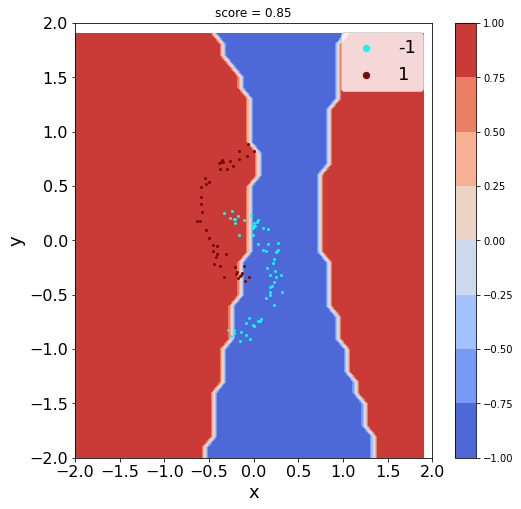

time :  119.68333339691162


In [102]:
q_fit(2, 1000)

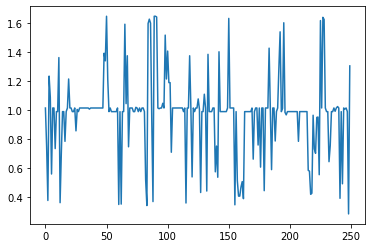

In [103]:
plt.plot([i for i in range(len(loss_list))], loss_list)

100%|██████████| 800/800 [00:00<00:00, 1774.73it/s]


loss: 1.0026912195495365


100%|██████████| 800/800 [00:00<00:00, 1790.22it/s]


loss: 1.002934836274641


100%|██████████| 800/800 [00:00<00:00, 1800.17it/s]


loss: 0.9978441308313245


100%|██████████| 800/800 [00:00<00:00, 1813.09it/s]


loss: 0.5029231103919924


100%|██████████| 800/800 [00:00<00:00, 1818.62it/s]


loss: 1.3278153865934892


100%|██████████| 800/800 [00:00<00:00, 1801.71it/s]


loss: 0.6528928239627485


100%|██████████| 800/800 [00:00<00:00, 1804.65it/s]


loss: 0.9976591987721385


100%|██████████| 800/800 [00:00<00:00, 1791.69it/s]


loss: 0.9978159245493738


100%|██████████| 800/800 [00:00<00:00, 1802.02it/s]


loss: 1.0028684334236353


100%|██████████| 800/800 [00:00<00:00, 1795.36it/s]


loss: 0.9978028872112913


100%|██████████| 800/800 [00:00<00:00, 1797.57it/s]


loss: 1.0030102848188418


100%|██████████| 800/800 [00:00<00:00, 1813.52it/s]


loss: 0.9978041209277649


100%|██████████| 800/800 [00:00<00:00, 1820.86it/s]


loss: 1.6254395040824379


100%|██████████| 800/800 [00:00<00:00, 1821.39it/s]


loss: 0.9977973128861547


100%|██████████| 800/800 [00:00<00:00, 1798.66it/s]


loss: 1.002910059129198


100%|██████████| 800/800 [00:00<00:00, 1814.20it/s]


loss: 0.9951565543275148


100%|██████████| 800/800 [00:00<00:00, 1819.44it/s]


loss: 1.0027381181527222


100%|██████████| 800/800 [00:00<00:00, 1806.60it/s]


loss: 0.9979357597215164


100%|██████████| 800/800 [00:00<00:00, 1798.14it/s]


loss: 1.0028397973759362


100%|██████████| 800/800 [00:00<00:00, 1805.15it/s]


loss: 0.9977808910276122


100%|██████████| 800/800 [00:00<00:00, 1798.74it/s]


loss: 1.5878566056166052


100%|██████████| 800/800 [00:00<00:00, 1806.76it/s]


loss: 0.5728418616049595


100%|██████████| 800/800 [00:00<00:00, 1794.12it/s]


loss: 1.0028955726641475


100%|██████████| 800/800 [00:00<00:00, 1811.39it/s]


loss: 0.9977931334916917


100%|██████████| 800/800 [00:00<00:00, 1801.54it/s]


loss: 1.217815123938564


100%|██████████| 800/800 [00:00<00:00, 1806.91it/s]


loss: 1.0029206734511822


100%|██████████| 800/800 [00:00<00:00, 1797.46it/s]


loss: 0.3978863985539597


100%|██████████| 800/800 [00:00<00:00, 1800.39it/s]


loss: 0.6678335919562132


100%|██████████| 800/800 [00:00<00:00, 1746.60it/s]


loss: 1.0027585251767333


100%|██████████| 800/800 [00:00<00:00, 1763.56it/s]


loss: 1.0027585251767333


100%|██████████| 800/800 [00:00<00:00, 1747.26it/s]


loss: 1.0027585251767333


100%|██████████| 800/800 [00:00<00:00, 1675.31it/s]


loss: 1.0027585251767333


100%|██████████| 800/800 [00:00<00:00, 1752.23it/s]


loss: 1.0027585251767333


100%|██████████| 800/800 [00:00<00:00, 1784.99it/s]


loss: 1.0027585251767333


100%|██████████| 800/800 [00:00<00:00, 1788.46it/s]


loss: 1.0027585251767333


100%|██████████| 800/800 [00:00<00:00, 1791.37it/s]


loss: 1.0027585251767333


100%|██████████| 800/800 [00:00<00:00, 1774.77it/s]


loss: 1.0027585251767333


100%|██████████| 800/800 [00:00<00:00, 1766.63it/s]


loss: 1.0027585251767333


100%|██████████| 800/800 [00:00<00:00, 1809.72it/s]


loss: 1.0177585251767334


100%|██████████| 800/800 [00:00<00:00, 1815.35it/s]


loss: 1.1902585251767333


100%|██████████| 800/800 [00:00<00:00, 1776.00it/s]


loss: 1.0027585251767333


100%|██████████| 800/800 [00:00<00:00, 1764.11it/s]


loss: 1.0027585251767333


100%|██████████| 800/800 [00:00<00:00, 1782.43it/s]


loss: 1.0027585251767333


100%|██████████| 800/800 [00:00<00:00, 1789.36it/s]


loss: 1.2952585251767332


100%|██████████| 800/800 [00:00<00:00, 1787.36it/s]


loss: 1.1427585251767334


100%|██████████| 800/800 [00:00<00:00, 1809.64it/s]


loss: 1.2727585251767333


100%|██████████| 800/800 [00:00<00:00, 1793.44it/s]


loss: 1.0027585251767333


100%|██████████| 800/800 [00:00<00:00, 1800.19it/s]


loss: 1.002803792651277


100%|██████████| 800/800 [00:00<00:00, 1817.01it/s]


loss: 1.002800720689903


100%|██████████| 800/800 [00:00<00:00, 1587.85it/s]


loss: 1.002806699990946


100%|██████████| 800/800 [00:00<00:00, 1532.86it/s]


loss: 1.0028067029524392


100%|██████████| 800/800 [00:00<00:00, 1518.37it/s]


loss: 1.0028048912518117


100%|██████████| 800/800 [00:00<00:00, 1518.05it/s]


loss: 1.0027944889798497


100%|██████████| 800/800 [00:00<00:00, 1423.63it/s]


loss: 1.0028216734956363


100%|██████████| 800/800 [00:00<00:00, 1508.93it/s]


loss: 1.0027805188426264


100%|██████████| 800/800 [00:00<00:00, 1541.64it/s]


loss: 1.0028077607879862


100%|██████████| 800/800 [00:00<00:00, 1531.54it/s]


loss: 1.002774680578862


100%|██████████| 800/800 [00:00<00:00, 1543.56it/s]


loss: 0.9977515074759199


100%|██████████| 800/800 [00:00<00:00, 1523.32it/s]


loss: 0.997783082690644


100%|██████████| 800/800 [00:00<00:00, 1501.75it/s]


loss: 1.0027601964181


100%|██████████| 800/800 [00:00<00:00, 1494.30it/s]


loss: 0.9977930817184337


100%|██████████| 800/800 [00:00<00:00, 1530.55it/s]


loss: 1.0027423769589432


100%|██████████| 800/800 [00:00<00:00, 1531.66it/s]


loss: 0.9977408400829577


100%|██████████| 800/800 [00:00<00:00, 1526.37it/s]


loss: 0.997798022451633


100%|██████████| 800/800 [00:00<00:00, 1495.46it/s]


loss: 0.997849580167861


100%|██████████| 800/800 [00:00<00:00, 1516.20it/s]


loss: 1.0028476768604373


100%|██████████| 800/800 [00:00<00:00, 1527.39it/s]


loss: 1.5153594214894113


100%|██████████| 800/800 [00:00<00:00, 1532.75it/s]


loss: 1.0029191501858714


100%|██████████| 800/800 [00:00<00:00, 1514.97it/s]


loss: 1.0028226282459616


100%|██████████| 800/800 [00:00<00:00, 1516.30it/s]


loss: 0.9978236960356416


100%|██████████| 800/800 [00:00<00:00, 1525.57it/s]


loss: 0.3951865193887156


100%|██████████| 800/800 [00:00<00:00, 1541.32it/s]


loss: 1.030253294788381


100%|██████████| 800/800 [00:00<00:00, 1543.95it/s]


loss: 0.4578292408006389


100%|██████████| 800/800 [00:00<00:00, 1518.58it/s]


loss: 0.9978304757853399


100%|██████████| 800/800 [00:00<00:00, 1521.50it/s]


loss: 0.3729689189231732


100%|██████████| 800/800 [00:00<00:00, 1520.10it/s]


loss: 0.7927775850385039


100%|██████████| 800/800 [00:00<00:00, 1524.69it/s]


loss: 1.0029107094741239


100%|██████████| 800/800 [00:00<00:00, 1533.11it/s]


loss: 1.0027836751216321


100%|██████████| 800/800 [00:00<00:00, 1496.77it/s]


loss: 0.6202266464923868


100%|██████████| 800/800 [00:00<00:00, 1542.62it/s]


loss: 1.002759358750339


100%|██████████| 800/800 [00:00<00:00, 1541.92it/s]


loss: 0.9977949734306979


100%|██████████| 800/800 [00:00<00:00, 1541.88it/s]


loss: 1.0026803671337843


100%|██████████| 800/800 [00:00<00:00, 1487.46it/s]


loss: 0.9979311645669683


100%|██████████| 800/800 [00:00<00:00, 1475.94it/s]


loss: 0.4879136867729999


100%|██████████| 800/800 [00:00<00:00, 1476.36it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1510.62it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1540.21it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1534.21it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1526.33it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1544.93it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1526.67it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1524.65it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1513.79it/s]


loss: 1.2079742626488166


100%|██████████| 800/800 [00:00<00:00, 1498.05it/s]


loss: 1.1129742626488166


100%|██████████| 800/800 [00:00<00:00, 1510.87it/s]


loss: 1.0029742626488165


100%|██████████| 800/800 [00:00<00:00, 1541.54it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1477.27it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1525.94it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1522.99it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1521.94it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1534.61it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1546.97it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1527.83it/s]


loss: 0.9979742626488166


100%|██████████| 800/800 [00:00<00:00, 1531.97it/s]


loss: 0.9979698041228835


100%|██████████| 800/800 [00:00<00:00, 1528.63it/s]


loss: 0.9979340079202403


100%|██████████| 800/800 [00:00<00:00, 1516.72it/s]


loss: 0.9978794063897942


100%|██████████| 800/800 [00:00<00:00, 1514.16it/s]


loss: 0.9979017445524804


100%|██████████| 800/800 [00:00<00:00, 1521.83it/s]


loss: 0.9978988972647975


100%|██████████| 800/800 [00:00<00:00, 1518.15it/s]


loss: 0.9979098975300152


100%|██████████| 800/800 [00:00<00:00, 1518.87it/s]


loss: 0.9978887603271974


100%|██████████| 800/800 [00:00<00:00, 1526.92it/s]


loss: 0.9979247500313222


100%|██████████| 800/800 [00:00<00:00, 1530.37it/s]


loss: 0.9978748197510122


100%|██████████| 800/800 [00:00<00:00, 1517.27it/s]


loss: 1.0028412224451773


100%|██████████| 800/800 [00:00<00:00, 1503.57it/s]


loss: 1.5880047188534376


100%|██████████| 800/800 [00:00<00:00, 1495.96it/s]


loss: 0.46767399513974267


100%|██████████| 800/800 [00:00<00:00, 1537.73it/s]


loss: 0.9729965150687945


100%|██████████| 800/800 [00:00<00:00, 1500.41it/s]


loss: 0.9977624147383176


100%|██████████| 800/800 [00:00<00:00, 1541.22it/s]


loss: 1.0028518897517318


100%|██████████| 800/800 [00:00<00:00, 1540.28it/s]


loss: 0.9978023593121148


100%|██████████| 800/800 [00:00<00:00, 1536.56it/s]


loss: 1.0027694509069343


100%|██████████| 800/800 [00:00<00:00, 1525.00it/s]


loss: 0.9980025506879675


100%|██████████| 800/800 [00:00<00:00, 1522.16it/s]


loss: 1.0028175529141499


100%|██████████| 800/800 [00:00<00:00, 1524.50it/s]


loss: 0.9979976295164857


100%|██████████| 800/800 [00:00<00:00, 1505.71it/s]


loss: 1.0052855198906931


100%|██████████| 800/800 [00:00<00:00, 1520.81it/s]


loss: 0.8528800552908966


100%|██████████| 800/800 [00:00<00:00, 1504.77it/s]


loss: 0.447868500662204


100%|██████████| 800/800 [00:00<00:00, 1526.92it/s]


loss: 0.9978382040535088


100%|██████████| 800/800 [00:00<00:00, 1503.27it/s]


loss: 0.9977620822596994


100%|██████████| 800/800 [00:00<00:00, 1495.07it/s]


loss: 0.9978457840445242


100%|██████████| 800/800 [00:00<00:00, 1497.09it/s]


loss: 1.0028170878023062


100%|██████████| 800/800 [00:00<00:00, 1498.17it/s]


loss: 0.5955043873961156


100%|██████████| 800/800 [00:00<00:00, 1473.91it/s]


loss: 1.3927787343864757


100%|██████████| 800/800 [00:00<00:00, 1444.69it/s]


loss: 1.0027817159077943


100%|██████████| 800/800 [00:00<00:00, 1467.37it/s]


loss: 1.3529700464647032


100%|██████████| 800/800 [00:00<00:00, 1499.73it/s]


loss: 1.002700127809863


100%|██████████| 800/800 [00:00<00:00, 1505.97it/s]


loss: 0.9978651833960235


100%|██████████| 800/800 [00:00<00:00, 1496.21it/s]


loss: 0.9979675619788424


100%|██████████| 800/800 [00:00<00:00, 1503.01it/s]


loss: 0.9979707794812334


100%|██████████| 800/800 [00:00<00:00, 1513.40it/s]


loss: 1.0028917166917033


100%|██████████| 800/800 [00:00<00:00, 1502.90it/s]


loss: 1.002761269097366


100%|██████████| 800/800 [00:00<00:00, 1531.49it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1522.61it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1496.88it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1492.94it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1482.74it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1495.76it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1509.98it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1475.78it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1495.16it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1488.87it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1494.96it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1510.55it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1461.94it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1470.55it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1494.53it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1493.34it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1466.63it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1477.70it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1503.29it/s]


loss: 1.0028488655447028


100%|██████████| 800/800 [00:00<00:00, 1505.10it/s]


loss: 1.002818622287106


100%|██████████| 800/800 [00:00<00:00, 1410.61it/s]


loss: 1.0027435508817069


100%|██████████| 800/800 [00:00<00:00, 1493.25it/s]


loss: 1.0027169966611194


100%|██████████| 800/800 [00:00<00:00, 1493.69it/s]


loss: 1.002776544325936


100%|██████████| 800/800 [00:00<00:00, 1531.37it/s]


loss: 1.002797299950102


100%|██████████| 800/800 [00:00<00:00, 1520.61it/s]


loss: 1.002892264801419


100%|██████████| 800/800 [00:00<00:00, 1524.99it/s]


loss: 1.0028726385038842


100%|██████████| 800/800 [00:00<00:00, 1535.23it/s]


loss: 1.0029095635993128


100%|██████████| 800/800 [00:00<00:00, 1526.93it/s]


loss: 1.0028693084138662


100%|██████████| 800/800 [00:00<00:00, 1494.98it/s]


loss: 1.0028880068428963


100%|██████████| 800/800 [00:00<00:00, 1489.18it/s]


loss: 0.6852831808697603


100%|██████████| 800/800 [00:00<00:00, 1518.12it/s]


loss: 0.9979523231153944


100%|██████████| 800/800 [00:00<00:00, 1536.43it/s]


loss: 1.0029298573292338


100%|██████████| 800/800 [00:00<00:00, 1505.45it/s]


loss: 0.6554581296721066


100%|██████████| 800/800 [00:00<00:00, 1519.35it/s]


loss: 0.9977361679952544


100%|██████████| 800/800 [00:00<00:00, 1509.23it/s]


loss: 1.0028410802413212


100%|██████████| 800/800 [00:00<00:00, 1507.17it/s]


loss: 1.0028133984524084


100%|██████████| 800/800 [00:00<00:00, 1497.40it/s]


loss: 0.9979672546480354


100%|██████████| 800/800 [00:00<00:00, 1494.46it/s]


loss: 0.9976783914996671


100%|██████████| 800/800 [00:00<00:00, 1495.57it/s]


loss: 1.2351808414784415


100%|██████████| 800/800 [00:00<00:00, 1489.21it/s]


loss: 1.0028052373674399


100%|██████████| 800/800 [00:00<00:00, 1488.81it/s]


loss: 1.002853332390839


100%|██████████| 800/800 [00:00<00:00, 1490.80it/s]


loss: 0.2753891530430429


100%|██████████| 800/800 [00:00<00:00, 1485.64it/s]


loss: 0.9978514480088949


100%|██████████| 800/800 [00:00<00:00, 1493.60it/s]


loss: 1.5853700646497177


100%|██████████| 800/800 [00:00<00:00, 1495.26it/s]


loss: 1.0028583095505863


100%|██████████| 800/800 [00:00<00:00, 1522.50it/s]


loss: 0.9976789949450725


100%|██████████| 800/800 [00:00<00:00, 1526.41it/s]


loss: 0.9976586318984391


100%|██████████| 800/800 [00:00<00:00, 1447.20it/s]


loss: 0.5753814110884163


100%|██████████| 800/800 [00:00<00:00, 1450.57it/s]


loss: 1.002749815367627


100%|██████████| 800/800 [00:00<00:00, 1494.39it/s]


loss: 0.9977228281142165


100%|██████████| 800/800 [00:00<00:00, 1526.87it/s]


loss: 0.41040016884437913


100%|██████████| 800/800 [00:00<00:00, 1503.14it/s]


loss: 1.0028507453595172


100%|██████████| 800/800 [00:00<00:00, 1530.20it/s]


loss: 1.0028475245963406


100%|██████████| 800/800 [00:00<00:00, 1527.58it/s]


loss: 1.6452855551436307


100%|██████████| 800/800 [00:00<00:00, 1508.72it/s]


loss: 1.4827511077628224


100%|██████████| 800/800 [00:00<00:00, 1517.86it/s]


loss: 0.997674465989898


100%|██████████| 800/800 [00:00<00:00, 1525.38it/s]


loss: 1.002871717045495


100%|██████████| 800/800 [00:00<00:00, 1519.18it/s]


loss: 1.002871717045495


100%|██████████| 800/800 [00:00<00:00, 1522.53it/s]


loss: 1.002871717045495


100%|██████████| 800/800 [00:00<00:00, 1520.59it/s]


loss: 1.002871717045495


100%|██████████| 800/800 [00:00<00:00, 1483.29it/s]


loss: 1.002871717045495


100%|██████████| 800/800 [00:00<00:00, 1521.65it/s]


loss: 1.002871717045495


100%|██████████| 800/800 [00:00<00:00, 1481.46it/s]


loss: 1.002871717045495


100%|██████████| 800/800 [00:00<00:00, 1514.53it/s]


loss: 1.002871717045495


100%|██████████| 800/800 [00:00<00:00, 1504.71it/s]


loss: 1.0378717170454952


100%|██████████| 800/800 [00:00<00:00, 1486.91it/s]


loss: 0.9978717170454952


100%|██████████| 800/800 [00:00<00:00, 1499.91it/s]


loss: 1.197871717045495


100%|██████████| 800/800 [00:00<00:00, 1509.38it/s]


loss: 1.002871717045495


100%|██████████| 800/800 [00:00<00:00, 1503.68it/s]


loss: 0.38787171704549517


100%|██████████| 800/800 [00:00<00:00, 1501.93it/s]


loss: 1.002871717045495


100%|██████████| 800/800 [00:00<00:00, 1517.17it/s]


loss: 1.002871717045495


100%|██████████| 800/800 [00:00<00:00, 1509.99it/s]


loss: 1.002871717045495


100%|██████████| 800/800 [00:00<00:00, 1511.34it/s]


loss: 1.605371717045495


100%|██████████| 800/800 [00:00<00:00, 1517.68it/s]


loss: 1.605371717045495


100%|██████████| 800/800 [00:00<00:00, 1520.80it/s]


loss: 0.39037171704549517


100%|██████████| 800/800 [00:00<00:00, 1517.97it/s]


loss: 1.0029184132274285


100%|██████████| 800/800 [00:00<00:00, 1518.23it/s]


loss: 1.0029425951484394


100%|██████████| 800/800 [00:00<00:00, 1504.36it/s]


loss: 1.0029722164509323


100%|██████████| 800/800 [00:00<00:00, 1512.06it/s]


loss: 0.5829807740752354


100%|██████████| 800/800 [00:00<00:00, 1473.22it/s]


loss: 1.0030319521234377


100%|██████████| 800/800 [00:00<00:00, 1499.61it/s]


loss: 1.003014132536431


100%|██████████| 800/800 [00:00<00:00, 1522.10it/s]


loss: 1.0030912060344763


100%|██████████| 800/800 [00:00<00:00, 1485.49it/s]


loss: 1.003088723383457


100%|██████████| 800/800 [00:00<00:00, 1474.94it/s]


loss: 1.0030317065338068


100%|██████████| 800/800 [00:00<00:00, 1515.94it/s]


loss: 1.0030146713431125


100%|██████████| 800/800 [00:00<00:00, 1499.59it/s]


loss: 0.9978174217596651


100%|██████████| 800/800 [00:00<00:00, 1535.76it/s]


loss: 1.0027302060406638


100%|██████████| 800/800 [00:00<00:00, 1537.57it/s]


loss: 0.9752907396711799


100%|██████████| 800/800 [00:00<00:00, 1525.31it/s]


loss: 0.9078306393622527


100%|██████████| 800/800 [00:00<00:00, 1522.52it/s]


loss: 0.9978541899078094


100%|██████████| 800/800 [00:00<00:00, 1424.23it/s]


loss: 1.1129016692083054


100%|██████████| 800/800 [00:00<00:00, 1529.82it/s]


loss: 0.9977997669173131


100%|██████████| 800/800 [00:00<00:00, 1712.77it/s]


loss: 1.002831361820751


100%|██████████| 800/800 [00:00<00:00, 1754.53it/s]


loss: 0.9978266663549111


100%|██████████| 800/800 [00:00<00:00, 1786.12it/s]


loss: 0.9979556907970469


100%|██████████| 800/800 [00:00<00:00, 1749.48it/s]


loss: 1.0028432413213513


100%|██████████| 800/800 [00:00<00:00, 1793.67it/s]


loss: 1.4054075678257214


100%|██████████| 800/800 [00:00<00:00, 1750.07it/s]


loss: 0.9977773779434125


100%|██████████| 800/800 [00:00<00:00, 1771.82it/s]


loss: 0.9977693923327691


100%|██████████| 800/800 [00:00<00:00, 1757.74it/s]


loss: 0.9953803691411829


100%|██████████| 800/800 [00:00<00:00, 1793.62it/s]


loss: 1.4628852560390275


100%|██████████| 800/800 [00:00<00:00, 1792.95it/s]


loss: 1.0028049763694713


100%|██████████| 800/800 [00:00<00:00, 1728.61it/s]


loss: 1.3852774186898977


100%|██████████| 800/800 [00:00<00:00, 1774.84it/s]


loss: 0.7852928323384648


100%|██████████| 800/800 [00:00<00:00, 1757.54it/s]


loss: 1.0028288357500323


100%|██████████| 800/800 [00:00<00:00, 1788.95it/s]


loss: 0.9978376226970168


100%|██████████| 800/800 [00:00<00:00, 1753.24it/s]


loss: 0.7677698172176146


100%|██████████| 800/800 [00:00<00:00, 1787.17it/s]


loss: 0.9978268425243718


100%|██████████| 800/800 [00:00<00:00, 1744.47it/s]


loss: 0.9978178902703407


100%|██████████| 800/800 [00:00<00:00, 1797.10it/s]


loss: 0.997929615919074
 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1   -8.80e-01  1.00e-01  1.00e-01  1.00e-01    9   
  1     2   -8.80e-01  8.85e-02  5.00e-02  1.00e-02   10   
  1     3   -8.80e-01  7.47e-02  2.50e-02  1.00e-02   12   
  1     4   -8.80e-01  5.53e-02  1.00e-02  1.00e-02   13   
  1     5   -8.80e-01  1.31e+00  5.00e-03  1.00e-03   14   
  1     6   -8.80e-01  4.20e-01  2.50e-03  1.00e-03   16   
  1     7   -8.80e-01  4.24e-01  1.00e-03  1.00e-03   18   
  1     8   -8.80e-01  1.71e-02  1.00e-03  1.00e-03   20   
  1     9   -8.80e-01  7.03e-02  1.00e-03  1.00e-03   22   
  1    10   -8.80e-01  5.38e-02  5.00e-04  1.00e-04   23   
  1    11   -8.80e-01  3.16e-02  2.50e-04  1.00e-04   25   
  1    12   -8.80e-01  5.63e-03  1.00e-04  1.00e-04   27   
  1    13   -8.80e-01  8.82e-03  1.00e-04  1.00e-04   29   
  1    14   -8.80e-01  6.33e-03  5.00e-05  1.00e-05   30   
  1    15   -8.80e-01  4.16e-03  2.50e-05  1.00e-05   32   
  1    16   -8.8

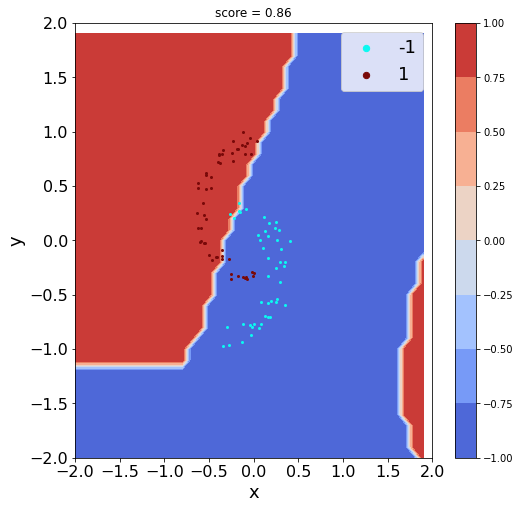

time :  132.52276849746704


In [106]:
q_fit(2, 1000)

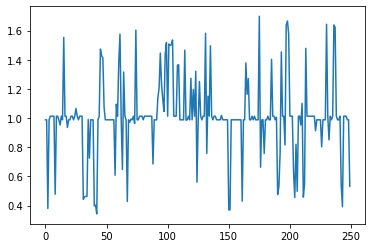

In [105]:
plt.plot([i for i in range(len(loss_list))], loss_list)

100%|██████████| 800/800 [00:00<00:00, 1717.03it/s]


loss: 0.9978402527620706


100%|██████████| 800/800 [00:00<00:00, 1772.96it/s]


loss: 1.5753315954752598


100%|██████████| 800/800 [00:00<00:00, 1734.51it/s]


loss: 1.002708040493127


100%|██████████| 800/800 [00:00<00:00, 1739.83it/s]


loss: 1.0029889741688947


100%|██████████| 800/800 [00:00<00:00, 1714.32it/s]


loss: 1.0027792026549298


100%|██████████| 800/800 [00:00<00:00, 1792.33it/s]


loss: 1.1979570472440468


100%|██████████| 800/800 [00:00<00:00, 1725.93it/s]


loss: 0.9902691938717738


100%|██████████| 800/800 [00:00<00:00, 1733.32it/s]


loss: 1.0028491335667649


100%|██████████| 800/800 [00:00<00:00, 1768.95it/s]


loss: 1.625296203896559


100%|██████████| 800/800 [00:00<00:00, 1719.53it/s]


loss: 1.0026773258967583


100%|██████████| 800/800 [00:00<00:00, 1780.74it/s]


loss: 0.39517518603122814


100%|██████████| 800/800 [00:00<00:00, 1724.87it/s]


loss: 0.9904114927779261


100%|██████████| 800/800 [00:00<00:00, 1760.95it/s]


loss: 1.4128235637419941


100%|██████████| 800/800 [00:00<00:00, 1737.66it/s]


loss: 0.6578540413879806


100%|██████████| 800/800 [00:00<00:00, 1792.22it/s]


loss: 1.4978929273992911


100%|██████████| 800/800 [00:00<00:00, 1724.18it/s]


loss: 1.0029629318223963


100%|██████████| 800/800 [00:00<00:00, 1774.88it/s]


loss: 1.0028996516696096


100%|██████████| 800/800 [00:00<00:00, 1745.74it/s]


loss: 1.0029830150245196


100%|██████████| 800/800 [00:00<00:00, 1792.68it/s]


loss: 0.9980376167798736


100%|██████████| 800/800 [00:00<00:00, 1739.76it/s]


loss: 1.002701929041695


100%|██████████| 800/800 [00:00<00:00, 1777.37it/s]


loss: 1.002767437646558


100%|██████████| 800/800 [00:00<00:00, 1775.20it/s]


loss: 0.9976471853840445


100%|██████████| 800/800 [00:00<00:00, 1717.10it/s]


loss: 1.0027221290772217


100%|██████████| 800/800 [00:00<00:00, 1759.89it/s]


loss: 0.7278889592103087


100%|██████████| 800/800 [00:00<00:00, 1714.32it/s]


loss: 0.9977982187777593


100%|██████████| 800/800 [00:00<00:00, 1768.37it/s]


loss: 0.9978739076079134


100%|██████████| 800/800 [00:00<00:00, 1724.80it/s]


loss: 0.627779311480596


100%|██████████| 800/800 [00:00<00:00, 1771.12it/s]


loss: 0.9976369159423427


100%|██████████| 800/800 [00:00<00:00, 1730.12it/s]


loss: 0.480401038097339


100%|██████████| 800/800 [00:00<00:00, 1775.15it/s]


loss: 0.5554010380973391


100%|██████████| 800/800 [00:00<00:00, 1718.32it/s]


loss: 0.9979010380973391


100%|██████████| 800/800 [00:00<00:00, 1764.56it/s]


loss: 0.9979010380973391


100%|██████████| 800/800 [00:00<00:00, 1770.40it/s]


loss: 0.9979010380973391


100%|██████████| 800/800 [00:00<00:00, 1751.72it/s]


loss: 0.9979010380973391


100%|██████████| 800/800 [00:00<00:00, 1764.79it/s]


loss: 0.9979010380973391


100%|██████████| 800/800 [00:00<00:00, 1767.65it/s]


loss: 1.0029010380973389


100%|██████████| 800/800 [00:00<00:00, 1757.66it/s]


loss: 1.0029010380973389


100%|██████████| 800/800 [00:00<00:00, 1753.60it/s]


loss: 1.0029010380973389


100%|██████████| 800/800 [00:00<00:00, 1755.41it/s]


loss: 1.0029010380973389


100%|██████████| 800/800 [00:00<00:00, 1755.13it/s]


loss: 1.0029010380973389


100%|██████████| 800/800 [00:00<00:00, 1777.48it/s]


loss: 1.0029010380973389


100%|██████████| 800/800 [00:00<00:00, 1762.69it/s]


loss: 1.0029010380973389


100%|██████████| 800/800 [00:00<00:00, 1769.61it/s]


loss: 1.0029010380973389


100%|██████████| 800/800 [00:00<00:00, 1739.41it/s]


loss: 1.0029010380973389


100%|██████████| 800/800 [00:00<00:00, 1767.72it/s]


loss: 1.0029010380973389


100%|██████████| 800/800 [00:00<00:00, 1743.06it/s]


loss: 1.0029010380973389


100%|██████████| 800/800 [00:00<00:00, 1720.13it/s]


loss: 1.0029010380973389


100%|██████████| 800/800 [00:00<00:00, 1776.14it/s]


loss: 1.0029372692858547


100%|██████████| 800/800 [00:00<00:00, 1770.45it/s]


loss: 1.0028640849994341


100%|██████████| 800/800 [00:00<00:00, 1779.11it/s]


loss: 1.002888475733803


100%|██████████| 800/800 [00:00<00:00, 1762.34it/s]


loss: 1.002898004588976


100%|██████████| 800/800 [00:00<00:00, 1769.20it/s]


loss: 1.002900110288896


100%|██████████| 800/800 [00:00<00:00, 1774.41it/s]


loss: 1.002899979351432


100%|██████████| 800/800 [00:00<00:00, 1756.39it/s]


loss: 1.0029234593975134


100%|██████████| 800/800 [00:00<00:00, 1748.51it/s]


loss: 1.0029571791830707


100%|██████████| 800/800 [00:00<00:00, 1719.30it/s]


loss: 1.0029173564985316


100%|██████████| 800/800 [00:00<00:00, 1749.67it/s]


loss: 1.0028652336002246


100%|██████████| 800/800 [00:00<00:00, 1765.06it/s]


loss: 0.3927263417651973


100%|██████████| 800/800 [00:00<00:00, 1738.97it/s]


loss: 1.0027805558631335


100%|██████████| 800/800 [00:00<00:00, 1764.43it/s]


loss: 0.4702587607353621


100%|██████████| 800/800 [00:00<00:00, 1773.00it/s]


loss: 1.0003348834700785


100%|██████████| 800/800 [00:00<00:00, 1781.35it/s]


loss: 0.56516114600571


100%|██████████| 800/800 [00:00<00:00, 1760.42it/s]


loss: 1.0029183221047508


100%|██████████| 800/800 [00:00<00:00, 1760.03it/s]


loss: 1.32020947033452


100%|██████████| 800/800 [00:00<00:00, 1769.80it/s]


loss: 1.5076716405605228


100%|██████████| 800/800 [00:00<00:00, 1780.27it/s]


loss: 1.0027595036128547


100%|██████████| 800/800 [00:00<00:00, 1780.93it/s]


loss: 1.0026217101175896


100%|██████████| 800/800 [00:00<00:00, 1779.38it/s]


loss: 0.39540254766148286


100%|██████████| 800/800 [00:00<00:00, 1766.80it/s]


loss: 1.0028333792547024


100%|██████████| 800/800 [00:00<00:00, 1766.77it/s]


loss: 0.9977593078368161


100%|██████████| 800/800 [00:00<00:00, 1781.03it/s]


loss: 0.9977616276971489


100%|██████████| 800/800 [00:00<00:00, 1795.89it/s]


loss: 1.0027561369452382


100%|██████████| 800/800 [00:00<00:00, 1773.99it/s]


loss: 0.3626679639234154


100%|██████████| 800/800 [00:00<00:00, 1769.23it/s]


loss: 0.9977407849466203


100%|██████████| 800/800 [00:00<00:00, 1787.63it/s]


loss: 1.0029396116633529


100%|██████████| 800/800 [00:00<00:00, 1754.15it/s]


loss: 0.9980282208804357


100%|██████████| 800/800 [00:00<00:00, 1768.64it/s]


loss: 0.8501910681347594


100%|██████████| 800/800 [00:00<00:00, 1738.42it/s]


loss: 0.9976782049510563


100%|██████████| 800/800 [00:00<00:00, 1757.90it/s]


loss: 0.6503086853548852


100%|██████████| 800/800 [00:00<00:00, 1778.47it/s]


loss: 1.0028159076813414


100%|██████████| 800/800 [00:00<00:00, 1786.23it/s]


loss: 1.002656024232489


100%|██████████| 800/800 [00:00<00:00, 1769.61it/s]


loss: 1.0029169793791222


100%|██████████| 800/800 [00:00<00:00, 1790.06it/s]


loss: 0.7302074413268539


100%|██████████| 800/800 [00:00<00:00, 1790.71it/s]


loss: 0.5203488396219691


100%|██████████| 800/800 [00:00<00:00, 1768.69it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1766.82it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1773.45it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1782.92it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1790.87it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1791.88it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1773.60it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1793.96it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1552.18it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1533.11it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1524.35it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1515.72it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1496.44it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1544.80it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1520.56it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1540.74it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1526.31it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1517.92it/s]


loss: 0.9976983311837102


100%|██████████| 800/800 [00:00<00:00, 1522.17it/s]


loss: 1.66019833118371


100%|██████████| 800/800 [00:00<00:00, 1525.22it/s]


loss: 1.64274312238465


100%|██████████| 800/800 [00:00<00:00, 1514.25it/s]


loss: 1.5453040181958067


100%|██████████| 800/800 [00:00<00:00, 1711.31it/s]


loss: 1.6703630364081916


100%|██████████| 800/800 [00:00<00:00, 1725.19it/s]


loss: 1.6603570608249592


100%|██████████| 800/800 [00:00<00:00, 1737.83it/s]


loss: 1.0028794902080815


100%|██████████| 800/800 [00:00<00:00, 1774.21it/s]


loss: 1.0029502831513024


100%|██████████| 800/800 [00:00<00:00, 1725.84it/s]


loss: 1.0029683716653772


100%|██████████| 800/800 [00:00<00:00, 1735.56it/s]


loss: 1.002986032633264


100%|██████████| 800/800 [00:00<00:00, 1766.16it/s]


loss: 1.0030306588297104


100%|██████████| 800/800 [00:00<00:00, 1684.39it/s]


loss: 1.0030483174424445


100%|██████████| 800/800 [00:00<00:00, 1736.34it/s]


loss: 0.9976423306193005


100%|██████████| 800/800 [00:00<00:00, 1685.52it/s]


loss: 0.5252305528156903


100%|██████████| 800/800 [00:00<00:00, 1739.82it/s]


loss: 0.9978904458795337


100%|██████████| 800/800 [00:00<00:00, 1702.77it/s]


loss: 1.0028882816875457


100%|██████████| 800/800 [00:00<00:00, 1767.99it/s]


loss: 1.0028943859363042


100%|██████████| 800/800 [00:00<00:00, 1688.89it/s]


loss: 0.9977755473319934


100%|██████████| 800/800 [00:00<00:00, 1740.42it/s]


loss: 0.5953477171499835


100%|██████████| 800/800 [00:00<00:00, 1722.26it/s]


loss: 1.0027124991008298


100%|██████████| 800/800 [00:00<00:00, 1741.62it/s]


loss: 1.0027684698021735


100%|██████████| 800/800 [00:00<00:00, 1727.71it/s]


loss: 1.0027210791161751


100%|██████████| 800/800 [00:00<00:00, 1743.54it/s]


loss: 0.9979747378458428


100%|██████████| 800/800 [00:00<00:00, 1735.48it/s]


loss: 0.6626708829776543


100%|██████████| 800/800 [00:00<00:00, 1740.96it/s]


loss: 1.0029431060926142


100%|██████████| 800/800 [00:00<00:00, 1763.81it/s]


loss: 1.0029052052020642


100%|██████████| 800/800 [00:00<00:00, 1695.07it/s]


loss: 1.270243498418104


100%|██████████| 800/800 [00:00<00:00, 1747.52it/s]


loss: 0.8603261997221993


100%|██████████| 800/800 [00:00<00:00, 1700.96it/s]


loss: 0.9977802346206858


100%|██████████| 800/800 [00:00<00:00, 1733.86it/s]


loss: 0.8028236772114584


100%|██████████| 800/800 [00:00<00:00, 1685.44it/s]


loss: 1.0028696116934932


100%|██████████| 800/800 [00:00<00:00, 1752.61it/s]


loss: 0.9976979901116036


100%|██████████| 800/800 [00:00<00:00, 1715.17it/s]


loss: 1.0027611505275411


100%|██████████| 800/800 [00:00<00:00, 1735.23it/s]


loss: 1.5328015543538012


100%|██████████| 800/800 [00:00<00:00, 1712.83it/s]


loss: 1.000258609720205


100%|██████████| 800/800 [00:00<00:00, 1746.92it/s]


loss: 0.30025053536388163


100%|██████████| 800/800 [00:00<00:00, 1711.25it/s]


loss: 1.002703206429873


100%|██████████| 800/800 [00:00<00:00, 1700.84it/s]


loss: 1.2003864077507156


100%|██████████| 800/800 [00:00<00:00, 1684.81it/s]


loss: 0.22294026853454252


100%|██████████| 800/800 [00:00<00:00, 1756.40it/s]


loss: 1.0027838156135724


100%|██████████| 800/800 [00:00<00:00, 1747.91it/s]


loss: 1.0027838156135724


100%|██████████| 800/800 [00:00<00:00, 1701.66it/s]


loss: 1.0027838156135724


100%|██████████| 800/800 [00:00<00:00, 1762.52it/s]


loss: 1.0077838156135726


100%|██████████| 800/800 [00:00<00:00, 1695.24it/s]


loss: 1.6527838156135726


100%|██████████| 800/800 [00:00<00:00, 1743.86it/s]


loss: 1.0027838156135724


100%|██████████| 800/800 [00:00<00:00, 1707.49it/s]


loss: 1.0027838156135724


100%|██████████| 800/800 [00:00<00:00, 1722.01it/s]


loss: 0.3952838156135724


100%|██████████| 800/800 [00:00<00:00, 1710.20it/s]


loss: 0.9977838156135724


100%|██████████| 800/800 [00:00<00:00, 1733.93it/s]


loss: 0.9977838156135724


100%|██████████| 800/800 [00:00<00:00, 1715.49it/s]


loss: 0.48528381561357237


100%|██████████| 800/800 [00:00<00:00, 1762.10it/s]


loss: 1.0027838156135724


100%|██████████| 800/800 [00:00<00:00, 1711.65it/s]


loss: 1.0027838156135724


100%|██████████| 800/800 [00:00<00:00, 1736.68it/s]


loss: 1.0027838156135724


100%|██████████| 800/800 [00:00<00:00, 1702.66it/s]


loss: 1.0027838156135724


100%|██████████| 800/800 [00:00<00:00, 1743.24it/s]


loss: 1.0027838156135724


100%|██████████| 800/800 [00:00<00:00, 1751.72it/s]


loss: 1.0027838156135724


100%|██████████| 800/800 [00:00<00:00, 1703.66it/s]


loss: 1.0027838156135724


100%|██████████| 800/800 [00:00<00:00, 1741.78it/s]


loss: 1.0027838156135724


100%|██████████| 800/800 [00:00<00:00, 1706.57it/s]


loss: 1.002786547320821


100%|██████████| 800/800 [00:00<00:00, 1746.79it/s]


loss: 1.00282291740282


100%|██████████| 800/800 [00:00<00:00, 1687.09it/s]


loss: 1.002836604780967


100%|██████████| 800/800 [00:00<00:00, 1733.26it/s]


loss: 0.597786822075611


100%|██████████| 800/800 [00:00<00:00, 1706.80it/s]


loss: 0.5952909465157917


100%|██████████| 800/800 [00:00<00:00, 1754.07it/s]


loss: 0.5853661626529864


100%|██████████| 800/800 [00:00<00:00, 1709.73it/s]


loss: 0.9978728036564902


100%|██████████| 800/800 [00:00<00:00, 1745.56it/s]


loss: 0.9979304972325201


100%|██████████| 800/800 [00:00<00:00, 1703.49it/s]


loss: 0.9979233173199343


100%|██████████| 800/800 [00:00<00:00, 1753.81it/s]


loss: 0.9980030035344762


100%|██████████| 800/800 [00:00<00:00, 1737.90it/s]


loss: 1.1077566369918828


100%|██████████| 800/800 [00:00<00:00, 1729.24it/s]


loss: 0.495251149969722


100%|██████████| 800/800 [00:00<00:00, 1736.01it/s]


loss: 1.0029440832301497


100%|██████████| 800/800 [00:00<00:00, 1690.99it/s]


loss: 1.6378169520407302


100%|██████████| 800/800 [00:00<00:00, 1740.00it/s]


loss: 0.782762403057497


100%|██████████| 800/800 [00:00<00:00, 1716.24it/s]


loss: 0.9978612836128802


100%|██████████| 800/800 [00:00<00:00, 1739.81it/s]


loss: 0.9902472917081687


100%|██████████| 800/800 [00:00<00:00, 1691.01it/s]


loss: 0.432797946242442


100%|██████████| 800/800 [00:00<00:00, 1777.99it/s]


loss: 1.0027952028367797


100%|██████████| 800/800 [00:00<00:00, 1709.54it/s]


loss: 1.0027711748343646


100%|██████████| 800/800 [00:00<00:00, 1737.63it/s]


loss: 1.0029439937741784


100%|██████████| 800/800 [00:00<00:00, 1726.99it/s]


loss: 0.9975685975692627


100%|██████████| 800/800 [00:00<00:00, 1744.17it/s]


loss: 1.3852773274098105


100%|██████████| 800/800 [00:00<00:00, 1727.74it/s]


loss: 0.9976686436580448


100%|██████████| 800/800 [00:00<00:00, 1749.68it/s]


loss: 0.9977596409514932


100%|██████████| 800/800 [00:00<00:00, 1729.48it/s]


loss: 0.998002256931808


100%|██████████| 800/800 [00:00<00:00, 1727.22it/s]


loss: 0.9979142946390503


100%|██████████| 800/800 [00:00<00:00, 1750.27it/s]


loss: 0.997905745303525


100%|██████████| 800/800 [00:00<00:00, 1699.34it/s]


loss: 0.4203127094407563


100%|██████████| 800/800 [00:00<00:00, 1747.19it/s]


loss: 1.00281467151399


100%|██████████| 800/800 [00:00<00:00, 1711.43it/s]


loss: 0.5427702199813538


100%|██████████| 800/800 [00:00<00:00, 1743.67it/s]


loss: 0.9978332723561317


100%|██████████| 800/800 [00:00<00:00, 1709.07it/s]


loss: 1.0027793970124181


100%|██████████| 800/800 [00:00<00:00, 1756.84it/s]


loss: 0.39524555197346994


100%|██████████| 800/800 [00:00<00:00, 1716.94it/s]


loss: 0.9977282612576753


100%|██████████| 800/800 [00:00<00:00, 1711.04it/s]


loss: 0.9977120231236034


100%|██████████| 800/800 [00:00<00:00, 1679.61it/s]


loss: 1.0027674745910937


100%|██████████| 800/800 [00:00<00:00, 1741.74it/s]


loss: 1.0754816577936146


100%|██████████| 800/800 [00:00<00:00, 1731.92it/s]


loss: 0.39548165779361466


100%|██████████| 800/800 [00:00<00:00, 1741.18it/s]


loss: 0.4104816577936146


100%|██████████| 800/800 [00:00<00:00, 1777.30it/s]


loss: 1.5454816577936146


100%|██████████| 800/800 [00:00<00:00, 1717.09it/s]


loss: 1.5029816577936146


100%|██████████| 800/800 [00:00<00:00, 1742.83it/s]


loss: 1.5679816577936145


100%|██████████| 800/800 [00:00<00:00, 1718.53it/s]


loss: 1.5679816577936145


100%|██████████| 800/800 [00:00<00:00, 1769.98it/s]


loss: 0.9979816577936147


100%|██████████| 800/800 [00:00<00:00, 1699.35it/s]


loss: 1.4679816577936147


100%|██████████| 800/800 [00:00<00:00, 1742.09it/s]


loss: 1.5254816577936146


100%|██████████| 800/800 [00:00<00:00, 1745.91it/s]


loss: 1.2279816577936147


100%|██████████| 800/800 [00:00<00:00, 1749.26it/s]


loss: 0.9979816577936147


100%|██████████| 800/800 [00:00<00:00, 1732.13it/s]


loss: 0.9979816577936147


100%|██████████| 800/800 [00:00<00:00, 1728.23it/s]


loss: 0.9979816577936147


100%|██████████| 800/800 [00:00<00:00, 1744.66it/s]


loss: 0.9979816577936147


100%|██████████| 800/800 [00:00<00:00, 1731.83it/s]


loss: 0.9979816577936147


100%|██████████| 800/800 [00:00<00:00, 1712.58it/s]


loss: 0.5154816577936147


100%|██████████| 800/800 [00:00<00:00, 1740.55it/s]


loss: 1.4654816577936147


100%|██████████| 800/800 [00:00<00:00, 1745.31it/s]


loss: 1.6429816577936147


100%|██████████| 800/800 [00:00<00:00, 1740.15it/s]


loss: 1.590449292152195


100%|██████████| 800/800 [00:00<00:00, 1740.82it/s]


loss: 1.622967851205603


100%|██████████| 800/800 [00:00<00:00, 1754.16it/s]


loss: 1.5580191587106929


100%|██████████| 800/800 [00:00<00:00, 1750.05it/s]


loss: 1.578017671128612


100%|██████████| 800/800 [00:00<00:00, 1735.52it/s]


loss: 1.3779534766220152


100%|██████████| 800/800 [00:00<00:00, 1760.45it/s]


loss: 1.447873057817068


100%|██████████| 800/800 [00:00<00:00, 1739.89it/s]


loss: 1.1352764561696125


100%|██████████| 800/800 [00:00<00:00, 1752.25it/s]


loss: 1.1178368556065412


100%|██████████| 800/800 [00:00<00:00, 1757.64it/s]


loss: 1.3278603460292133


100%|██████████| 800/800 [00:00<00:00, 1761.95it/s]


loss: 1.2853331118475086


100%|██████████| 800/800 [00:00<00:00, 1766.31it/s]


loss: 0.9977601546413637


100%|██████████| 800/800 [00:00<00:00, 1754.57it/s]


loss: 0.997808380662242


100%|██████████| 800/800 [00:00<00:00, 1735.08it/s]


loss: 0.5504095066128374


100%|██████████| 800/800 [00:00<00:00, 1757.15it/s]


loss: 0.9977654157597616


100%|██████████| 800/800 [00:00<00:00, 1745.41it/s]


loss: 0.6004096408658816


100%|██████████| 800/800 [00:00<00:00, 1747.38it/s]


loss: 0.9978189449473054


100%|██████████| 800/800 [00:00<00:00, 1754.47it/s]


loss: 0.9978586088669973


100%|██████████| 800/800 [00:00<00:00, 1760.77it/s]


loss: 1.002843487609293


100%|██████████| 800/800 [00:00<00:00, 1739.44it/s]


loss: 1.0027909239234034


100%|██████████| 800/800 [00:00<00:00, 1752.33it/s]


loss: 0.8528407737134124


100%|██████████| 800/800 [00:00<00:00, 1755.91it/s]


loss: 1.0179443957423502


100%|██████████| 800/800 [00:00<00:00, 1735.03it/s]


loss: 0.9977499474878111


100%|██████████| 800/800 [00:00<00:00, 1763.25it/s]


loss: 1.1351903882820364


100%|██████████| 800/800 [00:00<00:00, 1749.62it/s]


loss: 1.1529136503103887


100%|██████████| 800/800 [00:00<00:00, 1750.69it/s]


loss: 1.0027143270726202


100%|██████████| 800/800 [00:00<00:00, 1754.87it/s]


loss: 0.625248467281428


100%|██████████| 800/800 [00:00<00:00, 1762.10it/s]


loss: 0.997740765398776


100%|██████████| 800/800 [00:00<00:00, 1762.53it/s]


loss: 0.43029131275288046


100%|██████████| 800/800 [00:00<00:00, 1754.25it/s]


loss: 1.0027870874481732


100%|██████████| 800/800 [00:00<00:00, 1749.62it/s]


loss: 1.0028244274864326


100%|██████████| 800/800 [00:00<00:00, 1758.54it/s]


loss: 0.997877817927666


100%|██████████| 800/800 [00:00<00:00, 1753.10it/s]


loss: 0.9876934956268246


100%|██████████| 800/800 [00:00<00:00, 1747.97it/s]


loss: 0.652712533563067


100%|██████████| 800/800 [00:00<00:00, 1741.69it/s]


loss: 1.0479155043589627


100%|██████████| 800/800 [00:00<00:00, 1729.45it/s]


loss: 0.8078763682628572
 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1   -8.70e-01  1.32e-01  1.00e-01  1.00e-01    9   
  1     2   -8.70e-01  1.23e-01  5.00e-02  1.00e-02   10   
  1     3   -8.70e-01  3.03e-01  2.50e-02  1.00e-02   12   
  1     4   -8.70e-01  1.05e-01  1.00e-02  1.00e-02   14   
  1     5   -8.70e-01  9.72e-01  5.00e-03  1.00e-03   15   
  1     6   -8.70e-01  3.41e-01  2.50e-03  1.00e-03   17   
  1     7   -8.70e-01  5.60e-01  1.00e-03  1.00e-03   19   
  1     8   -8.70e-01  2.35e-01  1.00e-03  1.00e-03   21   
  1     9   -8.70e-01  9.48e-02  5.00e-04  1.00e-04   22   
  1    10   -8.70e-01  4.13e-02  2.50e-04  1.00e-04   24   
  1    11   -8.70e-01  1.86e-02  1.00e-04  1.00e-04   26   
  1    12   -8.70e-01  2.42e-03  1.00e-04  1.00e-04   28   
  1    13   -8.70e-01  1.21e-03  1.00e-04  1.00e-04   30   
  1    14   -8.70e-01  1.11e-03  5.00e-05  1.00e-05   31   
  1    15   -8.70e-01  9.57e-04  2.50e-05  1.00e-05   33   
  1    16   -8.

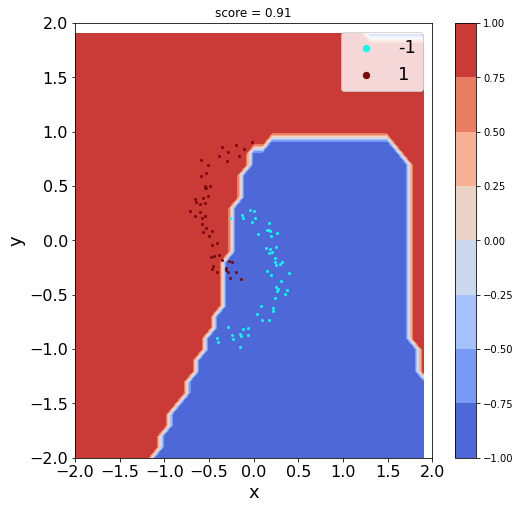

time :  120.83680462837219


In [112]:
q_fit(2, 1000)

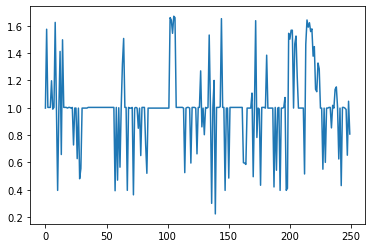

In [113]:
plt.plot([i for i in range(len(loss_list))], loss_list)